# Function Definitions

In [1]:
class LSTM:
    def __init__(self, input_size=340, output_size=101, n_h=100, seq_len=25, epochs=3, alpha=0.004, beta1=0.9,
                 beta2=0.999):
        self.input_size = input_size  # no. of unique characters in the training data
        self.output_size = output_size  # no. of RUL values in the dataset
        self.n_h = n_h  # no. of units in the hidden layer
        self.seq_len = seq_len  # no. of time steps, also size of mini batch
        self.epochs = epochs  # no. of training iterations
        self.alpha = alpha  # learning rate
        self.beta1 = beta1  # 1st momentum parameter
        self.beta2 = beta2  # 2nd momentum parameter

        # ----initialise weighs and biases----- #
        self.params = {}
        std = (1.0 / np.sqrt(self.input_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bi"] = np.ones((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bc"] = np.ones((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bo"] = np.ones((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.output_size, self.n_h) * (1.0 / np.sqrt(self.output_size))
        self.params["bv"] = np.ones((self.output_size, 1))

        # -----initialise gradients and Adam parameters-----#
        self.grads = {}
        self.adam_params = {}

        for key in self.params:
            self.grads["d" + key] = np.zeros_like(self.params[key])
            self.adam_params["m" + key] = np.zeros_like(self.params[key])
            self.adam_params["v" + key] = np.zeros_like(self.params[key])

        self.smooth_loss = -np.log(1.0 / self.output_size) * self.seq_len

        return

    def init_random_params(self):
        # ----initialise weighs and biases----- #
        self.params = {}
        std = (1.0 / np.sqrt(self.input_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bi"] = np.ones((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bc"] = np.ones((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bo"] = np.ones((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.output_size, self.n_h) * (1.0 / np.sqrt(self.output_size))
        self.params["bv"] = np.ones((self.output_size, 1))

        return self.params

    # Firstly, we will compute the sigmoid activation used at the forget, input and output gate layers, and the softmax
    # activation used at the output layer. Tanh activation is also needed but numpy.tanh is used instead.

    def sigmoid(self, x):
        """
        Smoothes out values in the range of [0,1]
        """
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        """
        Normalizes output into a probability distribution
        """
        e_x = np.exp(x - np.max(x))  # max(x) subtracted for numerical stability
        # e_x = np.exp(x) # Normal softmax activation function
        return e_x / np.sum(e_x, axis=0)

    # Although exploding gradients is not as prevalent for LSTMs as for RNNs, we will limit the gradients to a
    # conservative value using clip_grads. After back propagating through all LSTM cells, we will reset the
    # gradients using reset_grads.

    def clip_grads(self):
        """
        Limits the magnitude of gradients to avoid exploding gradients
        """
        for key in self.grads:
            np.clip(self.grads[key], -5, 5, out=self.grads[key])
        return

    def reset_grads(self):
        """
        Resets gradients to zero before each backpropagation
        """
        for key in self.grads:
            self.grads[key].fill(0)
        return

    # The last utility function that we will create is for updating the weights using Adam. Note that the weights are
    # updated using the accumulated gradients for all time steps.

    def update_params(self, batch_num):
        """
        Updates parameters with Adam
        """
        for key in self.params:
            self.adam_params["m" + key] = self.adam_params["m" + key] * self.beta1 + \
                                          (1 - self.beta1) * self.grads["d" + key]
            self.adam_params["v" + key] = self.adam_params["v" + key] * self.beta2 + \
                                          (1 - self.beta2) * self.grads["d" + key] ** 2

            m_correlated = self.adam_params["m" + key] / (1 - self.beta1 ** batch_num)
            v_correlated = self.adam_params["v" + key] / (1 - self.beta2 ** batch_num)
            self.params[key] -= self.alpha * m_correlated / (np.sqrt(v_correlated) + 1e-8)
        return

    # Forward propagation for a time-step
    # We will propagate forwards through each LSTM cell using forward_step
    # A LSTM cell depends on the previous cell’s state (like Neural Networks). forward_step therefore takes as input
    # the previous hidden state (h_prev) and previous cell state (c_prev). At the beginning of every training iteration,
    # the previous hidden states are initialised to zero (i.e. at t = -1), but for subsequent time-steps, they
    # correspond to the hidden states at t-1, where t is the current time-step.

    def forward_step(self, x, h_prev, c_prev):
        """
        Implements the forward propagation for one time step
        """
        z = np.row_stack((h_prev, x))  # row_stack can also be used

        f = self.sigmoid(np.dot(self.params["Wf"], z) + self.params["bf"])  # [n_h, 1]
        i = self.sigmoid(np.dot(self.params["Wi"], z) + self.params["bi"])  # [n_h, 1]
        c_bar = np.tanh(np.dot(self.params["Wc"], z) + self.params["bc"])  # [n_h, 1]

        c = f * c_prev + i * c_bar  # [n_h, 1]
        o = self.sigmoid(np.dot(self.params["Wo"], z) + self.params["bo"])  # [n_h, 1]
        h = o * np.tanh(c)  # [n_h, 1]

        v = np.dot(self.params["Wv"], h) + self.params["bv"]  # [output_size, n_h] @ [n_h, 1] + [
        # output_size, 1] = [output_size, 1]
        y_hat = self.softmax(v)  # [output_size, 1]
        # print("y_hat from softmax function in forward step", y_hat)

        return y_hat, v, h, o, c, c_bar, i, f, z

    # Backward propagation for a time-step
    # After forward propagation, we will pass the updated values of the last LSTM cell to backward_step and propagate
    # the gradients backwards to the first LSTM cell.
    # dh_next and dc_next are initialised to zero at t = -1, but take the values of dh_prev and dc_prev that
    # backward_step returns in subsequent time steps.
    # In addition, it is worth clarifying:

    # 1. As weights are shared by all time steps, the weight gradients are accumulated.
    # 2. We are adding dh_next to dh, because as Figure 1 shows, h is branched in forward propagation in the softmax
    # output layer and the next LSTM cell, where it is concatenated with x. Therefore, there are two gradients flowing
    # back. This applies to dc as well.
    # 3. There are four gradients flowing towards the input layer from the gates, therefore dz is the summation of
    # those gradients.

    def backward_step(self, y, y_hat, dh_next, dc_next, c_prev, z, f, i, c_bar, c, o, h):
        dv = np.copy(y_hat)
        dv[y] -= 1  # dJ/dv = y_hat - y

        # print("-------------------------------------------------------------------------------------------------------")
        # print("y in back propagation:", y)
        # print("dv[y] from backward_step", dv)

        # Output bach propagation
        self.grads["dWv"] += np.dot(dv, h.T)
        self.grads["dbv"] += dv

        # Hidden state back propagation
        dh = np.dot(self.params["Wv"].T, dv)
        dh += dh_next

        do = dh * np.tanh(c)
        da_o = do * o * (1 - o)
        self.grads["dWo"] += np.dot(da_o, z.T)
        self.grads["dbo"] += da_o

        # Cell states back propagation
        dc = dh * o * (1 - np.tanh(c) ** 2)
        dc += dc_next

        dc_bar = dc * i
        da_c = dc_bar * (1 - c_bar ** 2)
        self.grads["dWc"] += np.dot(da_c, z.T)
        self.grads["dbc"] += da_c

        # Input gate back propagation
        di = dc * c_bar
        da_i = di * i * (1 - i)
        self.grads["dWi"] += np.dot(da_i, z.T)
        self.grads["dbi"] += da_i

        # Forget gate back propagation
        df = dc * c_prev
        da_f = df * f * (1 - f)
        self.grads["dWf"] += np.dot(da_f, z.T)
        self.grads["dbf"] += da_f

        # Input back propagation
        dz = (np.dot(self.params["Wf"].T, da_f)\
             + np.dot(self.params["Wi"].T, da_i)\
             + np.dot(self.params["Wo"].T, da_o) \
             + np.dot(self.params["Wc"].T, da_c))

        dh_prev = dz[:self.n_h, :]
        dc_prev = f * dc

        return dh_prev, dc_prev

    # Forward and backward propagation for all time-steps
    # The forward and backward propagation steps will be executed within the forward_backward function. Here, we iterate
    # over all time steps and store the results for each time step in dictionaries. In the forward propagation loop,
    # we also accumulate the cross entropy loss.

    # forward_backward exports the cross entropy loss of the training batch, in addition to the hidden and cell states
    # of the last layer which are fed to the first LSTM cell as hprev and prev of the next training batch.

    def forward_backward(self, x_batch, y_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}

        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = x_batch[t].reshape(-1, 1)

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            loss += -np.log(y_hat[t][y_batch[t], 0])

        self.reset_grads()

        dh_next = np.zeros_like(h[0])
        dc_next = np.zeros_like(c[0])

        for t in reversed(range(self.seq_len)):
            dh_next, dc_next = self.backward_step(y_batch[t], y_hat[t], dh_next, dc_next, c[t - 1], z[t], f[t], i[t],
                                                  c_bar[t], c[t], o[t], h[t])

        return loss, h[self.seq_len - 1], c[self.seq_len - 1]


    def predict(self, x_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}
        y_hat_pred = np.zeros((self.seq_len, 1))


        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = x_batch[t].reshape(-1, 1)

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            y_hat_pred[t, :] = np.argmax(y_hat[t])

            loss += -np.log(y_hat_pred[t, :])

        return y_hat_pred, loss, h[self.seq_len - 1], c[self.seq_len - 1]

    # Gradient checking: To check the backpropagation calculation, we can numerically approximate the gradient at a
    # point and compare it to the model’s back propagation gradient.

    def gradient_check(self, x, y, h_prev, c_prev, num_checks=10, delta=1e-6):
        """
        Checks the magnitude of gradients against expected approximate values
        """
        print("**********************************")
        print("Gradient check...\n")

        _, _, _ = self.forward_backward(x, y, h_prev, c_prev)
        grads_numerical = self.grads

        for key in self.params:
            print("---------", key, "---------")
            test = True

            dims = self.params[key].shape
            grad_numerical = 0
            grad_analytical = 0

            for _ in range(num_checks):  # sample 10 neurons

                idx = int(uniform(0, self.params[key].size))
                old_val = self.params[key].flat[idx]

                self.params[key].flat[idx] = old_val + delta
                J_plus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val - delta
                J_minus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val

                grad_numerical += (J_plus - J_minus) / (2 * delta)
                grad_analytical += grads_numerical["d" + key].flat[idx]

            grad_numerical /= num_checks
            grad_analytical /= num_checks

            rel_error = abs(grad_analytical - grad_numerical) / abs(grad_analytical + grad_numerical)

            if rel_error > 1e-2:
                if not (grad_analytical < 1e-6 and grad_numerical < 1e-6):
                    test = False
                    assert (test)

            print('Approximate: \t%e, Exact: \t%e =>  Error: \t%e' % (grad_numerical, grad_analytical, rel_error))
        print("\nTest successful!")
        print("**********************************\n")
        return

    # we define the function to train the model. train takes as input a sequence of input image data and outputs a list
    # of losses for each training batch (J) as well as the trained parameters.
    # In order to speed up training, we will train our data in batches. The number of batches (num_batches) is given by
    # the total number of inputs data for each agent (len(X[i])) divided by the seq_len, which is user-defined.
    # The input text goes through the following processing steps:

    # 1. Firstly, we trim the input data that don’t form a full sequence
    # 2. When we iterate over each training batch, we slice the input data in batches of size seq_len
    # 3.

    def train(self, X, Y, params ,verbose=True):
        """
        Main method of the LSTM class where training takes place
        """
        self.params = params
        J = []  # to store losses

        num_batches = len(X) // self.seq_len
        X_trimmed = X[: num_batches * self.seq_len]  # trim input to have full sequences
        Y_trimmed = Y[: num_batches * self.seq_len]  # trim output to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))

            for j in range(0, len(X_trimmed), self.seq_len):
                # prepare batches
                x_batch = X_trimmed[j: j + self.seq_len]
                y_batch = Y_trimmed[j: j + self.seq_len]

                loss, h_prev, c_prev = self.forward_backward(x_batch, y_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J.append(self.smooth_loss)

                # check gradients
            #    if epoch == 0 and j == 0:
            #        self.gradient_check(x_batch, y_batch, h_prev, c_prev, num_checks=10, delta=1e-7)

                self.clip_grads()

                batch_num = epoch * self.epochs + j / self.seq_len + 1
                self.update_params(batch_num)

                # print out loss
                if verbose and j == len(X_trimmed) - 2 * self.seq_len:
                    print('Epoch', epoch, '\tBatch:', j, "-", j + self.seq_len, '\tLoss:',
                          np.round(self.smooth_loss, 2))

        return J, self.params

    def test_pred(self, X_test, params):
        """
        Calculate the accuracy of the model with test data
        """
        self.params = params
        Y_hat_pred = np.ones(shape=(len(X_test), 1))

        num_batches = len(X_test) // self.seq_len
        X_trimmed = X_test[: num_batches * self.seq_len]  # trim input to have full sequences

        h_prev = np.zeros((self.n_h, 1))
        c_prev = np.zeros((self.n_h, 1))

        for j in range(0, len(X_trimmed), self.seq_len):
            # prepare batches
            x_batch = X_trimmed[j: j + self.seq_len]

            y_hat_pred, loss, h_prev, c_prev = self.predict(x_batch, h_prev, c_prev)

            Y_hat_pred[j: j + self.seq_len, :] = y_hat_pred

        return Y_hat_pred

    def test_loss(self, X_test, params, verbose=True):
        """
        Calculate the accuracy of the model with test data
        """
        self.params = params
        J_test = []  # to store losses
        Y_hat_pred = np.ones(shape=(len(X_test), 1))

        num_batches = len(X_test) // self.seq_len
        X_trimmed = X_test[: num_batches * self.seq_len]  # trim input to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))
            print('Epoch', epoch)
            for j in range(0, len(X_trimmed), self.seq_len):
                # prepare batches
                x_batch = X_trimmed[j: j + self.seq_len]

                y_hat_pred, loss, h_prev, c_prev = self.predict(x_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J_test.append(self.smooth_loss)

                Y_hat_pred[j: j + self.seq_len, :] = y_hat_pred

                # print out train loss
                if verbose and j == len(X_trimmed) - 2 * self.seq_len:
                    print('Epoch', epoch, '\tBatch:', j, "-", j + self.seq_len, '\tTrain_Loss:',
                          np.round(self.smooth_loss, 2))

        return J_test


In [2]:
# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    #Only sequences that meet the window-length are considered, no padding is used. This means for testing
    #we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    #we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [3]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [4]:
# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :].reshape(-1)

In [5]:
# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape_append1(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield np.append(data_array[start:stop, :].reshape(-1), 1)

# Main

In [6]:

# input_size = 35 * 17 + 1 = 596 The input ton the LSTM, Z, has dimensions [input_size + n_h, 1]. Since the LSTM
# layer want to output n_h neurons, each weight should be of size [n_h, input_size + n_h] and each bias of size
# [n_h, 1]. Exception is the weight and bias at the output softmax layer (Wv, bv). The resulting output will be a
# probability distribution over all possible RUL in the dataset, therefore of size [output_size, 1], hence Wv should be
# of size [output_size, n_h] and bv of size [output_size, 1]
import numpy as np
import pickle
import os
# from model import *

# Import libraries
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import time
import math
import sys
import random

# the "resource" library is not available on windows.
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource

    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")


Failed on importing 'resource' package, continuing wihtout it!


# Read training data

In [7]:
# read training data
train_df = pd.read_csv('train_FD002.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']

### Remove the features which has low prognosability
### This part has been calculated by Matlab and the signals was selected

In [8]:
# remove the features which has low prognosability
# this part has been calculated by Matlab and the signals was selected
train_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   34.9983    0.8400  555.32  1358.61  1137.23  194.64  2222.65   
1   1      2   41.9982    0.8408  549.90  1353.22  1125.78  138.51  2211.57   
2   1      3   24.9988    0.6218  537.31  1256.76  1047.45  175.71  1915.11   
3   1      4   42.0077    0.8416  549.51  1354.03  1126.38  138.46  2211.58   
4   1      5   25.0005    0.6203  537.07  1257.71  1047.93  175.05  1915.10   

        s9    s11     s12      s13      s14      s15  s17    s20     s21  
0  8341.91  42.02  183.06  2387.72  8048.56   9.3461  334  14.73  8.8071  
1  8303.96  42.20  130.42  2387.66  8072.30   9.3774  330  10.41  6.2665  
2  8001.42  36.69  164.22  2028.03  7864.87  10.8941  309  14.08  8.6723  
3  8303.96  41.96  130.72  2387.61  8068.66   9.3528  329  10.59  6.4701  
4  7993.23  36.89  164.31  2028.00  7861.23  10.8963  309  14.13  8.5286

### Data Preprocessing
### Data Labeling - generate column RUL

In [9]:
# Data Preprocessing
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   34.9983    0.8400  555.32  1358.61  1137.23  194.64  2222.65   
1   1      2   41.9982    0.8408  549.90  1353.22  1125.78  138.51  2211.57   
2   1      3   24.9988    0.6218  537.31  1256.76  1047.45  175.71  1915.11   
3   1      4   42.0077    0.8416  549.51  1354.03  1126.38  138.46  2211.58   
4   1      5   25.0005    0.6203  537.07  1257.71  1047.93  175.05  1915.10   

        s9    s11     s12      s13      s14      s15  s17    s20     s21  RUL  
0  8341.91  42.02  183.06  2387.72  8048.56   9.3461  334  14.73  8.8071  148  
1  8303.96  42.20  130.42  2387.66  8072.30   9.3774  330  10.41  6.2665  147  
2  8001.42  36.69  164.22  2028.03  7864.87  10.8941  309  14.08  8.6723  146  
3  8303.96  41.96  130.72  2387.61  8068.66   9.3528  329  10.59  6.4701  145  
4  7993.23  36.89  164.31  2028.00  7861.23  10.8963  309  14.13  8.5286  144

### Generate label columns for training data

In [10]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, -1)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()


id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   34.9983    0.8400  555.32  1358.61  1137.23  194.64  2222.65   
1   1      2   41.9982    0.8408  549.90  1353.22  1125.78  138.51  2211.57   
2   1      3   24.9988    0.6218  537.31  1256.76  1047.45  175.71  1915.11   
3   1      4   42.0077    0.8416  549.51  1354.03  1126.38  138.46  2211.58   
4   1      5   25.0005    0.6203  537.07  1257.71  1047.93  175.05  1915.10   

        s9  ...     s12      s13      s14      s15  s17    s20     s21  RUL  \
0  8341.91  ...  183.06  2387.72  8048.56   9.3461  334  14.73  8.8071  148   
1  8303.96  ...  130.42  2387.66  8072.30   9.3774  330  10.41  6.2665  147   
2  8001.42  ...  164.22  2028.03  7864.87  10.8941  309  14.08  8.6723  146   
3  8303.96  ...  130.72  2387.61  8068.66   9.3528  329  10.59  6.4701  145   
4  7993.23  ...  164.31  2028.00  7861.23  10.8963  309  14.13  8.5286  144   

   label1  label2  
0      -1      -1  
1      -1      -1  
2      -1      -1  
3      -1      -1  
4      -1      -1  

[5 rows x 21 columns]

### MinMax normalization. In the Predictive Maintenance Template , cycle column is also used for training so I will also include the cycle column. Here, I normalize the columns in the training data

In [11]:
# MinMax normalization
# In the Predictive Maintenance Template , cycle column is also used for training so we will also include the cycle
# column.
# Here, we normalize the columns in the training data.
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns=train_df.columns)
train_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.833134  0.997625  0.181576  0.311201  0.273095  0.138036   
1   1      2  0.999767  0.998575  0.131847  0.296600  0.245535  0.004081   
2   1      3  0.595096  0.738480  0.016332  0.035297  0.056997  0.092860   
3   1      4  0.999993  0.999525  0.128269  0.298795  0.246979  0.003962   
4   1      5  0.595137  0.736698  0.014130  0.037871  0.058152  0.091284   

         s8        s9  ...       s13       s14       s15       s17       s20  \
0  0.650057  0.289692  ...  0.992394  0.476508  0.369947  0.322917  0.156036   
1  0.626663  0.258841  ...  0.992229  0.533013  0.381407  0.281250  0.007888   
2  0.000718  0.012893  ...  0.001157  0.039296  0.936731  0.062500  0.133745   
3  0.626684  0.258841  ...  0.992091  0.524349  0.372400  0.270833  0.014060   
4  0.000697  0.006235  ...  0.001075  0.030633  0.937537  0.062500  0.135460   

        s21  RUL  label1  label2  cycle_norm  
0  0.159082  148      -1      -1    0.000000  
1  0.014562  147      -1      -1    0.002653  
2  0.151414  146      -1      -1    0.005305  
3  0.026144  145      -1      -1    0.007958  
4  0.143240  144      -1      -1    0.010610  

[5 rows x 22 columns]

### Clip Response. This step is optional. In order for network to focus on the part of the data where engines are more likely to fail (end of the engine's life), clip the responses at the threshold of 150. This makes the network treat instances with higher RUL values as equal.

In [12]:
# Clip Response
# This step is optional. In order for network to focus on the part of the data where engines are more likely to fail
# (end of the engine's life), clip the responses at the threshold of 150. This makes the network treat instances with
# higher RUL values as equal.
clipResponse = True
if clipResponse:
    rulThreshold = 100
    for i in range(len(train_df['RUL'])):
        train_df.loc[i, 'RUL'] = min(train_df.loc[i, 'RUL'], rulThreshold)
train_df.head()

train_df = train_df.sort_values(['id', 'cycle'])
train_df.head()
train_df.shape

(53759, 22)

# Read test data

In [13]:
# read test data
test_df = pd.read_csv('test_FD002.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1    9.9987    0.2502     100.0  489.05  605.03  1497.17  1304.99   
1   1      2   20.0026    0.7000     100.0  491.19  607.82  1481.20  1246.11   
2   1      3   35.0045    0.8400     100.0  449.44  556.00  1359.08  1128.36   
3   1      4   42.0066    0.8410     100.0  445.00  550.17  1349.69  1127.89   
4   1      5   24.9985    0.6213      60.0  462.54  536.72  1253.18  1050.69   

      s5  ...     s12      s13      s14      s15   s16  s17   s18     s19  \
0  10.52  ...  371.69  2388.18  8114.10   8.6476  0.03  369  2319  100.00   
1   9.35  ...  315.32  2388.12  8053.06   9.2405  0.02  364  2324  100.00   
2   5.48  ...  183.04  2387.75  8053.04   9.3472  0.02  333  2223  100.00   
3   3.91  ...  130.40  2387.72  8066.90   9.3961  0.02  332  2212  100.00   
4   7.05  ...  164.56  2028.05  7865.66  10.8682  0.02  305  1915   84.93   

     s20      s21  
0  28.42  17.1551  
1  24.29  14.8039  
2  14.98   8.9125  
3  10.35   6.4181  
4  14.31   8.5740  

[5 rows x 26 columns]

### Remove the features which has low prognosability like train_df dataset. this part has been calculated by Matlab and the signals was selected

In [14]:
# remove the features which has low prognosability like train_df dataset
# this part has been calculated by Matlab and the signals was selected
test_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1    9.9987    0.2502  605.03  1497.17  1304.99  394.54  2318.96   
1   1      2   20.0026    0.7000  607.82  1481.20  1246.11  334.36  2323.95   
2   1      3   35.0045    0.8400  556.00  1359.08  1128.36  193.55  2222.67   
3   1      4   42.0066    0.8410  550.17  1349.69  1127.89  138.74  2211.58   
4   1      5   24.9985    0.6213  536.72  1253.18  1050.69  175.75  1915.10   

        s9    s11     s12      s13      s14      s15  s17    s20      s21  
0  8763.80  45.61  371.69  2388.18  8114.10   8.6476  369  28.42  17.1551  
1  8713.21  44.26  315.32  2388.12  8053.06   9.2405  364  24.29  14.8039  
2  8340.20  41.80  183.04  2387.75  8053.04   9.3472  333  14.98   8.9125  
3  8313.85  42.21  130.40  2387.72  8066.90   9.3961  332  10.35   6.4181  
4  7997.13  36.76  164.56  2028.05  7865.66  10.8682  305  14.31   8.5740

### Read ground truth data

In [15]:
truth_df = pd.read_csv('RUL_FD002.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head()

0
0   18
1   79
2  106
3  110
4   15

### Next, I prepare the test data. I first normalize the test data using the parameters from the MinMax normalization applied on the training data.

In [16]:
# Next, we prepare the test data. We first normalize the test data using the parameters from the MinMax normalization
# applied on the training data.
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.238019  0.297150  0.637673  0.686550  0.676888  0.615102   
1   1      2  0.476162  0.831354  0.663272  0.643289  0.535166  0.471481   
2   1      3  0.833282  0.997625  0.187815  0.312475  0.251745  0.135435   
3   1      4  0.999967  0.998812  0.134324  0.287038  0.250614  0.004630   
4   1      5  0.595089  0.737886  0.010918  0.025599  0.064796  0.092955   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.853406  0.632664  0.763844  0.615269  0.993662  0.632503  0.114199   
1  0.863942  0.591537  0.653909  0.472289  0.993496  0.487219  0.331283   
2  0.650099  0.288302  0.453583  0.136766  0.992477  0.487171  0.370350   
3  0.626684  0.266881  0.486971  0.003247  0.992394  0.520160  0.388254   
4  0.000697  0.009406  0.043160  0.089892  0.001213  0.041177  0.927248   

        s17       s20       s21  cycle_norm  
0  0.687500  0.625514  0.633951    0.000000  
1  0.635417  0.483882  0.500205    0.002653  
2  0.312500  0.164609  0.165078    0.005305  
3  0.302083  0.005830  0.023186    0.007958  
4  0.020833  0.141632  0.145822    0.010610

### Next, I use the ground truth dataset to generate labels for the test data.
### Generate column max for test data

In [17]:
# Next, we use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

### Generate RUL for test data

In [18]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.238019  0.297150  0.637673  0.686550  0.676888  0.615102   
1   1      2  0.476162  0.831354  0.663272  0.643289  0.535166  0.471481   
2   1      3  0.833282  0.997625  0.187815  0.312475  0.251745  0.135435   
3   1      4  0.999967  0.998812  0.134324  0.287038  0.250614  0.004630   
4   1      5  0.595089  0.737886  0.010918  0.025599  0.064796  0.092955   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.853406  0.632664  0.763844  0.615269  0.993662  0.632503  0.114199   
1  0.863942  0.591537  0.653909  0.472289  0.993496  0.487219  0.331283   
2  0.650099  0.288302  0.453583  0.136766  0.992477  0.487171  0.370350   
3  0.626684  0.266881  0.486971  0.003247  0.992394  0.520160  0.388254   
4  0.000697  0.009406  0.043160  0.089892  0.001213  0.041177  0.927248   

        s17       s20       s21  cycle_norm  RUL  
0  0.687500  0.625514  0.633951    0.000000  275  
1  0.635417  0.483882  0.500205    0.002653  274  
2  0.312500  0.164609  0.165078    0.005305  273  
3  0.302083  0.005830  0.023186    0.007958  272  
4  0.020833  0.141632  0.145822    0.010610  271

### Clip Response on test dataset

In [19]:
# Clip Response on test dataset This step is optional. In order for network to focus on the part of the data
# where engines are more likely to fail (end of the engine's life), clip the responses at the threshold of 150.
# This makes the network treat instances with higher RUL values as equal.
clipResponse_dataset = True
if clipResponse_dataset:
    rulThreshold = 100
    for i in range(len(test_df['RUL'])):
        test_df.loc[i, 'RUL'] = min(test_df.loc[i, 'RUL'], rulThreshold)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.238019  0.297150  0.637673  0.686550  0.676888  0.615102   
1   1      2  0.476162  0.831354  0.663272  0.643289  0.535166  0.471481   
2   1      3  0.833282  0.997625  0.187815  0.312475  0.251745  0.135435   
3   1      4  0.999967  0.998812  0.134324  0.287038  0.250614  0.004630   
4   1      5  0.595089  0.737886  0.010918  0.025599  0.064796  0.092955   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.853406  0.632664  0.763844  0.615269  0.993662  0.632503  0.114199   
1  0.863942  0.591537  0.653909  0.472289  0.993496  0.487219  0.331283   
2  0.650099  0.288302  0.453583  0.136766  0.992477  0.487171  0.370350   
3  0.626684  0.266881  0.486971  0.003247  0.992394  0.520160  0.388254   
4  0.000697  0.009406  0.043160  0.089892  0.001213  0.041177  0.927248   

        s17       s20       s21  cycle_norm  RUL  
0  0.687500  0.625514  0.633951    0.000000  100  
1  0.635417  0.483882  0.500205    0.002653  100  
2  0.312500  0.164609  0.165078    0.005305  100  
3  0.302083  0.005830  0.023186    0.007958  100  
4  0.020833  0.141632  0.145822    0.010610  100

### Generate label columns w0 and w1 for test data

In [20]:
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, -1)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()
test_df.shape

(33991, 22)

In [21]:
column_order = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13',
            's14', 's15', 's17', 's20', 's21', 'RUL', 'label1', 'label2', 'cycle_norm']

test_df = test_df.reindex(columns = column_order)

### Sliding window over the input data

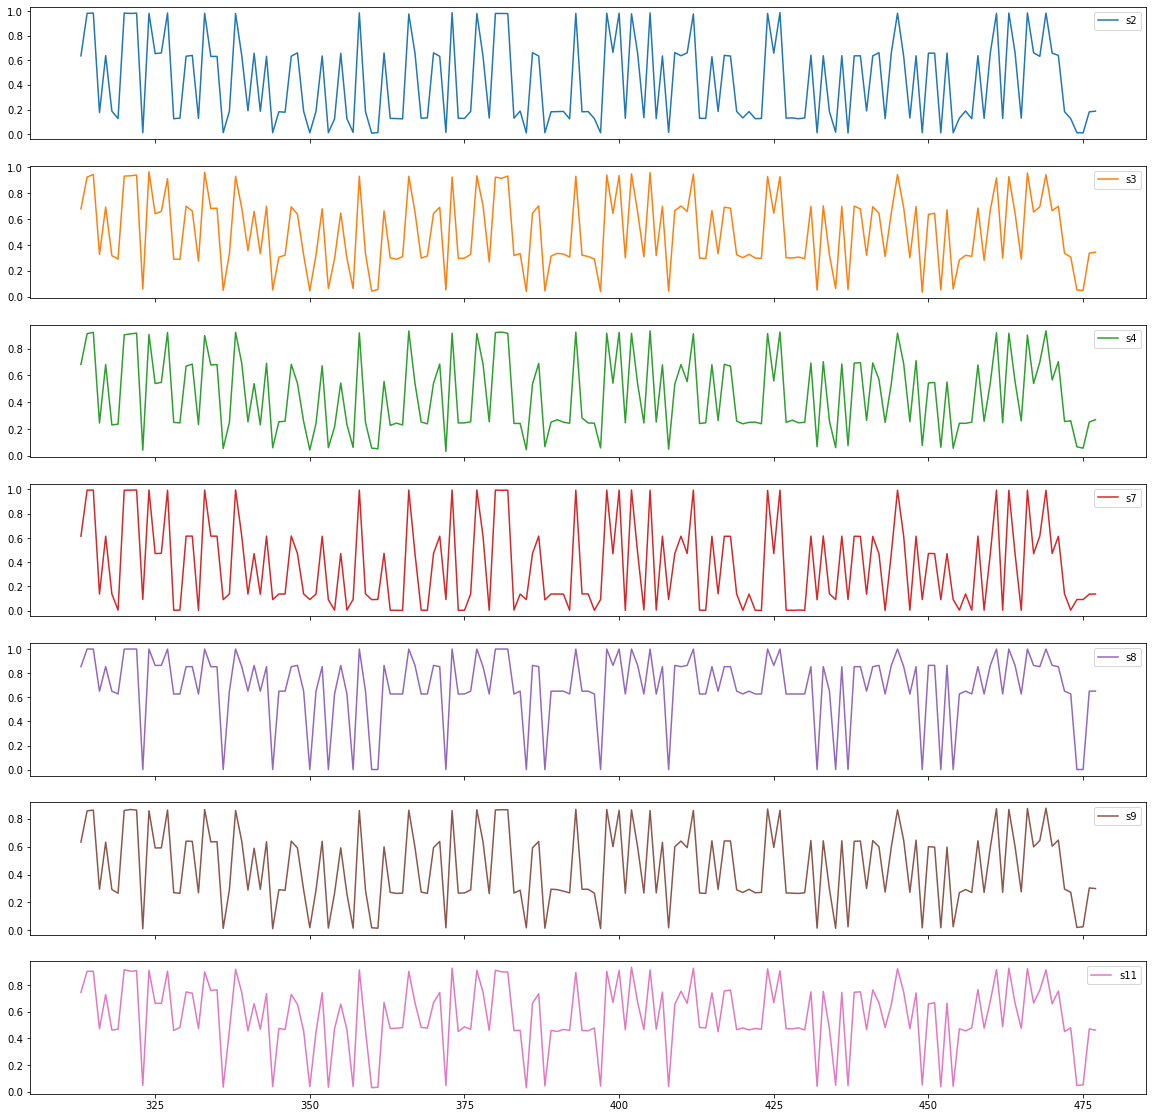

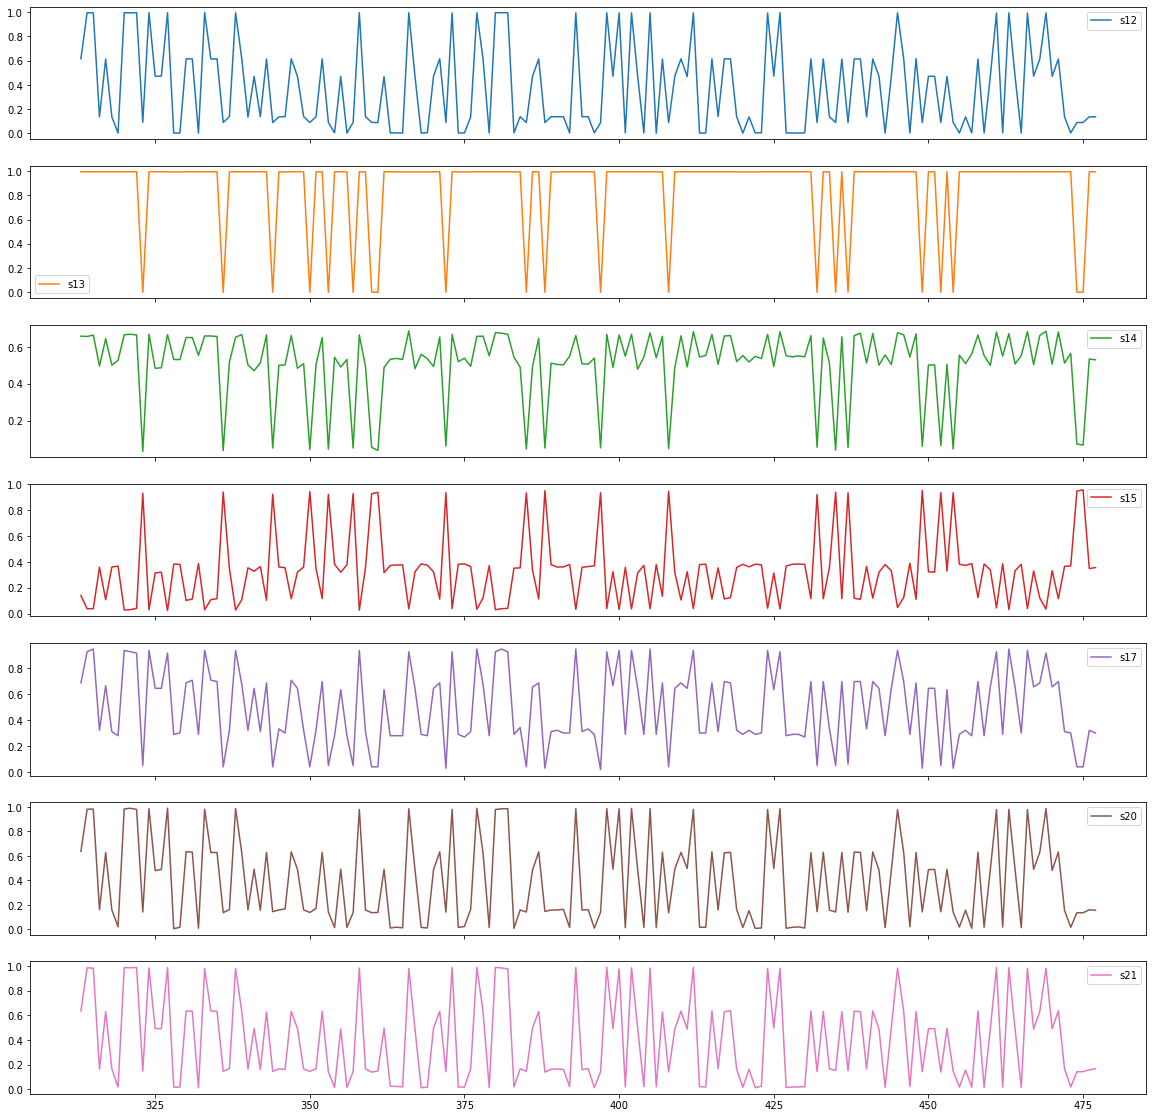

In [22]:
sequence_length = 35
sequence_length_ = 20  # length of sequence for each agent distraction
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s2', 's3', 's4', 's7', 's8', 's9', 's11']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s12', 's13', 's14', 's15', 's17', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 2, 3, 4, 7, 8, 9, 11
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 12, 13, 14, 15, 17, 20, 21
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

## Generate Train Data

In [23]:
# pick the feature columns
sensor_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)

### generator train data for the sequences for each agent and save in a list

In [24]:
# Train data
# generator train data for the sequences for each agent and save in a list
data_array_ = {}
for i in train_df['id'].unique():
    seq_gen_ = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length_, sequence_cols)) for id in [i])
    data_array_[i] = np.concatenate(list(seq_gen_)).astype(np.float32)

### generate train labels for each agent and save in a list

In [25]:
label_array_ = {}
# generate train labels for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_ = (gen_labels(train_df[train_df['id'] == id], sequence_length_, ['label1']) for id in [i])
    label_array_[i] = np.concatenate(list(label_gen_)).astype(np.float32)

### Generate train labels based on RUL for each agent and save in a list

In [26]:
label_array_rul_ = {}
# Generate train labels based on RUL for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_rul_ = (gen_labels(train_df[train_df['id'] == id], sequence_length_, ['RUL']) for id in [i])
    label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)

C:\Users\LO98E8~1\Temp\234/ipykernel_44072/1920039281.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)


In [27]:
# Find the minimum length of dataset for each agent
min_length = label_array_rul_[1].shape[0]
for i in train_df['id'].unique():
    if min_length > label_array_rul_[i].shape[0]:
        min_length = label_array_rul_[i].shape[0]

In [28]:
# set all length of lists to the minimum length of arrays
for i in train_df['id'].unique():
    label_array_rul_[i] = label_array_rul_[i][len(label_array_rul_[i]) - min_length:, :]
    label_array_[i] = label_array_[i][len(label_array_[i]) - min_length:, :]
    data_array_[i] = data_array_[i][len(data_array_[i]) - min_length:, :, :]
    
print(len(data_array_))
print(len(label_array_))
print(len(label_array_rul_))

print(data_array_[1].shape)
print(label_array_[1].shape)
print(label_array_rul_[1].shape)

260
260
260
(108, 20, 17)
(108, 1)
(108, 1)


### generator test data for the sequences for each agent and save in a list

In [29]:
# Test Data
# generator test data for the sequences for each agent and save in a list
seq_array_test_ = {}
for i in test_df['id'].unique():
    seq_gen_test_ = (list(gen_sequence(test_df[test_df['id'] == id], sequence_length_, sequence_cols)) for id in
                     [i])
    seq_array_test_[i] = np.concatenate(list(seq_gen_test_)).astype(np.float32)

### generate test labels for each agent and save in a list

In [30]:
label_array_test_ = {}
# generatAe test labels for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_ = (gen_labels(test_df[test_df['id'] == id], sequence_length_, ['label1']) for id in [i])
    label_array_test_[i] = np.concatenate(list(label_gen_test_)).astype(np.float32)

### Generate test labels based on RUL for each agent and save in a list

In [31]:
label_array_test_rul_ = {}
# Generate test labels based on RUL for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_rul_ = (gen_labels(test_df[test_df['id'] == id], sequence_length_, ['RUL']) for id in [i])
    label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)

C:\Users\LO98E8~1\Temp\234/ipykernel_44072/500274830.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)


### Select part of the train set which has the length longer than min_length

In [32]:
seq_array_test_tmp = {}
label_array_test_tmp = {}
label_array_test_rul_tmp = {}
for i in test_df['id'].unique():
    tmp = seq_array_test_[i].shape[0]
    if tmp >= min_length:
        seq_array_test_tmp[i] = seq_array_test_[i]
        label_array_test_tmp[i] = label_array_test_[i]
        label_array_test_rul_tmp[i] = label_array_test_rul_[i]

###  change the key of dictionary and indexing it based on increasing number from 1

In [33]:
# change the key of dictionary and indexing it based on increasing number from 1
seq_array_test_ = {}
label_array_test_ = {}
label_array_test_rul_ = {}
j = 1
for i in seq_array_test_tmp.keys():
    seq_array_test_[j] = seq_array_test_tmp[i]
    label_array_test_[j] = label_array_test_tmp[i]
    label_array_test_rul_[j] = label_array_test_rul_tmp[i]
    j += 1

del seq_array_test_tmp
del label_array_test_tmp
del label_array_test_rul_tmp

# set all length of test lists to the minimum length of arrays (min_length)
for i in seq_array_test_.keys():
    label_array_test_rul_[i] = label_array_test_rul_[i][len(label_array_test_rul_[i]) - min_length:, :]
    label_array_test_[i] = label_array_test_[i][len(label_array_test_[i]) - min_length:, :]
    seq_array_test_[i] = seq_array_test_[i][len(seq_array_test_[i]) - min_length:, :, :]

print(len(seq_array_test_))
print(len(label_array_test_))
print(len(label_array_test_rul_))

print(seq_array_test_[1].shape)
print(label_array_test_[1].shape)
print(label_array_test_rul_[1].shape)

X = {}
Y = {}
for i in data_array_.keys():
    X[i - 1] = data_array_[i].reshape(min_length, -1)
    Y[i - 1] = label_array_rul_[i]

X_test = {}
Y_test = {}
for i in seq_array_test_.keys():
    X_test[i - 1] = seq_array_test_[i].reshape(min_length, -1)
    Y_test[i - 1] = label_array_test_rul_[i]

137
137
137
(108, 20, 17)
(108, 1)
(108, 1)


## The main distributed LSTM model for 10 worker, in case of master and workers

In [34]:
num_workers = 10
array_params = [dict() for i in range(num_workers)]
J = [list() for i in range(num_workers)]

worker_model = {}
for worker_i in range(num_workers):
    worker_model[worker_i] = LSTM()
    array_params[worker_i] = worker_model[worker_i].init_random_params()

iteration_epoch = 3000
for i in range(iteration_epoch):
    print("Number of iteration:", i, "/from", iteration_epoch)
    for worker_i in range(num_workers):
        cost, array_params[worker_i] = worker_model[worker_i].train(X[worker_i], Y[worker_i],
                                                                    array_params[worker_i])
        J[worker_i].append(cost)

    for key in array_params[0]:  # Fed average
        tmp = array_params[0][key]
        for worker_i in range(1, num_workers):
            tmp = tmp + array_params[worker_i][key]
        for worker_i in range(num_workers):
            array_params[worker_i][key] = (1 / num_workers) * tmp  # Distribute aggregate parameters to all workers

Number of iteration: 0 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 2 	Batch: 50 - 75 	Loss: [115.38]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 2 	Batch: 50 - 75 	Loss: [115.39]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 2 	Batch: 50 - 75 	Loss: [115.39]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 2 	Batch: 50 - 75 	Loss: [115.39]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 2 	Batch: 50 - 75 	Loss: [115.39]
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 2 	Batch: 50 - 75 	Loss: [115.38]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 2 	Batch: 50 - 75 	Loss: [115.39]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 2 	Batch: 50 - 75 	Loss: [115.39]
Epoch 0 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [115.13]
Epoch 1 	Batch: 50 - 75 	Loss: [115.1]
Epoch 2 	Batch: 50 - 75 	Loss: [115.08]
Epoch 0 	Batch: 50 - 75 	Loss: [115.1]
Epoch 1 	Batch: 50 - 75 	Loss: [115.08]
Epoch 2 	Batch: 50 - 75 	Loss: [115.05]
Epoch 0 	Batch: 50 - 75 	Loss: [115.07]
Epoch 1 	Batch: 50 - 75 	Loss: [115.04]
Epoch 2 	Batch: 50 - 75 	Loss: [115.01]
Number of iteration: 7 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.02]
Epoch 1 	Batch: 50 - 75 	Loss: [114.99]
Epoch 2 	Batch: 50 - 75 	Loss: [114.96]
Epoch 0 	Batch: 50 - 75 	Loss: [115.06]
Epoch 1 	Batch: 50 - 75 	Loss: [115.04]
Epoch 2 	Batch: 50 - 75 	Loss: [115.01]
Epoch 0 	Batch: 50 - 75 	Loss: [115.05]
Epoch 1 	Batch: 50 - 75 	Loss: [115.02]
Epoch 2 	Batch: 50 - 75 	Loss: [114.99]
Epoch 0 	Batch: 50 - 75 	Loss: [115.02]
Epoch 1 	Batch: 50 - 75 	Loss: [114.99]
Epoch 2 	Batch: 50 - 75 	Loss: [114.96]
Epoch 0 	Batch: 50 - 75 	Loss: [115.01]
Epoch 1 	Batch: 50 - 75 	Loss: [114.98]
Epoch 2 	Batch: 50 - 75 	Loss: [114.95]
Epoch 0 

Epoch 2 	Batch: 50 - 75 	Loss: [114.11]
Epoch 0 	Batch: 50 - 75 	Loss: [114.4]
Epoch 1 	Batch: 50 - 75 	Loss: [114.37]
Epoch 2 	Batch: 50 - 75 	Loss: [114.32]
Epoch 0 	Batch: 50 - 75 	Loss: [114.33]
Epoch 1 	Batch: 50 - 75 	Loss: [114.28]
Epoch 2 	Batch: 50 - 75 	Loss: [114.23]
Epoch 0 	Batch: 50 - 75 	Loss: [114.36]
Epoch 1 	Batch: 50 - 75 	Loss: [114.31]
Epoch 2 	Batch: 50 - 75 	Loss: [114.25]
Epoch 0 	Batch: 50 - 75 	Loss: [114.51]
Epoch 1 	Batch: 50 - 75 	Loss: [114.48]
Epoch 2 	Batch: 50 - 75 	Loss: [114.42]
Epoch 0 	Batch: 50 - 75 	Loss: [114.36]
Epoch 1 	Batch: 50 - 75 	Loss: [114.31]
Epoch 2 	Batch: 50 - 75 	Loss: [114.24]
Epoch 0 	Batch: 50 - 75 	Loss: [114.27]
Epoch 1 	Batch: 50 - 75 	Loss: [114.22]
Epoch 2 	Batch: 50 - 75 	Loss: [114.16]
Number of iteration: 14 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [114.16]
Epoch 1 	Batch: 50 - 75 	Loss: [114.12]
Epoch 2 	Batch: 50 - 75 	Loss: [114.07]
Epoch 0 	Batch: 50 - 75 	Loss: [114.44]
Epoch 1 	Batch: 50 - 75 	Loss: [114.41]
Epoch 

Epoch 1 	Batch: 50 - 75 	Loss: [113.06]
Epoch 2 	Batch: 50 - 75 	Loss: [112.99]
Epoch 0 	Batch: 50 - 75 	Loss: [113.71]
Epoch 1 	Batch: 50 - 75 	Loss: [113.67]
Epoch 2 	Batch: 50 - 75 	Loss: [113.61]
Epoch 0 	Batch: 50 - 75 	Loss: [113.06]
Epoch 1 	Batch: 50 - 75 	Loss: [112.99]
Epoch 2 	Batch: 50 - 75 	Loss: [112.89]
Epoch 0 	Batch: 50 - 75 	Loss: [112.66]
Epoch 1 	Batch: 50 - 75 	Loss: [112.58]
Epoch 2 	Batch: 50 - 75 	Loss: [112.5]
Epoch 0 	Batch: 50 - 75 	Loss: [113.28]
Epoch 1 	Batch: 50 - 75 	Loss: [113.22]
Epoch 2 	Batch: 50 - 75 	Loss: [113.16]
Epoch 0 	Batch: 50 - 75 	Loss: [113.]
Epoch 1 	Batch: 50 - 75 	Loss: [112.92]
Epoch 2 	Batch: 50 - 75 	Loss: [112.85]
Epoch 0 	Batch: 50 - 75 	Loss: [113.]
Epoch 1 	Batch: 50 - 75 	Loss: [112.93]
Epoch 2 	Batch: 50 - 75 	Loss: [112.84]
Epoch 0 	Batch: 50 - 75 	Loss: [113.42]
Epoch 1 	Batch: 50 - 75 	Loss: [113.36]
Epoch 2 	Batch: 50 - 75 	Loss: [113.3]
Epoch 0 	Batch: 50 - 75 	Loss: [112.99]
Epoch 1 	Batch: 50 - 75 	Loss: [112.91]
Epoch 

Epoch 2 	Batch: 50 - 75 	Loss: [111.94]
Epoch 0 	Batch: 50 - 75 	Loss: [111.33]
Epoch 1 	Batch: 50 - 75 	Loss: [111.22]
Epoch 2 	Batch: 50 - 75 	Loss: [111.11]
Epoch 0 	Batch: 50 - 75 	Loss: [111.4]
Epoch 1 	Batch: 50 - 75 	Loss: [111.3]
Epoch 2 	Batch: 50 - 75 	Loss: [111.19]
Number of iteration: 27 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [111.47]
Epoch 1 	Batch: 50 - 75 	Loss: [111.38]
Epoch 2 	Batch: 50 - 75 	Loss: [111.31]
Epoch 0 	Batch: 50 - 75 	Loss: [112.56]
Epoch 1 	Batch: 50 - 75 	Loss: [112.48]
Epoch 2 	Batch: 50 - 75 	Loss: [112.38]
Epoch 0 	Batch: 50 - 75 	Loss: [110.93]
Epoch 1 	Batch: 50 - 75 	Loss: [110.81]
Epoch 2 	Batch: 50 - 75 	Loss: [110.68]
Epoch 0 	Batch: 50 - 75 	Loss: [110.87]
Epoch 1 	Batch: 50 - 75 	Loss: [110.77]
Epoch 2 	Batch: 50 - 75 	Loss: [110.68]
Epoch 0 	Batch: 50 - 75 	Loss: [111.62]
Epoch 1 	Batch: 50 - 75 	Loss: [111.52]
Epoch 2 	Batch: 50 - 75 	Loss: [111.42]
Epoch 0 	Batch: 50 - 75 	Loss: [110.99]
Epoch 1 	Batch: 50 - 75 	Loss: [110.87]
Epoch 2

Epoch 1 	Batch: 50 - 75 	Loss: [109.62]
Epoch 2 	Batch: 50 - 75 	Loss: [109.51]
Epoch 0 	Batch: 50 - 75 	Loss: [108.84]
Epoch 1 	Batch: 50 - 75 	Loss: [108.71]
Epoch 2 	Batch: 50 - 75 	Loss: [108.58]
Epoch 0 	Batch: 50 - 75 	Loss: [109.12]
Epoch 1 	Batch: 50 - 75 	Loss: [108.99]
Epoch 2 	Batch: 50 - 75 	Loss: [108.86]
Epoch 0 	Batch: 50 - 75 	Loss: [110.05]
Epoch 1 	Batch: 50 - 75 	Loss: [109.95]
Epoch 2 	Batch: 50 - 75 	Loss: [109.83]
Epoch 0 	Batch: 50 - 75 	Loss: [108.99]
Epoch 1 	Batch: 50 - 75 	Loss: [108.88]
Epoch 2 	Batch: 50 - 75 	Loss: [108.77]
Epoch 0 	Batch: 50 - 75 	Loss: [109.16]
Epoch 1 	Batch: 50 - 75 	Loss: [109.04]
Epoch 2 	Batch: 50 - 75 	Loss: [108.92]
Number of iteration: 34 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [109.32]
Epoch 1 	Batch: 50 - 75 	Loss: [109.2]
Epoch 2 	Batch: 50 - 75 	Loss: [109.1]
Epoch 0 	Batch: 50 - 75 	Loss: [111.01]
Epoch 1 	Batch: 50 - 75 	Loss: [110.9]
Epoch 2 	Batch: 50 - 75 	Loss: [110.79]
Epoch 0 	Batch: 50 - 75 	Loss: [108.26]
Epoch 1 

Epoch 0 	Batch: 50 - 75 	Loss: [109.58]
Epoch 1 	Batch: 50 - 75 	Loss: [109.48]
Epoch 2 	Batch: 50 - 75 	Loss: [109.35]
Epoch 0 	Batch: 50 - 75 	Loss: [105.84]
Epoch 1 	Batch: 50 - 75 	Loss: [105.7]
Epoch 2 	Batch: 50 - 75 	Loss: [105.55]
Epoch 0 	Batch: 50 - 75 	Loss: [106.91]
Epoch 1 	Batch: 50 - 75 	Loss: [106.77]
Epoch 2 	Batch: 50 - 75 	Loss: [106.63]
Epoch 0 	Batch: 50 - 75 	Loss: [107.37]
Epoch 1 	Batch: 50 - 75 	Loss: [107.31]
Epoch 2 	Batch: 50 - 75 	Loss: [107.22]
Epoch 0 	Batch: 50 - 75 	Loss: [106.09]
Epoch 1 	Batch: 50 - 75 	Loss: [105.95]
Epoch 2 	Batch: 50 - 75 	Loss: [105.82]
Epoch 0 	Batch: 50 - 75 	Loss: [106.49]
Epoch 1 	Batch: 50 - 75 	Loss: [106.38]
Epoch 2 	Batch: 50 - 75 	Loss: [106.25]
Epoch 0 	Batch: 50 - 75 	Loss: [107.69]
Epoch 1 	Batch: 50 - 75 	Loss: [107.6]
Epoch 2 	Batch: 50 - 75 	Loss: [107.48]
Epoch 0 	Batch: 50 - 75 	Loss: [106.48]
Epoch 1 	Batch: 50 - 75 	Loss: [106.35]
Epoch 2 	Batch: 50 - 75 	Loss: [106.21]
Epoch 0 	Batch: 50 - 75 	Loss: [106.67]
Ep

Epoch 1 	Batch: 50 - 75 	Loss: [104.]
Epoch 2 	Batch: 50 - 75 	Loss: [103.87]
Epoch 0 	Batch: 50 - 75 	Loss: [104.38]
Epoch 1 	Batch: 50 - 75 	Loss: [104.24]
Epoch 2 	Batch: 50 - 75 	Loss: [104.1]
Number of iteration: 47 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [104.92]
Epoch 1 	Batch: 50 - 75 	Loss: [104.8]
Epoch 2 	Batch: 50 - 75 	Loss: [104.67]
Epoch 0 	Batch: 50 - 75 	Loss: [107.54]
Epoch 1 	Batch: 50 - 75 	Loss: [107.38]
Epoch 2 	Batch: 50 - 75 	Loss: [107.24]
Epoch 0 	Batch: 50 - 75 	Loss: [102.77]
Epoch 1 	Batch: 50 - 75 	Loss: [102.62]
Epoch 2 	Batch: 50 - 75 	Loss: [102.47]
Epoch 0 	Batch: 50 - 75 	Loss: [104.04]
Epoch 1 	Batch: 50 - 75 	Loss: [103.88]
Epoch 2 	Batch: 50 - 75 	Loss: [103.72]
Epoch 0 	Batch: 50 - 75 	Loss: [104.75]
Epoch 1 	Batch: 50 - 75 	Loss: [104.62]
Epoch 2 	Batch: 50 - 75 	Loss: [104.48]
Epoch 0 	Batch: 50 - 75 	Loss: [103.26]
Epoch 1 	Batch: 50 - 75 	Loss: [103.12]
Epoch 2 	Batch: 50 - 75 	Loss: [102.96]
Epoch 0 	Batch: 50 - 75 	Loss: [103.8]
Epoch 1 	B

Epoch 0 	Batch: 50 - 75 	Loss: [100.68]
Epoch 1 	Batch: 50 - 75 	Loss: [100.54]
Epoch 2 	Batch: 50 - 75 	Loss: [100.38]
Epoch 0 	Batch: 50 - 75 	Loss: [101.37]
Epoch 1 	Batch: 50 - 75 	Loss: [101.24]
Epoch 2 	Batch: 50 - 75 	Loss: [101.09]
Epoch 0 	Batch: 50 - 75 	Loss: [102.79]
Epoch 1 	Batch: 50 - 75 	Loss: [102.66]
Epoch 2 	Batch: 50 - 75 	Loss: [102.51]
Epoch 0 	Batch: 50 - 75 	Loss: [101.33]
Epoch 1 	Batch: 50 - 75 	Loss: [101.19]
Epoch 2 	Batch: 50 - 75 	Loss: [101.04]
Epoch 0 	Batch: 50 - 75 	Loss: [101.53]
Epoch 1 	Batch: 50 - 75 	Loss: [101.38]
Epoch 2 	Batch: 50 - 75 	Loss: [101.23]
Number of iteration: 54 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [102.35]
Epoch 1 	Batch: 50 - 75 	Loss: [102.24]
Epoch 2 	Batch: 50 - 75 	Loss: [102.13]
Epoch 0 	Batch: 50 - 75 	Loss: [105.23]
Epoch 1 	Batch: 50 - 75 	Loss: [105.11]
Epoch 2 	Batch: 50 - 75 	Loss: [104.94]
Epoch 0 	Batch: 50 - 75 	Loss: [99.55]
Epoch 1 	Batch: 50 - 75 	Loss: [99.4]
Epoch 2 	Batch: 50 - 75 	Loss: [99.24]
Epoch 0 	

Epoch 1 	Batch: 50 - 75 	Loss: [96.46]
Epoch 2 	Batch: 50 - 75 	Loss: [96.28]
Epoch 0 	Batch: 50 - 75 	Loss: [98.06]
Epoch 1 	Batch: 50 - 75 	Loss: [97.91]
Epoch 2 	Batch: 50 - 75 	Loss: [97.73]
Epoch 0 	Batch: 50 - 75 	Loss: [99.12]
Epoch 1 	Batch: 50 - 75 	Loss: [98.97]
Epoch 2 	Batch: 50 - 75 	Loss: [98.81]
Epoch 0 	Batch: 50 - 75 	Loss: [97.62]
Epoch 1 	Batch: 50 - 75 	Loss: [97.47]
Epoch 2 	Batch: 50 - 75 	Loss: [97.31]
Epoch 0 	Batch: 50 - 75 	Loss: [98.43]
Epoch 1 	Batch: 50 - 75 	Loss: [98.28]
Epoch 2 	Batch: 50 - 75 	Loss: [98.12]
Epoch 0 	Batch: 50 - 75 	Loss: [100.01]
Epoch 1 	Batch: 50 - 75 	Loss: [99.88]
Epoch 2 	Batch: 50 - 75 	Loss: [99.73]
Epoch 0 	Batch: 50 - 75 	Loss: [98.4]
Epoch 1 	Batch: 50 - 75 	Loss: [98.27]
Epoch 2 	Batch: 50 - 75 	Loss: [98.13]
Epoch 0 	Batch: 50 - 75 	Loss: [98.55]
Epoch 1 	Batch: 50 - 75 	Loss: [98.4]
Epoch 2 	Batch: 50 - 75 	Loss: [98.24]
Number of iteration: 61 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [99.62]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [97.]
Epoch 2 	Batch: 50 - 75 	Loss: [96.85]
Epoch 0 	Batch: 50 - 75 	Loss: [100.8]
Epoch 1 	Batch: 50 - 75 	Loss: [100.68]
Epoch 2 	Batch: 50 - 75 	Loss: [100.51]
Epoch 0 	Batch: 50 - 75 	Loss: [93.08]
Epoch 1 	Batch: 50 - 75 	Loss: [92.9]
Epoch 2 	Batch: 50 - 75 	Loss: [92.72]
Epoch 0 	Batch: 50 - 75 	Loss: [94.8]
Epoch 1 	Batch: 50 - 75 	Loss: [94.63]
Epoch 2 	Batch: 50 - 75 	Loss: [94.46]
Epoch 0 	Batch: 50 - 75 	Loss: [95.98]
Epoch 1 	Batch: 50 - 75 	Loss: [95.83]
Epoch 2 	Batch: 50 - 75 	Loss: [95.67]
Epoch 0 	Batch: 50 - 75 	Loss: [94.48]
Epoch 1 	Batch: 50 - 75 	Loss: [94.33]
Epoch 2 	Batch: 50 - 75 	Loss: [94.17]
Epoch 0 	Batch: 50 - 75 	Loss: [95.28]
Epoch 1 	Batch: 50 - 75 	Loss: [95.13]
Epoch 2 	Batch: 50 - 75 	Loss: [94.97]
Epoch 0 	Batch: 50 - 75 	Loss: [97.04]
Epoch 1 	Batch: 50 - 75 	Loss: [96.9]
Epoch 2 	Batch: 50 - 75 	Loss: [96.74]
Epoch 0 	Batch: 50 - 75 	Loss: [95.49]
Epoch 1 	Batch: 50 - 75 	Loss: [95.35]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [92.97]
Epoch 1 	Batch: 50 - 75 	Loss: [92.82]
Epoch 2 	Batch: 50 - 75 	Loss: [92.66]
Number of iteration: 74 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [94.15]
Epoch 1 	Batch: 50 - 75 	Loss: [94.02]
Epoch 2 	Batch: 50 - 75 	Loss: [93.87]
Epoch 0 	Batch: 50 - 75 	Loss: [98.18]
Epoch 1 	Batch: 50 - 75 	Loss: [98.05]
Epoch 2 	Batch: 50 - 75 	Loss: [97.88]
Epoch 0 	Batch: 50 - 75 	Loss: [89.46]
Epoch 1 	Batch: 50 - 75 	Loss: [89.29]
Epoch 2 	Batch: 50 - 75 	Loss: [89.11]
Epoch 0 	Batch: 50 - 75 	Loss: [91.58]
Epoch 1 	Batch: 50 - 75 	Loss: [91.42]
Epoch 2 	Batch: 50 - 75 	Loss: [91.24]
Epoch 0 	Batch: 50 - 75 	Loss: [92.86]
Epoch 1 	Batch: 50 - 75 	Loss: [92.72]
Epoch 2 	Batch: 50 - 75 	Loss: [92.56]
Epoch 0 	Batch: 50 - 75 	Loss: [91.28]
Epoch 1 	Batch: 50 - 75 	Loss: [91.12]
Epoch 2 	Batch: 50 - 75 	Loss: [90.96]
Epoch 0 	Batch: 50 - 75 	Loss: [92.03]
Epoch 1 	Batch: 50 - 75 	Loss: [91.88]
Epoch 2 	Batch: 50 - 75 	Loss: [91.72]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [91.24]
Epoch 0 	Batch: 50 - 75 	Loss: [89.88]
Epoch 1 	Batch: 50 - 75 	Loss: [89.74]
Epoch 2 	Batch: 50 - 75 	Loss: [89.59]
Epoch 0 	Batch: 50 - 75 	Loss: [89.94]
Epoch 1 	Batch: 50 - 75 	Loss: [89.79]
Epoch 2 	Batch: 50 - 75 	Loss: [89.64]
Number of iteration: 81 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [91.11]
Epoch 1 	Batch: 50 - 75 	Loss: [90.97]
Epoch 2 	Batch: 50 - 75 	Loss: [90.81]
Epoch 0 	Batch: 50 - 75 	Loss: [95.53]
Epoch 1 	Batch: 50 - 75 	Loss: [95.37]
Epoch 2 	Batch: 50 - 75 	Loss: [95.21]
Epoch 0 	Batch: 50 - 75 	Loss: [85.82]
Epoch 1 	Batch: 50 - 75 	Loss: [85.64]
Epoch 2 	Batch: 50 - 75 	Loss: [85.46]
Epoch 0 	Batch: 50 - 75 	Loss: [88.24]
Epoch 1 	Batch: 50 - 75 	Loss: [88.06]
Epoch 2 	Batch: 50 - 75 	Loss: [87.88]
Epoch 0 	Batch: 50 - 75 	Loss: [89.7]
Epoch 1 	Batch: 50 - 75 	Loss: [89.55]
Epoch 2 	Batch: 50 - 75 	Loss: [89.38]
Epoch 0 	Batch: 50 - 75 	Loss: [88.03]
Epoch 1 	Batch: 50 - 75 	Loss: [87.87]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [85.79]
Epoch 2 	Batch: 50 - 75 	Loss: [85.62]
Epoch 0 	Batch: 50 - 75 	Loss: [88.51]
Epoch 1 	Batch: 50 - 75 	Loss: [88.38]
Epoch 2 	Batch: 50 - 75 	Loss: [88.22]
Epoch 0 	Batch: 50 - 75 	Loss: [86.86]
Epoch 1 	Batch: 50 - 75 	Loss: [86.72]
Epoch 2 	Batch: 50 - 75 	Loss: [86.57]
Epoch 0 	Batch: 50 - 75 	Loss: [86.87]
Epoch 1 	Batch: 50 - 75 	Loss: [86.71]
Epoch 2 	Batch: 50 - 75 	Loss: [86.55]
Number of iteration: 88 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [88.02]
Epoch 1 	Batch: 50 - 75 	Loss: [87.89]
Epoch 2 	Batch: 50 - 75 	Loss: [87.75]
Epoch 0 	Batch: 50 - 75 	Loss: [92.77]
Epoch 1 	Batch: 50 - 75 	Loss: [92.63]
Epoch 2 	Batch: 50 - 75 	Loss: [92.46]
Epoch 0 	Batch: 50 - 75 	Loss: [82.14]
Epoch 1 	Batch: 50 - 75 	Loss: [81.96]
Epoch 2 	Batch: 50 - 75 	Loss: [81.78]
Epoch 0 	Batch: 50 - 75 	Loss: [84.81]
Epoch 1 	Batch: 50 - 75 	Loss: [84.63]
Epoch 2 	Batch: 50 - 75 	Loss: [84.45]
Epoch 0 	Batch: 50 - 75 	Loss: [86.46]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [81.89]
Epoch 1 	Batch: 50 - 75 	Loss: [81.74]
Epoch 2 	Batch: 50 - 75 	Loss: [81.57]
Epoch 0 	Batch: 50 - 75 	Loss: [82.6]
Epoch 1 	Batch: 50 - 75 	Loss: [82.44]
Epoch 2 	Batch: 50 - 75 	Loss: [82.27]
Epoch 0 	Batch: 50 - 75 	Loss: [85.52]
Epoch 1 	Batch: 50 - 75 	Loss: [85.39]
Epoch 2 	Batch: 50 - 75 	Loss: [85.24]
Epoch 0 	Batch: 50 - 75 	Loss: [83.84]
Epoch 1 	Batch: 50 - 75 	Loss: [83.7]
Epoch 2 	Batch: 50 - 75 	Loss: [83.55]
Epoch 0 	Batch: 50 - 75 	Loss: [83.77]
Epoch 1 	Batch: 50 - 75 	Loss: [83.62]
Epoch 2 	Batch: 50 - 75 	Loss: [83.46]
Number of iteration: 95 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [84.96]
Epoch 1 	Batch: 50 - 75 	Loss: [84.82]
Epoch 2 	Batch: 50 - 75 	Loss: [84.66]
Epoch 0 	Batch: 50 - 75 	Loss: [90.06]
Epoch 1 	Batch: 50 - 75 	Loss: [89.91]
Epoch 2 	Batch: 50 - 75 	Loss: [89.74]
Epoch 0 	Batch: 50 - 75 	Loss: [78.54]
Epoch 1 	Batch: 50 - 75 	Loss: [78.37]
Epoch 2 	Batch: 50 - 75 	Loss: [78.2]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 2 	Batch: 50 - 75 	Loss: [78.06]
Epoch 0 	Batch: 50 - 75 	Loss: [80.56]
Epoch 1 	Batch: 50 - 75 	Loss: [80.41]
Epoch 2 	Batch: 50 - 75 	Loss: [80.25]
Epoch 0 	Batch: 50 - 75 	Loss: [78.57]
Epoch 1 	Batch: 50 - 75 	Loss: [78.42]
Epoch 2 	Batch: 50 - 75 	Loss: [78.26]
Epoch 0 	Batch: 50 - 75 	Loss: [79.24]
Epoch 1 	Batch: 50 - 75 	Loss: [79.1]
Epoch 2 	Batch: 50 - 75 	Loss: [78.93]
Epoch 0 	Batch: 50 - 75 	Loss: [82.51]
Epoch 1 	Batch: 50 - 75 	Loss: [82.38]
Epoch 2 	Batch: 50 - 75 	Loss: [82.22]
Epoch 0 	Batch: 50 - 75 	Loss: [80.83]
Epoch 1 	Batch: 50 - 75 	Loss: [80.69]
Epoch 2 	Batch: 50 - 75 	Loss: [80.53]
Epoch 0 	Batch: 50 - 75 	Loss: [80.6]
Epoch 1 	Batch: 50 - 75 	Loss: [80.45]
Epoch 2 	Batch: 50 - 75 	Loss: [80.28]
Number of iteration: 102 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [81.87]
Epoch 1 	Batch: 50 - 75 	Loss: [81.73]
Epoch 2 	Batch: 50 - 75 	Loss: [81.58]
Epoch 0 	Batch: 50 - 75 	Loss: [87.26]
Epoch 1 	Batch: 50 - 75 	Loss: [87.11]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [71.92]
Epoch 2 	Batch: 50 - 75 	Loss: [71.75]
Epoch 0 	Batch: 50 - 75 	Loss: [75.09]
Epoch 1 	Batch: 50 - 75 	Loss: [74.92]
Epoch 2 	Batch: 50 - 75 	Loss: [74.75]
Epoch 0 	Batch: 50 - 75 	Loss: [77.4]
Epoch 1 	Batch: 50 - 75 	Loss: [77.27]
Epoch 2 	Batch: 50 - 75 	Loss: [77.11]
Epoch 0 	Batch: 50 - 75 	Loss: [75.29]
Epoch 1 	Batch: 50 - 75 	Loss: [75.14]
Epoch 2 	Batch: 50 - 75 	Loss: [74.97]
Epoch 0 	Batch: 50 - 75 	Loss: [76.06]
Epoch 1 	Batch: 50 - 75 	Loss: [75.9]
Epoch 2 	Batch: 50 - 75 	Loss: [75.74]
Epoch 0 	Batch: 50 - 75 	Loss: [79.55]
Epoch 1 	Batch: 50 - 75 	Loss: [79.41]
Epoch 2 	Batch: 50 - 75 	Loss: [79.25]
Epoch 0 	Batch: 50 - 75 	Loss: [77.96]
Epoch 1 	Batch: 50 - 75 	Loss: [77.86]
Epoch 2 	Batch: 50 - 75 	Loss: [77.74]
Epoch 0 	Batch: 50 - 75 	Loss: [77.39]
Epoch 1 	Batch: 50 - 75 	Loss: [77.25]
Epoch 2 	Batch: 50 - 75 	Loss: [77.1]
Number of iteration: 109 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [78.79]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [82.28]
Epoch 1 	Batch: 50 - 75 	Loss: [82.12]
Epoch 2 	Batch: 50 - 75 	Loss: [81.96]
Epoch 0 	Batch: 50 - 75 	Loss: [68.64]
Epoch 1 	Batch: 50 - 75 	Loss: [68.48]
Epoch 2 	Batch: 50 - 75 	Loss: [68.32]
Epoch 0 	Batch: 50 - 75 	Loss: [71.8]
Epoch 1 	Batch: 50 - 75 	Loss: [71.63]
Epoch 2 	Batch: 50 - 75 	Loss: [71.46]
Epoch 0 	Batch: 50 - 75 	Loss: [74.34]
Epoch 1 	Batch: 50 - 75 	Loss: [74.19]
Epoch 2 	Batch: 50 - 75 	Loss: [74.04]
Epoch 0 	Batch: 50 - 75 	Loss: [72.08]
Epoch 1 	Batch: 50 - 75 	Loss: [71.93]
Epoch 2 	Batch: 50 - 75 	Loss: [71.77]
Epoch 0 	Batch: 50 - 75 	Loss: [72.9]
Epoch 1 	Batch: 50 - 75 	Loss: [72.76]
Epoch 2 	Batch: 50 - 75 	Loss: [72.6]
Epoch 0 	Batch: 50 - 75 	Loss: [76.64]
Epoch 1 	Batch: 50 - 75 	Loss: [76.53]
Epoch 2 	Batch: 50 - 75 	Loss: [76.38]
Epoch 0 	Batch: 50 - 75 	Loss: [75.14]
Epoch 1 	Batch: 50 - 75 	Loss: [75.01]
Epoch 2 	Batch: 50 - 75 	Loss: [74.86]
Epoch 0 	Batch: 50 - 75 	Loss: [74.26]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [71.26]
Number of iteration: 122 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [72.87]
Epoch 1 	Batch: 50 - 75 	Loss: [72.73]
Epoch 2 	Batch: 50 - 75 	Loss: [72.58]
Epoch 0 	Batch: 50 - 75 	Loss: [79.74]
Epoch 1 	Batch: 50 - 75 	Loss: [79.59]
Epoch 2 	Batch: 50 - 75 	Loss: [79.43]
Epoch 0 	Batch: 50 - 75 	Loss: [65.27]
Epoch 1 	Batch: 50 - 75 	Loss: [65.11]
Epoch 2 	Batch: 50 - 75 	Loss: [64.95]
Epoch 0 	Batch: 50 - 75 	Loss: [68.58]
Epoch 1 	Batch: 50 - 75 	Loss: [68.43]
Epoch 2 	Batch: 50 - 75 	Loss: [68.26]
Epoch 0 	Batch: 50 - 75 	Loss: [71.31]
Epoch 1 	Batch: 50 - 75 	Loss: [71.19]
Epoch 2 	Batch: 50 - 75 	Loss: [71.04]
Epoch 0 	Batch: 50 - 75 	Loss: [68.89]
Epoch 1 	Batch: 50 - 75 	Loss: [68.74]
Epoch 2 	Batch: 50 - 75 	Loss: [68.59]
Epoch 0 	Batch: 50 - 75 	Loss: [69.75]
Epoch 1 	Batch: 50 - 75 	Loss: [69.6]
Epoch 2 	Batch: 50 - 75 	Loss: [69.45]
Epoch 0 	Batch: 50 - 75 	Loss: [73.79]
Epoch 1 	Batch: 50 - 75 	Loss: [73.64]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [69.62]
Epoch 2 	Batch: 50 - 75 	Loss: [69.48]
Epoch 0 	Batch: 50 - 75 	Loss: [68.48]
Epoch 1 	Batch: 50 - 75 	Loss: [68.34]
Epoch 2 	Batch: 50 - 75 	Loss: [68.19]
Number of iteration: 129 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [69.74]
Epoch 1 	Batch: 50 - 75 	Loss: [69.6]
Epoch 2 	Batch: 50 - 75 	Loss: [69.44]
Epoch 0 	Batch: 50 - 75 	Loss: [77.48]
Epoch 1 	Batch: 50 - 75 	Loss: [77.4]
Epoch 2 	Batch: 50 - 75 	Loss: [77.25]
Epoch 0 	Batch: 50 - 75 	Loss: [62.]
Epoch 1 	Batch: 50 - 75 	Loss: [61.85]
Epoch 2 	Batch: 50 - 75 	Loss: [61.69]
Epoch 0 	Batch: 50 - 75 	Loss: [65.44]
Epoch 1 	Batch: 50 - 75 	Loss: [65.28]
Epoch 2 	Batch: 50 - 75 	Loss: [65.12]
Epoch 0 	Batch: 50 - 75 	Loss: [68.34]
Epoch 1 	Batch: 50 - 75 	Loss: [68.2]
Epoch 2 	Batch: 50 - 75 	Loss: [68.05]
Epoch 0 	Batch: 50 - 75 	Loss: [65.77]
Epoch 1 	Batch: 50 - 75 	Loss: [65.63]
Epoch 2 	Batch: 50 - 75 	Loss: [65.47]
Epoch 0 	Batch: 50 - 75 	Loss: [66.73]
Epoch 1 	Batch: 50 - 75 	Loss: [6

Epoch 0 	Batch: 50 - 75 	Loss: [68.66]
Epoch 1 	Batch: 50 - 75 	Loss: [68.56]
Epoch 2 	Batch: 50 - 75 	Loss: [68.43]
Epoch 0 	Batch: 50 - 75 	Loss: [66.93]
Epoch 1 	Batch: 50 - 75 	Loss: [66.81]
Epoch 2 	Batch: 50 - 75 	Loss: [66.67]
Epoch 0 	Batch: 50 - 75 	Loss: [65.46]
Epoch 1 	Batch: 50 - 75 	Loss: [65.32]
Epoch 2 	Batch: 50 - 75 	Loss: [65.17]
Number of iteration: 136 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [66.63]
Epoch 1 	Batch: 50 - 75 	Loss: [66.48]
Epoch 2 	Batch: 50 - 75 	Loss: [66.32]
Epoch 0 	Batch: 50 - 75 	Loss: [75.23]
Epoch 1 	Batch: 50 - 75 	Loss: [75.08]
Epoch 2 	Batch: 50 - 75 	Loss: [74.92]
Epoch 0 	Batch: 50 - 75 	Loss: [58.83]
Epoch 1 	Batch: 50 - 75 	Loss: [58.68]
Epoch 2 	Batch: 50 - 75 	Loss: [58.53]
Epoch 0 	Batch: 50 - 75 	Loss: [62.37]
Epoch 1 	Batch: 50 - 75 	Loss: [62.22]
Epoch 2 	Batch: 50 - 75 	Loss: [62.06]
Epoch 0 	Batch: 50 - 75 	Loss: [65.45]
Epoch 1 	Batch: 50 - 75 	Loss: [65.34]
Epoch 2 	Batch: 50 - 75 	Loss: [65.18]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [59.86]
Epoch 0 	Batch: 50 - 75 	Loss: [61.28]
Epoch 1 	Batch: 50 - 75 	Loss: [61.14]
Epoch 2 	Batch: 50 - 75 	Loss: [61.]
Epoch 0 	Batch: 50 - 75 	Loss: [65.99]
Epoch 1 	Batch: 50 - 75 	Loss: [65.84]
Epoch 2 	Batch: 50 - 75 	Loss: [65.71]
Epoch 0 	Batch: 50 - 75 	Loss: [64.17]
Epoch 1 	Batch: 50 - 75 	Loss: [64.05]
Epoch 2 	Batch: 50 - 75 	Loss: [63.91]
Epoch 0 	Batch: 50 - 75 	Loss: [62.51]
Epoch 1 	Batch: 50 - 75 	Loss: [62.37]
Epoch 2 	Batch: 50 - 75 	Loss: [62.22]
Number of iteration: 143 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [63.57]
Epoch 1 	Batch: 50 - 75 	Loss: [63.43]
Epoch 2 	Batch: 50 - 75 	Loss: [63.28]
Epoch 0 	Batch: 50 - 75 	Loss: [73.11]
Epoch 1 	Batch: 50 - 75 	Loss: [73.02]
Epoch 2 	Batch: 50 - 75 	Loss: [72.86]
Epoch 0 	Batch: 50 - 75 	Loss: [55.77]
Epoch 1 	Batch: 50 - 75 	Loss: [55.63]
Epoch 2 	Batch: 50 - 75 	Loss: [55.48]
Epoch 0 	Batch: 50 - 75 	Loss: [59.38]
Epoch 1 	Batch: 50 - 75 	Loss: [59.23]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [60.1]
Epoch 2 	Batch: 50 - 75 	Loss: [59.96]
Epoch 0 	Batch: 50 - 75 	Loss: [57.23]
Epoch 1 	Batch: 50 - 75 	Loss: [57.1]
Epoch 2 	Batch: 50 - 75 	Loss: [56.95]
Epoch 0 	Batch: 50 - 75 	Loss: [58.46]
Epoch 1 	Batch: 50 - 75 	Loss: [58.35]
Epoch 2 	Batch: 50 - 75 	Loss: [58.21]
Epoch 0 	Batch: 50 - 75 	Loss: [63.35]
Epoch 1 	Batch: 50 - 75 	Loss: [63.26]
Epoch 2 	Batch: 50 - 75 	Loss: [63.12]
Epoch 0 	Batch: 50 - 75 	Loss: [61.49]
Epoch 1 	Batch: 50 - 75 	Loss: [61.37]
Epoch 2 	Batch: 50 - 75 	Loss: [61.24]
Epoch 0 	Batch: 50 - 75 	Loss: [59.62]
Epoch 1 	Batch: 50 - 75 	Loss: [59.49]
Epoch 2 	Batch: 50 - 75 	Loss: [59.34]
Number of iteration: 150 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [60.62]
Epoch 1 	Batch: 50 - 75 	Loss: [60.48]
Epoch 2 	Batch: 50 - 75 	Loss: [60.33]
Epoch 0 	Batch: 50 - 75 	Loss: [70.95]
Epoch 1 	Batch: 50 - 75 	Loss: [70.82]
Epoch 2 	Batch: 50 - 75 	Loss: [70.68]
Epoch 0 	Batch: 50 - 75 	Loss: [52.86]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [54.06]
Epoch 1 	Batch: 50 - 75 	Loss: [53.93]
Epoch 2 	Batch: 50 - 75 	Loss: [53.78]
Epoch 0 	Batch: 50 - 75 	Loss: [57.49]
Epoch 1 	Batch: 50 - 75 	Loss: [57.37]
Epoch 2 	Batch: 50 - 75 	Loss: [57.23]
Epoch 0 	Batch: 50 - 75 	Loss: [54.4]
Epoch 1 	Batch: 50 - 75 	Loss: [54.27]
Epoch 2 	Batch: 50 - 75 	Loss: [54.13]
Epoch 0 	Batch: 50 - 75 	Loss: [55.71]
Epoch 1 	Batch: 50 - 75 	Loss: [55.58]
Epoch 2 	Batch: 50 - 75 	Loss: [55.45]
Epoch 0 	Batch: 50 - 75 	Loss: [60.79]
Epoch 1 	Batch: 50 - 75 	Loss: [60.65]
Epoch 2 	Batch: 50 - 75 	Loss: [60.53]
Epoch 0 	Batch: 50 - 75 	Loss: [58.89]
Epoch 1 	Batch: 50 - 75 	Loss: [58.78]
Epoch 2 	Batch: 50 - 75 	Loss: [58.65]
Epoch 0 	Batch: 50 - 75 	Loss: [56.8]
Epoch 1 	Batch: 50 - 75 	Loss: [56.68]
Epoch 2 	Batch: 50 - 75 	Loss: [56.54]
Number of iteration: 157 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [57.72]
Epoch 1 	Batch: 50 - 75 	Loss: [57.59]
Epoch 2 	Batch: 50 - 75 	Loss: [57.45]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [66.93]
Epoch 0 	Batch: 50 - 75 	Loss: [47.77]
Epoch 1 	Batch: 50 - 75 	Loss: [47.64]
Epoch 2 	Batch: 50 - 75 	Loss: [47.51]
Epoch 0 	Batch: 50 - 75 	Loss: [51.33]
Epoch 1 	Batch: 50 - 75 	Loss: [51.2]
Epoch 2 	Batch: 50 - 75 	Loss: [51.06]
Epoch 0 	Batch: 50 - 75 	Loss: [54.78]
Epoch 1 	Batch: 50 - 75 	Loss: [54.65]
Epoch 2 	Batch: 50 - 75 	Loss: [54.51]
Epoch 0 	Batch: 50 - 75 	Loss: [51.66]
Epoch 1 	Batch: 50 - 75 	Loss: [51.53]
Epoch 2 	Batch: 50 - 75 	Loss: [51.39]
Epoch 0 	Batch: 50 - 75 	Loss: [53.02]
Epoch 1 	Batch: 50 - 75 	Loss: [52.9]
Epoch 2 	Batch: 50 - 75 	Loss: [52.77]
Epoch 0 	Batch: 50 - 75 	Loss: [58.29]
Epoch 1 	Batch: 50 - 75 	Loss: [58.2]
Epoch 2 	Batch: 50 - 75 	Loss: [58.06]
Epoch 0 	Batch: 50 - 75 	Loss: [56.38]
Epoch 1 	Batch: 50 - 75 	Loss: [56.26]
Epoch 2 	Batch: 50 - 75 	Loss: [56.14]
Epoch 0 	Batch: 50 - 75 	Loss: [54.07]
Epoch 1 	Batch: 50 - 75 	Loss: [53.94]
Epoch 2 	Batch: 50 - 75 	Loss: [53.81]
Number of iteration: 164 /fr

Epoch 1 	Batch: 50 - 75 	Loss: [52.42]
Epoch 2 	Batch: 50 - 75 	Loss: [52.29]
Epoch 0 	Batch: 50 - 75 	Loss: [65.29]
Epoch 1 	Batch: 50 - 75 	Loss: [65.2]
Epoch 2 	Batch: 50 - 75 	Loss: [65.05]
Epoch 0 	Batch: 50 - 75 	Loss: [45.2]
Epoch 1 	Batch: 50 - 75 	Loss: [45.08]
Epoch 2 	Batch: 50 - 75 	Loss: [44.96]
Epoch 0 	Batch: 50 - 75 	Loss: [48.7]
Epoch 1 	Batch: 50 - 75 	Loss: [48.57]
Epoch 2 	Batch: 50 - 75 	Loss: [48.44]
Epoch 0 	Batch: 50 - 75 	Loss: [52.13]
Epoch 1 	Batch: 50 - 75 	Loss: [52.]
Epoch 2 	Batch: 50 - 75 	Loss: [51.87]
Epoch 0 	Batch: 50 - 75 	Loss: [49.01]
Epoch 1 	Batch: 50 - 75 	Loss: [48.88]
Epoch 2 	Batch: 50 - 75 	Loss: [48.75]
Epoch 0 	Batch: 50 - 75 	Loss: [50.43]
Epoch 1 	Batch: 50 - 75 	Loss: [50.3]
Epoch 2 	Batch: 50 - 75 	Loss: [50.17]
Epoch 0 	Batch: 50 - 75 	Loss: [55.9]
Epoch 1 	Batch: 50 - 75 	Loss: [55.77]
Epoch 2 	Batch: 50 - 75 	Loss: [55.66]
Epoch 0 	Batch: 50 - 75 	Loss: [53.97]
Epoch 1 	Batch: 50 - 75 	Loss: [53.87]
Epoch 2 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [49.2]
Epoch 1 	Batch: 50 - 75 	Loss: [49.08]
Epoch 2 	Batch: 50 - 75 	Loss: [48.95]
Number of iteration: 177 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [49.9]
Epoch 1 	Batch: 50 - 75 	Loss: [49.78]
Epoch 2 	Batch: 50 - 75 	Loss: [49.65]
Epoch 0 	Batch: 50 - 75 	Loss: [63.45]
Epoch 1 	Batch: 50 - 75 	Loss: [63.38]
Epoch 2 	Batch: 50 - 75 	Loss: [63.24]
Epoch 0 	Batch: 50 - 75 	Loss: [42.74]
Epoch 1 	Batch: 50 - 75 	Loss: [42.62]
Epoch 2 	Batch: 50 - 75 	Loss: [42.51]
Epoch 0 	Batch: 50 - 75 	Loss: [46.16]
Epoch 1 	Batch: 50 - 75 	Loss: [46.04]
Epoch 2 	Batch: 50 - 75 	Loss: [45.91]
Epoch 0 	Batch: 50 - 75 	Loss: [49.55]
Epoch 1 	Batch: 50 - 75 	Loss: [49.42]
Epoch 2 	Batch: 50 - 75 	Loss: [49.29]
Epoch 0 	Batch: 50 - 75 	Loss: [46.46]
Epoch 1 	Batch: 50 - 75 	Loss: [46.34]
Epoch 2 	Batch: 50 - 75 	Loss: [46.21]
Epoch 0 	Batch: 50 - 75 	Loss: [47.92]
Epoch 1 	Batch: 50 - 75 	Loss: [47.81]
Epoch 2 	Batch: 50 - 75 	Loss: [47.69]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [51.27]
Epoch 0 	Batch: 50 - 75 	Loss: [49.7]
Epoch 1 	Batch: 50 - 75 	Loss: [49.59]
Epoch 2 	Batch: 50 - 75 	Loss: [49.48]
Epoch 0 	Batch: 50 - 75 	Loss: [46.67]
Epoch 1 	Batch: 50 - 75 	Loss: [46.55]
Epoch 2 	Batch: 50 - 75 	Loss: [46.43]
Number of iteration: 184 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [47.34]
Epoch 1 	Batch: 50 - 75 	Loss: [47.22]
Epoch 2 	Batch: 50 - 75 	Loss: [47.1]
Epoch 0 	Batch: 50 - 75 	Loss: [61.69]
Epoch 1 	Batch: 50 - 75 	Loss: [61.57]
Epoch 2 	Batch: 50 - 75 	Loss: [61.46]
Epoch 0 	Batch: 50 - 75 	Loss: [40.54]
Epoch 1 	Batch: 50 - 75 	Loss: [40.43]
Epoch 2 	Batch: 50 - 75 	Loss: [40.31]
Epoch 0 	Batch: 50 - 75 	Loss: [43.71]
Epoch 1 	Batch: 50 - 75 	Loss: [43.6]
Epoch 2 	Batch: 50 - 75 	Loss: [43.48]
Epoch 0 	Batch: 50 - 75 	Loss: [47.02]
Epoch 1 	Batch: 50 - 75 	Loss: [46.89]
Epoch 2 	Batch: 50 - 75 	Loss: [46.77]
Epoch 0 	Batch: 50 - 75 	Loss: [44.01]
Epoch 1 	Batch: 50 - 75 	Loss: [43.9]
Epoch 2 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [43.41]
Epoch 2 	Batch: 50 - 75 	Loss: [43.29]
Epoch 0 	Batch: 50 - 75 	Loss: [49.16]
Epoch 1 	Batch: 50 - 75 	Loss: [49.04]
Epoch 2 	Batch: 50 - 75 	Loss: [48.92]
Epoch 0 	Batch: 50 - 75 	Loss: [47.46]
Epoch 1 	Batch: 50 - 75 	Loss: [47.36]
Epoch 2 	Batch: 50 - 75 	Loss: [47.24]
Epoch 0 	Batch: 50 - 75 	Loss: [44.19]
Epoch 1 	Batch: 50 - 75 	Loss: [44.08]
Epoch 2 	Batch: 50 - 75 	Loss: [43.95]
Number of iteration: 191 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.86]
Epoch 1 	Batch: 50 - 75 	Loss: [44.74]
Epoch 2 	Batch: 50 - 75 	Loss: [44.62]
Epoch 0 	Batch: 50 - 75 	Loss: [59.91]
Epoch 1 	Batch: 50 - 75 	Loss: [59.8]
Epoch 2 	Batch: 50 - 75 	Loss: [59.67]
Epoch 0 	Batch: 50 - 75 	Loss: [38.3]
Epoch 1 	Batch: 50 - 75 	Loss: [38.19]
Epoch 2 	Batch: 50 - 75 	Loss: [38.08]
Epoch 0 	Batch: 50 - 75 	Loss: [41.36]
Epoch 1 	Batch: 50 - 75 	Loss: [41.25]
Epoch 2 	Batch: 50 - 75 	Loss: [41.13]
Epoch 0 	Batch: 50 - 75 	Loss: [44.57]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [39.71]
Epoch 1 	Batch: 50 - 75 	Loss: [39.6]
Epoch 2 	Batch: 50 - 75 	Loss: [39.49]
Epoch 0 	Batch: 50 - 75 	Loss: [41.25]
Epoch 1 	Batch: 50 - 75 	Loss: [41.15]
Epoch 2 	Batch: 50 - 75 	Loss: [41.03]
Epoch 0 	Batch: 50 - 75 	Loss: [46.92]
Epoch 1 	Batch: 50 - 75 	Loss: [46.82]
Epoch 2 	Batch: 50 - 75 	Loss: [46.69]
Epoch 0 	Batch: 50 - 75 	Loss: [45.28]
Epoch 1 	Batch: 50 - 75 	Loss: [45.18]
Epoch 2 	Batch: 50 - 75 	Loss: [45.07]
Epoch 0 	Batch: 50 - 75 	Loss: [41.78]
Epoch 1 	Batch: 50 - 75 	Loss: [41.66]
Epoch 2 	Batch: 50 - 75 	Loss: [41.55]
Number of iteration: 198 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.49]
Epoch 1 	Batch: 50 - 75 	Loss: [42.38]
Epoch 2 	Batch: 50 - 75 	Loss: [42.27]
Epoch 0 	Batch: 50 - 75 	Loss: [58.11]
Epoch 1 	Batch: 50 - 75 	Loss: [58.]
Epoch 2 	Batch: 50 - 75 	Loss: [57.88]
Epoch 0 	Batch: 50 - 75 	Loss: [36.11]
Epoch 1 	Batch: 50 - 75 	Loss: [36.01]
Epoch 2 	Batch: 50 - 75 	Loss: [35.91]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [36.99]
Epoch 0 	Batch: 50 - 75 	Loss: [40.21]
Epoch 1 	Batch: 50 - 75 	Loss: [40.11]
Epoch 2 	Batch: 50 - 75 	Loss: [39.99]
Epoch 0 	Batch: 50 - 75 	Loss: [37.52]
Epoch 1 	Batch: 50 - 75 	Loss: [37.42]
Epoch 2 	Batch: 50 - 75 	Loss: [37.31]
Epoch 0 	Batch: 50 - 75 	Loss: [39.06]
Epoch 1 	Batch: 50 - 75 	Loss: [38.96]
Epoch 2 	Batch: 50 - 75 	Loss: [38.85]
Epoch 0 	Batch: 50 - 75 	Loss: [44.68]
Epoch 1 	Batch: 50 - 75 	Loss: [44.57]
Epoch 2 	Batch: 50 - 75 	Loss: [44.46]
Epoch 0 	Batch: 50 - 75 	Loss: [43.18]
Epoch 1 	Batch: 50 - 75 	Loss: [43.08]
Epoch 2 	Batch: 50 - 75 	Loss: [42.97]
Epoch 0 	Batch: 50 - 75 	Loss: [39.45]
Epoch 1 	Batch: 50 - 75 	Loss: [39.34]
Epoch 2 	Batch: 50 - 75 	Loss: [39.23]
Number of iteration: 205 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [40.22]
Epoch 1 	Batch: 50 - 75 	Loss: [40.12]
Epoch 2 	Batch: 50 - 75 	Loss: [40.01]
Epoch 0 	Batch: 50 - 75 	Loss: [56.32]
Epoch 1 	Batch: 50 - 75 	Loss: [56.22]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [32.2]
Epoch 2 	Batch: 50 - 75 	Loss: [32.11]
Epoch 0 	Batch: 50 - 75 	Loss: [35.09]
Epoch 1 	Batch: 50 - 75 	Loss: [34.99]
Epoch 2 	Batch: 50 - 75 	Loss: [34.89]
Epoch 0 	Batch: 50 - 75 	Loss: [37.99]
Epoch 1 	Batch: 50 - 75 	Loss: [37.89]
Epoch 2 	Batch: 50 - 75 	Loss: [37.78]
Epoch 0 	Batch: 50 - 75 	Loss: [35.42]
Epoch 1 	Batch: 50 - 75 	Loss: [35.32]
Epoch 2 	Batch: 50 - 75 	Loss: [35.22]
Epoch 0 	Batch: 50 - 75 	Loss: [36.95]
Epoch 1 	Batch: 50 - 75 	Loss: [36.85]
Epoch 2 	Batch: 50 - 75 	Loss: [36.74]
Epoch 0 	Batch: 50 - 75 	Loss: [42.53]
Epoch 1 	Batch: 50 - 75 	Loss: [42.43]
Epoch 2 	Batch: 50 - 75 	Loss: [42.32]
Epoch 0 	Batch: 50 - 75 	Loss: [41.14]
Epoch 1 	Batch: 50 - 75 	Loss: [41.04]
Epoch 2 	Batch: 50 - 75 	Loss: [40.94]
Epoch 0 	Batch: 50 - 75 	Loss: [37.22]
Epoch 1 	Batch: 50 - 75 	Loss: [37.11]
Epoch 2 	Batch: 50 - 75 	Loss: [37.]
Number of iteration: 212 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.02]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [53.05]
Epoch 1 	Batch: 50 - 75 	Loss: [52.93]
Epoch 2 	Batch: 50 - 75 	Loss: [52.83]
Epoch 0 	Batch: 50 - 75 	Loss: [30.37]
Epoch 1 	Batch: 50 - 75 	Loss: [30.29]
Epoch 2 	Batch: 50 - 75 	Loss: [30.2]
Epoch 0 	Batch: 50 - 75 	Loss: [33.06]
Epoch 1 	Batch: 50 - 75 	Loss: [32.96]
Epoch 2 	Batch: 50 - 75 	Loss: [32.86]
Epoch 0 	Batch: 50 - 75 	Loss: [35.88]
Epoch 1 	Batch: 50 - 75 	Loss: [35.78]
Epoch 2 	Batch: 50 - 75 	Loss: [35.68]
Epoch 0 	Batch: 50 - 75 	Loss: [33.42]
Epoch 1 	Batch: 50 - 75 	Loss: [33.33]
Epoch 2 	Batch: 50 - 75 	Loss: [33.23]
Epoch 0 	Batch: 50 - 75 	Loss: [34.92]
Epoch 1 	Batch: 50 - 75 	Loss: [34.82]
Epoch 2 	Batch: 50 - 75 	Loss: [34.73]
Epoch 0 	Batch: 50 - 75 	Loss: [40.42]
Epoch 1 	Batch: 50 - 75 	Loss: [40.32]
Epoch 2 	Batch: 50 - 75 	Loss: [40.22]
Epoch 0 	Batch: 50 - 75 	Loss: [39.17]
Epoch 1 	Batch: 50 - 75 	Loss: [39.08]
Epoch 2 	Batch: 50 - 75 	Loss: [38.98]
Epoch 0 	Batch: 50 - 75 	Loss: [35.08]
Epoch 1 	Batch: 50 - 75 	L

Epoch 2 	Batch: 50 - 75 	Loss: [33.14]
Number of iteration: 225 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.19]
Epoch 1 	Batch: 50 - 75 	Loss: [34.1]
Epoch 2 	Batch: 50 - 75 	Loss: [34.]
Epoch 0 	Batch: 50 - 75 	Loss: [51.36]
Epoch 1 	Batch: 50 - 75 	Loss: [51.3]
Epoch 2 	Batch: 50 - 75 	Loss: [51.18]
Epoch 0 	Batch: 50 - 75 	Loss: [28.55]
Epoch 1 	Batch: 50 - 75 	Loss: [28.47]
Epoch 2 	Batch: 50 - 75 	Loss: [28.38]
Epoch 0 	Batch: 50 - 75 	Loss: [31.11]
Epoch 1 	Batch: 50 - 75 	Loss: [31.02]
Epoch 2 	Batch: 50 - 75 	Loss: [30.92]
Epoch 0 	Batch: 50 - 75 	Loss: [33.86]
Epoch 1 	Batch: 50 - 75 	Loss: [33.76]
Epoch 2 	Batch: 50 - 75 	Loss: [33.66]
Epoch 0 	Batch: 50 - 75 	Loss: [31.51]
Epoch 1 	Batch: 50 - 75 	Loss: [31.42]
Epoch 2 	Batch: 50 - 75 	Loss: [31.32]
Epoch 0 	Batch: 50 - 75 	Loss: [32.98]
Epoch 1 	Batch: 50 - 75 	Loss: [32.89]
Epoch 2 	Batch: 50 - 75 	Loss: [32.79]
Epoch 0 	Batch: 50 - 75 	Loss: [38.42]
Epoch 1 	Batch: 50 - 75 	Loss: [38.32]
Epoch 2 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [35.59]
Epoch 2 	Batch: 50 - 75 	Loss: [35.5]
Epoch 0 	Batch: 50 - 75 	Loss: [31.37]
Epoch 1 	Batch: 50 - 75 	Loss: [31.28]
Epoch 2 	Batch: 50 - 75 	Loss: [31.19]
Number of iteration: 232 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.23]
Epoch 1 	Batch: 50 - 75 	Loss: [32.14]
Epoch 2 	Batch: 50 - 75 	Loss: [32.05]
Epoch 0 	Batch: 50 - 75 	Loss: [49.76]
Epoch 1 	Batch: 50 - 75 	Loss: [49.64]
Epoch 2 	Batch: 50 - 75 	Loss: [49.55]
Epoch 0 	Batch: 50 - 75 	Loss: [26.79]
Epoch 1 	Batch: 50 - 75 	Loss: [26.71]
Epoch 2 	Batch: 50 - 75 	Loss: [26.63]
Epoch 0 	Batch: 50 - 75 	Loss: [29.25]
Epoch 1 	Batch: 50 - 75 	Loss: [29.16]
Epoch 2 	Batch: 50 - 75 	Loss: [29.07]
Epoch 0 	Batch: 50 - 75 	Loss: [31.92]
Epoch 1 	Batch: 50 - 75 	Loss: [31.83]
Epoch 2 	Batch: 50 - 75 	Loss: [31.74]
Epoch 0 	Batch: 50 - 75 	Loss: [29.68]
Epoch 1 	Batch: 50 - 75 	Loss: [29.59]
Epoch 2 	Batch: 50 - 75 	Loss: [29.5]
Epoch 0 	Batch: 50 - 75 	Loss: [31.12]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [34.87]
Epoch 1 	Batch: 50 - 75 	Loss: [34.78]
Epoch 2 	Batch: 50 - 75 	Loss: [34.68]
Epoch 0 	Batch: 50 - 75 	Loss: [33.88]
Epoch 1 	Batch: 50 - 75 	Loss: [33.8]
Epoch 2 	Batch: 50 - 75 	Loss: [33.71]
Epoch 0 	Batch: 50 - 75 	Loss: [29.5]
Epoch 1 	Batch: 50 - 75 	Loss: [29.42]
Epoch 2 	Batch: 50 - 75 	Loss: [29.33]
Number of iteration: 239 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.36]
Epoch 1 	Batch: 50 - 75 	Loss: [30.28]
Epoch 2 	Batch: 50 - 75 	Loss: [30.19]
Epoch 0 	Batch: 50 - 75 	Loss: [48.16]
Epoch 1 	Batch: 50 - 75 	Loss: [48.1]
Epoch 2 	Batch: 50 - 75 	Loss: [47.99]
Epoch 0 	Batch: 50 - 75 	Loss: [25.13]
Epoch 1 	Batch: 50 - 75 	Loss: [25.05]
Epoch 2 	Batch: 50 - 75 	Loss: [24.97]
Epoch 0 	Batch: 50 - 75 	Loss: [27.48]
Epoch 1 	Batch: 50 - 75 	Loss: [27.4]
Epoch 2 	Batch: 50 - 75 	Loss: [27.31]
Epoch 0 	Batch: 50 - 75 	Loss: [30.08]
Epoch 1 	Batch: 50 - 75 	Loss: [30.]
Epoch 2 	Batch: 50 - 75 	Loss: [29.91]
Epoch 0 	Batch: 50 - 75 	Loss: [27

Epoch 2 	Batch: 50 - 75 	Loss: [26.34]
Epoch 0 	Batch: 50 - 75 	Loss: [27.9]
Epoch 1 	Batch: 50 - 75 	Loss: [27.83]
Epoch 2 	Batch: 50 - 75 	Loss: [27.74]
Epoch 0 	Batch: 50 - 75 	Loss: [33.07]
Epoch 1 	Batch: 50 - 75 	Loss: [32.98]
Epoch 2 	Batch: 50 - 75 	Loss: [32.89]
Epoch 0 	Batch: 50 - 75 	Loss: [32.15]
Epoch 1 	Batch: 50 - 75 	Loss: [32.06]
Epoch 2 	Batch: 50 - 75 	Loss: [31.98]
Epoch 0 	Batch: 50 - 75 	Loss: [27.71]
Epoch 1 	Batch: 50 - 75 	Loss: [27.63]
Epoch 2 	Batch: 50 - 75 	Loss: [27.55]
Number of iteration: 246 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.66]
Epoch 1 	Batch: 50 - 75 	Loss: [28.58]
Epoch 2 	Batch: 50 - 75 	Loss: [28.49]
Epoch 0 	Batch: 50 - 75 	Loss: [46.61]
Epoch 1 	Batch: 50 - 75 	Loss: [46.5]
Epoch 2 	Batch: 50 - 75 	Loss: [46.41]
Epoch 0 	Batch: 50 - 75 	Loss: [23.55]
Epoch 1 	Batch: 50 - 75 	Loss: [23.48]
Epoch 2 	Batch: 50 - 75 	Loss: [23.41]
Epoch 0 	Batch: 50 - 75 	Loss: [25.8]
Epoch 1 	Batch: 50 - 75 	Loss: [25.72]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [26.82]
Epoch 2 	Batch: 50 - 75 	Loss: [26.74]
Epoch 0 	Batch: 50 - 75 	Loss: [24.9]
Epoch 1 	Batch: 50 - 75 	Loss: [24.82]
Epoch 2 	Batch: 50 - 75 	Loss: [24.75]
Epoch 0 	Batch: 50 - 75 	Loss: [26.28]
Epoch 1 	Batch: 50 - 75 	Loss: [26.21]
Epoch 2 	Batch: 50 - 75 	Loss: [26.13]
Epoch 0 	Batch: 50 - 75 	Loss: [31.34]
Epoch 1 	Batch: 50 - 75 	Loss: [31.25]
Epoch 2 	Batch: 50 - 75 	Loss: [31.17]
Epoch 0 	Batch: 50 - 75 	Loss: [30.47]
Epoch 1 	Batch: 50 - 75 	Loss: [30.39]
Epoch 2 	Batch: 50 - 75 	Loss: [30.3]
Epoch 0 	Batch: 50 - 75 	Loss: [26.01]
Epoch 1 	Batch: 50 - 75 	Loss: [25.93]
Epoch 2 	Batch: 50 - 75 	Loss: [25.85]
Number of iteration: 253 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.97]
Epoch 1 	Batch: 50 - 75 	Loss: [26.89]
Epoch 2 	Batch: 50 - 75 	Loss: [26.81]
Epoch 0 	Batch: 50 - 75 	Loss: [45.08]
Epoch 1 	Batch: 50 - 75 	Loss: [45.02]
Epoch 2 	Batch: 50 - 75 	Loss: [44.9]
Epoch 0 	Batch: 50 - 75 	Loss: [22.06]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [22.96]
Epoch 1 	Batch: 50 - 75 	Loss: [22.98]
Epoch 2 	Batch: 50 - 75 	Loss: [22.98]
Epoch 0 	Batch: 50 - 75 	Loss: [25.32]
Epoch 1 	Batch: 50 - 75 	Loss: [25.25]
Epoch 2 	Batch: 50 - 75 	Loss: [25.17]
Epoch 0 	Batch: 50 - 75 	Loss: [23.38]
Epoch 1 	Batch: 50 - 75 	Loss: [23.3]
Epoch 2 	Batch: 50 - 75 	Loss: [23.23]
Epoch 0 	Batch: 50 - 75 	Loss: [24.75]
Epoch 1 	Batch: 50 - 75 	Loss: [24.69]
Epoch 2 	Batch: 50 - 75 	Loss: [24.62]
Epoch 0 	Batch: 50 - 75 	Loss: [29.69]
Epoch 1 	Batch: 50 - 75 	Loss: [29.61]
Epoch 2 	Batch: 50 - 75 	Loss: [29.53]
Epoch 0 	Batch: 50 - 75 	Loss: [28.89]
Epoch 1 	Batch: 50 - 75 	Loss: [28.84]
Epoch 2 	Batch: 50 - 75 	Loss: [28.77]
Epoch 0 	Batch: 50 - 75 	Loss: [24.39]
Epoch 1 	Batch: 50 - 75 	Loss: [24.32]
Epoch 2 	Batch: 50 - 75 	Loss: [24.24]
Number of iteration: 260 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.56]
Epoch 1 	Batch: 50 - 75 	Loss: [25.5]
Epoch 2 	Batch: 50 - 75 	Loss: [25.43]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [42.43]
Epoch 0 	Batch: 50 - 75 	Loss: [20.27]
Epoch 1 	Batch: 50 - 75 	Loss: [20.21]
Epoch 2 	Batch: 50 - 75 	Loss: [20.14]
Epoch 0 	Batch: 50 - 75 	Loss: [21.74]
Epoch 1 	Batch: 50 - 75 	Loss: [21.68]
Epoch 2 	Batch: 50 - 75 	Loss: [21.6]
Epoch 0 	Batch: 50 - 75 	Loss: [23.85]
Epoch 1 	Batch: 50 - 75 	Loss: [23.78]
Epoch 2 	Batch: 50 - 75 	Loss: [23.71]
Epoch 0 	Batch: 50 - 75 	Loss: [21.97]
Epoch 1 	Batch: 50 - 75 	Loss: [21.9]
Epoch 2 	Batch: 50 - 75 	Loss: [21.83]
Epoch 0 	Batch: 50 - 75 	Loss: [23.33]
Epoch 1 	Batch: 50 - 75 	Loss: [23.26]
Epoch 2 	Batch: 50 - 75 	Loss: [23.19]
Epoch 0 	Batch: 50 - 75 	Loss: [28.12]
Epoch 1 	Batch: 50 - 75 	Loss: [28.04]
Epoch 2 	Batch: 50 - 75 	Loss: [27.96]
Epoch 0 	Batch: 50 - 75 	Loss: [28.01]
Epoch 1 	Batch: 50 - 75 	Loss: [27.94]
Epoch 2 	Batch: 50 - 75 	Loss: [27.86]
Epoch 0 	Batch: 50 - 75 	Loss: [22.89]
Epoch 1 	Batch: 50 - 75 	Loss: [22.82]
Epoch 2 	Batch: 50 - 75 	Loss: [22.75]
Number of iteration: 267 /f

Epoch 1 	Batch: 50 - 75 	Loss: [22.74]
Epoch 2 	Batch: 50 - 75 	Loss: [22.67]
Epoch 0 	Batch: 50 - 75 	Loss: [41.12]
Epoch 1 	Batch: 50 - 75 	Loss: [41.02]
Epoch 2 	Batch: 50 - 75 	Loss: [40.92]
Epoch 0 	Batch: 50 - 75 	Loss: [18.96]
Epoch 1 	Batch: 50 - 75 	Loss: [18.9]
Epoch 2 	Batch: 50 - 75 	Loss: [18.84]
Epoch 0 	Batch: 50 - 75 	Loss: [20.35]
Epoch 1 	Batch: 50 - 75 	Loss: [20.28]
Epoch 2 	Batch: 50 - 75 	Loss: [20.21]
Epoch 0 	Batch: 50 - 75 	Loss: [22.42]
Epoch 1 	Batch: 50 - 75 	Loss: [22.36]
Epoch 2 	Batch: 50 - 75 	Loss: [22.29]
Epoch 0 	Batch: 50 - 75 	Loss: [20.59]
Epoch 1 	Batch: 50 - 75 	Loss: [20.53]
Epoch 2 	Batch: 50 - 75 	Loss: [20.46]
Epoch 0 	Batch: 50 - 75 	Loss: [21.92]
Epoch 1 	Batch: 50 - 75 	Loss: [21.85]
Epoch 2 	Batch: 50 - 75 	Loss: [21.79]
Epoch 0 	Batch: 50 - 75 	Loss: [26.62]
Epoch 1 	Batch: 50 - 75 	Loss: [26.55]
Epoch 2 	Batch: 50 - 75 	Loss: [26.47]
Epoch 0 	Batch: 50 - 75 	Loss: [26.47]
Epoch 1 	Batch: 50 - 75 	Loss: [26.4]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [20.22]
Epoch 1 	Batch: 50 - 75 	Loss: [20.16]
Epoch 2 	Batch: 50 - 75 	Loss: [20.09]
Number of iteration: 280 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [21.42]
Epoch 1 	Batch: 50 - 75 	Loss: [21.36]
Epoch 2 	Batch: 50 - 75 	Loss: [21.29]
Epoch 0 	Batch: 50 - 75 	Loss: [39.64]
Epoch 1 	Batch: 50 - 75 	Loss: [39.58]
Epoch 2 	Batch: 50 - 75 	Loss: [39.48]
Epoch 0 	Batch: 50 - 75 	Loss: [17.73]
Epoch 1 	Batch: 50 - 75 	Loss: [17.68]
Epoch 2 	Batch: 50 - 75 	Loss: [17.62]
Epoch 0 	Batch: 50 - 75 	Loss: [19.02]
Epoch 1 	Batch: 50 - 75 	Loss: [18.96]
Epoch 2 	Batch: 50 - 75 	Loss: [18.9]
Epoch 0 	Batch: 50 - 75 	Loss: [21.07]
Epoch 1 	Batch: 50 - 75 	Loss: [21.01]
Epoch 2 	Batch: 50 - 75 	Loss: [20.94]
Epoch 0 	Batch: 50 - 75 	Loss: [19.29]
Epoch 1 	Batch: 50 - 75 	Loss: [19.23]
Epoch 2 	Batch: 50 - 75 	Loss: [19.16]
Epoch 0 	Batch: 50 - 75 	Loss: [20.59]
Epoch 1 	Batch: 50 - 75 	Loss: [20.52]
Epoch 2 	Batch: 50 - 75 	Loss: [20.46]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [23.89]
Epoch 0 	Batch: 50 - 75 	Loss: [23.8]
Epoch 1 	Batch: 50 - 75 	Loss: [23.74]
Epoch 2 	Batch: 50 - 75 	Loss: [23.67]
Epoch 0 	Batch: 50 - 75 	Loss: [18.9]
Epoch 1 	Batch: 50 - 75 	Loss: [18.84]
Epoch 2 	Batch: 50 - 75 	Loss: [18.77]
Number of iteration: 287 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [20.11]
Epoch 1 	Batch: 50 - 75 	Loss: [20.05]
Epoch 2 	Batch: 50 - 75 	Loss: [19.99]
Epoch 0 	Batch: 50 - 75 	Loss: [38.22]
Epoch 1 	Batch: 50 - 75 	Loss: [38.12]
Epoch 2 	Batch: 50 - 75 	Loss: [38.04]
Epoch 0 	Batch: 50 - 75 	Loss: [16.58]
Epoch 1 	Batch: 50 - 75 	Loss: [16.53]
Epoch 2 	Batch: 50 - 75 	Loss: [16.48]
Epoch 0 	Batch: 50 - 75 	Loss: [17.77]
Epoch 1 	Batch: 50 - 75 	Loss: [17.72]
Epoch 2 	Batch: 50 - 75 	Loss: [17.66]
Epoch 0 	Batch: 50 - 75 	Loss: [19.79]
Epoch 1 	Batch: 50 - 75 	Loss: [19.73]
Epoch 2 	Batch: 50 - 75 	Loss: [19.67]
Epoch 0 	Batch: 50 - 75 	Loss: [18.06]
Epoch 1 	Batch: 50 - 75 	Loss: [18.]
Epoch 2 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [18.24]
Epoch 2 	Batch: 50 - 75 	Loss: [18.18]
Epoch 0 	Batch: 50 - 75 	Loss: [22.71]
Epoch 1 	Batch: 50 - 75 	Loss: [22.65]
Epoch 2 	Batch: 50 - 75 	Loss: [22.58]
Epoch 0 	Batch: 50 - 75 	Loss: [22.46]
Epoch 1 	Batch: 50 - 75 	Loss: [22.4]
Epoch 2 	Batch: 50 - 75 	Loss: [22.34]
Epoch 0 	Batch: 50 - 75 	Loss: [17.64]
Epoch 1 	Batch: 50 - 75 	Loss: [17.59]
Epoch 2 	Batch: 50 - 75 	Loss: [17.53]
Number of iteration: 294 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [18.87]
Epoch 1 	Batch: 50 - 75 	Loss: [18.81]
Epoch 2 	Batch: 50 - 75 	Loss: [18.75]
Epoch 0 	Batch: 50 - 75 	Loss: [36.81]
Epoch 1 	Batch: 50 - 75 	Loss: [36.74]
Epoch 2 	Batch: 50 - 75 	Loss: [36.64]
Epoch 0 	Batch: 50 - 75 	Loss: [15.5]
Epoch 1 	Batch: 50 - 75 	Loss: [15.46]
Epoch 2 	Batch: 50 - 75 	Loss: [15.4]
Epoch 0 	Batch: 50 - 75 	Loss: [16.6]
Epoch 1 	Batch: 50 - 75 	Loss: [16.55]
Epoch 2 	Batch: 50 - 75 	Loss: [16.49]
Epoch 0 	Batch: 50 - 75 	Loss: [18.58]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [15.95]
Epoch 1 	Batch: 50 - 75 	Loss: [15.9]
Epoch 2 	Batch: 50 - 75 	Loss: [15.85]
Epoch 0 	Batch: 50 - 75 	Loss: [17.16]
Epoch 1 	Batch: 50 - 75 	Loss: [17.1]
Epoch 2 	Batch: 50 - 75 	Loss: [17.05]
Epoch 0 	Batch: 50 - 75 	Loss: [21.46]
Epoch 1 	Batch: 50 - 75 	Loss: [21.4]
Epoch 2 	Batch: 50 - 75 	Loss: [21.34]
Epoch 0 	Batch: 50 - 75 	Loss: [21.19]
Epoch 1 	Batch: 50 - 75 	Loss: [21.13]
Epoch 2 	Batch: 50 - 75 	Loss: [21.07]
Epoch 0 	Batch: 50 - 75 	Loss: [16.47]
Epoch 1 	Batch: 50 - 75 	Loss: [16.41]
Epoch 2 	Batch: 50 - 75 	Loss: [16.36]
Number of iteration: 301 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.7]
Epoch 1 	Batch: 50 - 75 	Loss: [17.65]
Epoch 2 	Batch: 50 - 75 	Loss: [17.59]
Epoch 0 	Batch: 50 - 75 	Loss: [35.42]
Epoch 1 	Batch: 50 - 75 	Loss: [35.33]
Epoch 2 	Batch: 50 - 75 	Loss: [35.25]
Epoch 0 	Batch: 50 - 75 	Loss: [14.5]
Epoch 1 	Batch: 50 - 75 	Loss: [14.45]
Epoch 2 	Batch: 50 - 75 	Loss: [14.4]
Epoch 0 	Batch: 50 - 75 	Loss: [15

Epoch 2 	Batch: 50 - 75 	Loss: [14.51]
Epoch 0 	Batch: 50 - 75 	Loss: [16.52]
Epoch 1 	Batch: 50 - 75 	Loss: [16.47]
Epoch 2 	Batch: 50 - 75 	Loss: [16.42]
Epoch 0 	Batch: 50 - 75 	Loss: [14.91]
Epoch 1 	Batch: 50 - 75 	Loss: [14.86]
Epoch 2 	Batch: 50 - 75 	Loss: [14.81]
Epoch 0 	Batch: 50 - 75 	Loss: [16.08]
Epoch 1 	Batch: 50 - 75 	Loss: [16.03]
Epoch 2 	Batch: 50 - 75 	Loss: [15.98]
Epoch 0 	Batch: 50 - 75 	Loss: [20.28]
Epoch 1 	Batch: 50 - 75 	Loss: [20.22]
Epoch 2 	Batch: 50 - 75 	Loss: [20.16]
Epoch 0 	Batch: 50 - 75 	Loss: [19.98]
Epoch 1 	Batch: 50 - 75 	Loss: [19.92]
Epoch 2 	Batch: 50 - 75 	Loss: [19.86]
Epoch 0 	Batch: 50 - 75 	Loss: [15.36]
Epoch 1 	Batch: 50 - 75 	Loss: [15.31]
Epoch 2 	Batch: 50 - 75 	Loss: [15.26]
Number of iteration: 308 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.6]
Epoch 1 	Batch: 50 - 75 	Loss: [16.55]
Epoch 2 	Batch: 50 - 75 	Loss: [16.5]
Epoch 0 	Batch: 50 - 75 	Loss: [34.06]
Epoch 1 	Batch: 50 - 75 	Loss: [34.]
Epoch 2 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [12.76]
Epoch 2 	Batch: 50 - 75 	Loss: [12.71]
Epoch 0 	Batch: 50 - 75 	Loss: [13.62]
Epoch 1 	Batch: 50 - 75 	Loss: [13.58]
Epoch 2 	Batch: 50 - 75 	Loss: [13.53]
Epoch 0 	Batch: 50 - 75 	Loss: [15.5]
Epoch 1 	Batch: 50 - 75 	Loss: [15.45]
Epoch 2 	Batch: 50 - 75 	Loss: [15.4]
Epoch 0 	Batch: 50 - 75 	Loss: [13.93]
Epoch 1 	Batch: 50 - 75 	Loss: [13.88]
Epoch 2 	Batch: 50 - 75 	Loss: [13.84]
Epoch 0 	Batch: 50 - 75 	Loss: [15.07]
Epoch 1 	Batch: 50 - 75 	Loss: [15.02]
Epoch 2 	Batch: 50 - 75 	Loss: [14.97]
Epoch 0 	Batch: 50 - 75 	Loss: [19.15]
Epoch 1 	Batch: 50 - 75 	Loss: [19.09]
Epoch 2 	Batch: 50 - 75 	Loss: [19.04]
Epoch 0 	Batch: 50 - 75 	Loss: [18.83]
Epoch 1 	Batch: 50 - 75 	Loss: [18.77]
Epoch 2 	Batch: 50 - 75 	Loss: [18.72]
Epoch 0 	Batch: 50 - 75 	Loss: [14.33]
Epoch 1 	Batch: 50 - 75 	Loss: [14.28]
Epoch 2 	Batch: 50 - 75 	Loss: [14.23]
Number of iteration: 315 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.57]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [31.59]
Epoch 1 	Batch: 50 - 75 	Loss: [31.51]
Epoch 2 	Batch: 50 - 75 	Loss: [31.44]
Epoch 0 	Batch: 50 - 75 	Loss: [11.96]
Epoch 1 	Batch: 50 - 75 	Loss: [11.92]
Epoch 2 	Batch: 50 - 75 	Loss: [11.88]
Epoch 0 	Batch: 50 - 75 	Loss: [12.71]
Epoch 1 	Batch: 50 - 75 	Loss: [12.66]
Epoch 2 	Batch: 50 - 75 	Loss: [12.62]
Epoch 0 	Batch: 50 - 75 	Loss: [14.54]
Epoch 1 	Batch: 50 - 75 	Loss: [14.49]
Epoch 2 	Batch: 50 - 75 	Loss: [14.44]
Epoch 0 	Batch: 50 - 75 	Loss: [13.01]
Epoch 1 	Batch: 50 - 75 	Loss: [12.96]
Epoch 2 	Batch: 50 - 75 	Loss: [12.92]
Epoch 0 	Batch: 50 - 75 	Loss: [14.11]
Epoch 1 	Batch: 50 - 75 	Loss: [14.07]
Epoch 2 	Batch: 50 - 75 	Loss: [14.02]
Epoch 0 	Batch: 50 - 75 	Loss: [18.08]
Epoch 1 	Batch: 50 - 75 	Loss: [18.02]
Epoch 2 	Batch: 50 - 75 	Loss: [17.97]
Epoch 0 	Batch: 50 - 75 	Loss: [17.73]
Epoch 1 	Batch: 50 - 75 	Loss: [17.68]
Epoch 2 	Batch: 50 - 75 	Loss: [17.63]
Epoch 0 	Batch: 50 - 75 	Loss: [13.36]
Epoch 1 	Batch: 50 - 75 	

Epoch 2 	Batch: 50 - 75 	Loss: [12.49]
Number of iteration: 328 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.79]
Epoch 1 	Batch: 50 - 75 	Loss: [13.75]
Epoch 2 	Batch: 50 - 75 	Loss: [13.71]
Epoch 0 	Batch: 50 - 75 	Loss: [30.29]
Epoch 1 	Batch: 50 - 75 	Loss: [30.23]
Epoch 2 	Batch: 50 - 75 	Loss: [30.15]
Epoch 0 	Batch: 50 - 75 	Loss: [11.18]
Epoch 1 	Batch: 50 - 75 	Loss: [11.14]
Epoch 2 	Batch: 50 - 75 	Loss: [11.11]
Epoch 0 	Batch: 50 - 75 	Loss: [11.84]
Epoch 1 	Batch: 50 - 75 	Loss: [11.8]
Epoch 2 	Batch: 50 - 75 	Loss: [11.76]
Epoch 0 	Batch: 50 - 75 	Loss: [13.63]
Epoch 1 	Batch: 50 - 75 	Loss: [13.59]
Epoch 2 	Batch: 50 - 75 	Loss: [13.54]
Epoch 0 	Batch: 50 - 75 	Loss: [12.14]
Epoch 1 	Batch: 50 - 75 	Loss: [12.1]
Epoch 2 	Batch: 50 - 75 	Loss: [12.06]
Epoch 0 	Batch: 50 - 75 	Loss: [13.21]
Epoch 1 	Batch: 50 - 75 	Loss: [13.17]
Epoch 2 	Batch: 50 - 75 	Loss: [13.13]
Epoch 0 	Batch: 50 - 75 	Loss: [17.05]
Epoch 1 	Batch: 50 - 75 	Loss: [17.]
Epoch 2 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [15.8]
Epoch 2 	Batch: 50 - 75 	Loss: [15.75]
Epoch 0 	Batch: 50 - 75 	Loss: [11.72]
Epoch 1 	Batch: 50 - 75 	Loss: [11.68]
Epoch 2 	Batch: 50 - 75 	Loss: [11.64]
Number of iteration: 335 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.92]
Epoch 1 	Batch: 50 - 75 	Loss: [12.88]
Epoch 2 	Batch: 50 - 75 	Loss: [12.83]
Epoch 0 	Batch: 50 - 75 	Loss: [29.]
Epoch 1 	Batch: 50 - 75 	Loss: [28.92]
Epoch 2 	Batch: 50 - 75 	Loss: [28.85]
Epoch 0 	Batch: 50 - 75 	Loss: [10.45]
Epoch 1 	Batch: 50 - 75 	Loss: [10.42]
Epoch 2 	Batch: 50 - 75 	Loss: [10.38]
Epoch 0 	Batch: 50 - 75 	Loss: [11.04]
Epoch 1 	Batch: 50 - 75 	Loss: [11.]
Epoch 2 	Batch: 50 - 75 	Loss: [10.96]
Epoch 0 	Batch: 50 - 75 	Loss: [12.78]
Epoch 1 	Batch: 50 - 75 	Loss: [12.74]
Epoch 2 	Batch: 50 - 75 	Loss: [12.7]
Epoch 0 	Batch: 50 - 75 	Loss: [11.33]
Epoch 1 	Batch: 50 - 75 	Loss: [11.29]
Epoch 2 	Batch: 50 - 75 	Loss: [11.25]
Epoch 0 	Batch: 50 - 75 	Loss: [12.37]
Epoch 1 	Batch: 50 - 75 	Loss: [12

Epoch 0 	Batch: 50 - 75 	Loss: [15.29]
Epoch 1 	Batch: 50 - 75 	Loss: [15.24]
Epoch 2 	Batch: 50 - 75 	Loss: [15.2]
Epoch 0 	Batch: 50 - 75 	Loss: [14.9]
Epoch 1 	Batch: 50 - 75 	Loss: [14.86]
Epoch 2 	Batch: 50 - 75 	Loss: [14.81]
Epoch 0 	Batch: 50 - 75 	Loss: [10.92]
Epoch 1 	Batch: 50 - 75 	Loss: [10.88]
Epoch 2 	Batch: 50 - 75 	Loss: [10.84]
Number of iteration: 342 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.09]
Epoch 1 	Batch: 50 - 75 	Loss: [12.05]
Epoch 2 	Batch: 50 - 75 	Loss: [12.01]
Epoch 0 	Batch: 50 - 75 	Loss: [27.75]
Epoch 1 	Batch: 50 - 75 	Loss: [27.69]
Epoch 2 	Batch: 50 - 75 	Loss: [27.61]
Epoch 0 	Batch: 50 - 75 	Loss: [9.76]
Epoch 1 	Batch: 50 - 75 	Loss: [9.73]
Epoch 2 	Batch: 50 - 75 	Loss: [9.7]
Epoch 0 	Batch: 50 - 75 	Loss: [10.28]
Epoch 1 	Batch: 50 - 75 	Loss: [10.25]
Epoch 2 	Batch: 50 - 75 	Loss: [10.21]
Epoch 0 	Batch: 50 - 75 	Loss: [11.97]
Epoch 1 	Batch: 50 - 75 	Loss: [11.94]
Epoch 2 	Batch: 50 - 75 	Loss: [11.9]
Epoch 0 	Batch: 50 - 75 	Loss: [10.

Epoch 2 	Batch: 50 - 75 	Loss: [9.89]
Epoch 0 	Batch: 50 - 75 	Loss: [10.94]
Epoch 1 	Batch: 50 - 75 	Loss: [10.9]
Epoch 2 	Batch: 50 - 75 	Loss: [10.87]
Epoch 0 	Batch: 50 - 75 	Loss: [14.41]
Epoch 1 	Batch: 50 - 75 	Loss: [14.36]
Epoch 2 	Batch: 50 - 75 	Loss: [14.32]
Epoch 0 	Batch: 50 - 75 	Loss: [14.01]
Epoch 1 	Batch: 50 - 75 	Loss: [13.97]
Epoch 2 	Batch: 50 - 75 	Loss: [13.92]
Epoch 0 	Batch: 50 - 75 	Loss: [10.17]
Epoch 1 	Batch: 50 - 75 	Loss: [10.14]
Epoch 2 	Batch: 50 - 75 	Loss: [10.1]
Number of iteration: 349 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.31]
Epoch 1 	Batch: 50 - 75 	Loss: [11.27]
Epoch 2 	Batch: 50 - 75 	Loss: [11.24]
Epoch 0 	Batch: 50 - 75 	Loss: [26.54]
Epoch 1 	Batch: 50 - 75 	Loss: [26.46]
Epoch 2 	Batch: 50 - 75 	Loss: [26.4]
Epoch 0 	Batch: 50 - 75 	Loss: [9.12]
Epoch 1 	Batch: 50 - 75 	Loss: [9.09]
Epoch 2 	Batch: 50 - 75 	Loss: [9.06]
Epoch 0 	Batch: 50 - 75 	Loss: [9.57]
Epoch 1 	Batch: 50 - 75 	Loss: [9.54]
Epoch 2 	Batch: 50 - 75 	Loss: [9.51]

Epoch 0 	Batch: 50 - 75 	Loss: [9.29]
Epoch 1 	Batch: 50 - 75 	Loss: [9.26]
Epoch 2 	Batch: 50 - 75 	Loss: [9.22]
Epoch 0 	Batch: 50 - 75 	Loss: [10.23]
Epoch 1 	Batch: 50 - 75 	Loss: [10.2]
Epoch 2 	Batch: 50 - 75 	Loss: [10.16]
Epoch 0 	Batch: 50 - 75 	Loss: [13.57]
Epoch 1 	Batch: 50 - 75 	Loss: [13.53]
Epoch 2 	Batch: 50 - 75 	Loss: [13.48]
Epoch 0 	Batch: 50 - 75 	Loss: [13.17]
Epoch 1 	Batch: 50 - 75 	Loss: [13.13]
Epoch 2 	Batch: 50 - 75 	Loss: [13.09]
Epoch 0 	Batch: 50 - 75 	Loss: [9.47]
Epoch 1 	Batch: 50 - 75 	Loss: [9.44]
Epoch 2 	Batch: 50 - 75 	Loss: [9.41]
Number of iteration: 356 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.58]
Epoch 1 	Batch: 50 - 75 	Loss: [10.54]
Epoch 2 	Batch: 50 - 75 	Loss: [10.51]
Epoch 0 	Batch: 50 - 75 	Loss: [25.37]
Epoch 1 	Batch: 50 - 75 	Loss: [25.31]
Epoch 2 	Batch: 50 - 75 	Loss: [25.24]
Epoch 0 	Batch: 50 - 75 	Loss: [8.52]
Epoch 1 	Batch: 50 - 75 	Loss: [8.5]
Epoch 2 	Batch: 50 - 75 	Loss: [8.47]
Epoch 0 	Batch: 50 - 75 	Loss: [8.92]
E

Epoch 1 	Batch: 50 - 75 	Loss: [9.9]
Epoch 2 	Batch: 50 - 75 	Loss: [9.86]
Epoch 0 	Batch: 50 - 75 	Loss: [8.66]
Epoch 1 	Batch: 50 - 75 	Loss: [8.63]
Epoch 2 	Batch: 50 - 75 	Loss: [8.6]
Epoch 0 	Batch: 50 - 75 	Loss: [9.57]
Epoch 1 	Batch: 50 - 75 	Loss: [9.54]
Epoch 2 	Batch: 50 - 75 	Loss: [9.51]
Epoch 0 	Batch: 50 - 75 	Loss: [12.76]
Epoch 1 	Batch: 50 - 75 	Loss: [12.73]
Epoch 2 	Batch: 50 - 75 	Loss: [12.69]
Epoch 0 	Batch: 50 - 75 	Loss: [12.37]
Epoch 1 	Batch: 50 - 75 	Loss: [12.33]
Epoch 2 	Batch: 50 - 75 	Loss: [12.29]
Epoch 0 	Batch: 50 - 75 	Loss: [8.82]
Epoch 1 	Batch: 50 - 75 	Loss: [8.79]
Epoch 2 	Batch: 50 - 75 	Loss: [8.76]
Number of iteration: 363 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.89]
Epoch 1 	Batch: 50 - 75 	Loss: [9.86]
Epoch 2 	Batch: 50 - 75 	Loss: [9.82]
Epoch 0 	Batch: 50 - 75 	Loss: [24.19]
Epoch 1 	Batch: 50 - 75 	Loss: [24.12]
Epoch 2 	Batch: 50 - 75 	Loss: [24.06]
Epoch 0 	Batch: 50 - 75 	Loss: [7.96]
Epoch 1 	Batch: 50 - 75 	Loss: [7.94]
Epoch 2

Epoch 2 	Batch: 50 - 75 	Loss: [7.75]
Epoch 0 	Batch: 50 - 75 	Loss: [9.3]
Epoch 1 	Batch: 50 - 75 	Loss: [9.27]
Epoch 2 	Batch: 50 - 75 	Loss: [9.24]
Epoch 0 	Batch: 50 - 75 	Loss: [8.07]
Epoch 1 	Batch: 50 - 75 	Loss: [8.04]
Epoch 2 	Batch: 50 - 75 	Loss: [8.02]
Epoch 0 	Batch: 50 - 75 	Loss: [8.95]
Epoch 1 	Batch: 50 - 75 	Loss: [8.92]
Epoch 2 	Batch: 50 - 75 	Loss: [8.89]
Epoch 0 	Batch: 50 - 75 	Loss: [12.]
Epoch 1 	Batch: 50 - 75 	Loss: [11.96]
Epoch 2 	Batch: 50 - 75 	Loss: [11.93]
Epoch 0 	Batch: 50 - 75 	Loss: [11.61]
Epoch 1 	Batch: 50 - 75 	Loss: [11.58]
Epoch 2 	Batch: 50 - 75 	Loss: [11.54]
Epoch 0 	Batch: 50 - 75 	Loss: [8.22]
Epoch 1 	Batch: 50 - 75 	Loss: [8.19]
Epoch 2 	Batch: 50 - 75 	Loss: [8.16]
Number of iteration: 370 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.24]
Epoch 1 	Batch: 50 - 75 	Loss: [9.21]
Epoch 2 	Batch: 50 - 75 	Loss: [9.18]
Epoch 0 	Batch: 50 - 75 	Loss: [23.05]
Epoch 1 	Batch: 50 - 75 	Loss: [22.99]
Epoch 2 	Batch: 50 - 75 	Loss: [22.92]
Epoch 0 

Epoch 0 	Batch: 50 - 75 	Loss: [7.26]
Epoch 1 	Batch: 50 - 75 	Loss: [7.24]
Epoch 2 	Batch: 50 - 75 	Loss: [7.21]
Epoch 0 	Batch: 50 - 75 	Loss: [8.7]
Epoch 1 	Batch: 50 - 75 	Loss: [8.67]
Epoch 2 	Batch: 50 - 75 	Loss: [8.64]
Epoch 0 	Batch: 50 - 75 	Loss: [7.52]
Epoch 1 	Batch: 50 - 75 	Loss: [7.5]
Epoch 2 	Batch: 50 - 75 	Loss: [7.47]
Epoch 0 	Batch: 50 - 75 	Loss: [8.37]
Epoch 1 	Batch: 50 - 75 	Loss: [8.34]
Epoch 2 	Batch: 50 - 75 	Loss: [8.31]
Epoch 0 	Batch: 50 - 75 	Loss: [11.28]
Epoch 1 	Batch: 50 - 75 	Loss: [11.24]
Epoch 2 	Batch: 50 - 75 	Loss: [11.21]
Epoch 0 	Batch: 50 - 75 	Loss: [10.9]
Epoch 1 	Batch: 50 - 75 	Loss: [10.87]
Epoch 2 	Batch: 50 - 75 	Loss: [10.84]
Epoch 0 	Batch: 50 - 75 	Loss: [7.65]
Epoch 1 	Batch: 50 - 75 	Loss: [7.62]
Epoch 2 	Batch: 50 - 75 	Loss: [7.6]
Number of iteration: 377 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.63]
Epoch 1 	Batch: 50 - 75 	Loss: [8.61]
Epoch 2 	Batch: 50 - 75 	Loss: [8.58]
Epoch 0 	Batch: 50 - 75 	Loss: [21.92]
Epoch 1 	Ba

Epoch 1 	Batch: 50 - 75 	Loss: [6.54]
Epoch 2 	Batch: 50 - 75 	Loss: [6.51]
Epoch 0 	Batch: 50 - 75 	Loss: [6.76]
Epoch 1 	Batch: 50 - 75 	Loss: [6.73]
Epoch 2 	Batch: 50 - 75 	Loss: [6.71]
Epoch 0 	Batch: 50 - 75 	Loss: [8.14]
Epoch 1 	Batch: 50 - 75 	Loss: [8.11]
Epoch 2 	Batch: 50 - 75 	Loss: [8.09]
Epoch 0 	Batch: 50 - 75 	Loss: [7.01]
Epoch 1 	Batch: 50 - 75 	Loss: [6.99]
Epoch 2 	Batch: 50 - 75 	Loss: [6.96]
Epoch 0 	Batch: 50 - 75 	Loss: [7.82]
Epoch 1 	Batch: 50 - 75 	Loss: [7.8]
Epoch 2 	Batch: 50 - 75 	Loss: [7.77]
Epoch 0 	Batch: 50 - 75 	Loss: [10.59]
Epoch 1 	Batch: 50 - 75 	Loss: [10.55]
Epoch 2 	Batch: 50 - 75 	Loss: [10.52]
Epoch 0 	Batch: 50 - 75 	Loss: [10.23]
Epoch 1 	Batch: 50 - 75 	Loss: [10.2]
Epoch 2 	Batch: 50 - 75 	Loss: [10.17]
Epoch 0 	Batch: 50 - 75 	Loss: [7.12]
Epoch 1 	Batch: 50 - 75 	Loss: [7.1]
Epoch 2 	Batch: 50 - 75 	Loss: [7.07]
Number of iteration: 384 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.06]
Epoch 1 	Batch: 50 - 75 	Loss: [8.04]
Epoch 2 	Ba

Epoch 1 	Batch: 50 - 75 	Loss: [6.1]
Epoch 2 	Batch: 50 - 75 	Loss: [6.08]
Epoch 0 	Batch: 50 - 75 	Loss: [6.29]
Epoch 1 	Batch: 50 - 75 	Loss: [6.26]
Epoch 2 	Batch: 50 - 75 	Loss: [6.24]
Epoch 0 	Batch: 50 - 75 	Loss: [7.62]
Epoch 1 	Batch: 50 - 75 	Loss: [7.59]
Epoch 2 	Batch: 50 - 75 	Loss: [7.57]
Epoch 0 	Batch: 50 - 75 	Loss: [6.53]
Epoch 1 	Batch: 50 - 75 	Loss: [6.51]
Epoch 2 	Batch: 50 - 75 	Loss: [6.49]
Epoch 0 	Batch: 50 - 75 	Loss: [7.31]
Epoch 1 	Batch: 50 - 75 	Loss: [7.29]
Epoch 2 	Batch: 50 - 75 	Loss: [7.26]
Epoch 0 	Batch: 50 - 75 	Loss: [9.93]
Epoch 1 	Batch: 50 - 75 	Loss: [9.9]
Epoch 2 	Batch: 50 - 75 	Loss: [9.87]
Epoch 0 	Batch: 50 - 75 	Loss: [9.6]
Epoch 1 	Batch: 50 - 75 	Loss: [9.57]
Epoch 2 	Batch: 50 - 75 	Loss: [9.54]
Epoch 0 	Batch: 50 - 75 	Loss: [6.63]
Epoch 1 	Batch: 50 - 75 	Loss: [6.6]
Epoch 2 	Batch: 50 - 75 	Loss: [6.58]
Number of iteration: 391 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.53]
Epoch 1 	Batch: 50 - 75 	Loss: [7.51]
Epoch 2 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [5.7]
Epoch 2 	Batch: 50 - 75 	Loss: [5.68]
Epoch 0 	Batch: 50 - 75 	Loss: [5.85]
Epoch 1 	Batch: 50 - 75 	Loss: [5.83]
Epoch 2 	Batch: 50 - 75 	Loss: [5.81]
Epoch 0 	Batch: 50 - 75 	Loss: [7.12]
Epoch 1 	Batch: 50 - 75 	Loss: [7.1]
Epoch 2 	Batch: 50 - 75 	Loss: [7.08]
Epoch 0 	Batch: 50 - 75 	Loss: [6.09]
Epoch 1 	Batch: 50 - 75 	Loss: [6.07]
Epoch 2 	Batch: 50 - 75 	Loss: [6.05]
Epoch 0 	Batch: 50 - 75 	Loss: [6.83]
Epoch 1 	Batch: 50 - 75 	Loss: [6.81]
Epoch 2 	Batch: 50 - 75 	Loss: [6.79]
Epoch 0 	Batch: 50 - 75 	Loss: [9.31]
Epoch 1 	Batch: 50 - 75 	Loss: [9.28]
Epoch 2 	Batch: 50 - 75 	Loss: [9.25]
Epoch 0 	Batch: 50 - 75 	Loss: [9.]
Epoch 1 	Batch: 50 - 75 	Loss: [8.98]
Epoch 2 	Batch: 50 - 75 	Loss: [8.95]
Epoch 0 	Batch: 50 - 75 	Loss: [6.17]
Epoch 1 	Batch: 50 - 75 	Loss: [6.15]
Epoch 2 	Batch: 50 - 75 	Loss: [6.13]
Number of iteration: 398 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.03]
Epoch 1 	Batch: 50 - 75 	Loss: [7.01]
Epoch 2 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [5.32]
Epoch 2 	Batch: 50 - 75 	Loss: [5.31]
Epoch 0 	Batch: 50 - 75 	Loss: [5.44]
Epoch 1 	Batch: 50 - 75 	Loss: [5.42]
Epoch 2 	Batch: 50 - 75 	Loss: [5.4]
Epoch 0 	Batch: 50 - 75 	Loss: [6.66]
Epoch 1 	Batch: 50 - 75 	Loss: [6.64]
Epoch 2 	Batch: 50 - 75 	Loss: [6.62]
Epoch 0 	Batch: 50 - 75 	Loss: [5.67]
Epoch 1 	Batch: 50 - 75 	Loss: [5.65]
Epoch 2 	Batch: 50 - 75 	Loss: [5.63]
Epoch 0 	Batch: 50 - 75 	Loss: [6.38]
Epoch 1 	Batch: 50 - 75 	Loss: [6.36]
Epoch 2 	Batch: 50 - 75 	Loss: [6.34]
Epoch 0 	Batch: 50 - 75 	Loss: [8.73]
Epoch 1 	Batch: 50 - 75 	Loss: [8.7]
Epoch 2 	Batch: 50 - 75 	Loss: [8.67]
Epoch 0 	Batch: 50 - 75 	Loss: [8.44]
Epoch 1 	Batch: 50 - 75 	Loss: [8.41]
Epoch 2 	Batch: 50 - 75 	Loss: [8.39]
Epoch 0 	Batch: 50 - 75 	Loss: [5.74]
Epoch 1 	Batch: 50 - 75 	Loss: [5.72]
Epoch 2 	Batch: 50 - 75 	Loss: [5.7]
Number of iteration: 405 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.56]
Epoch 1 	Batch: 50 - 75 	Loss: [6.54]
Epoch 2 	Batch: 5

Epoch 2 	Batch: 50 - 75 	Loss: [4.96]
Epoch 0 	Batch: 50 - 75 	Loss: [5.06]
Epoch 1 	Batch: 50 - 75 	Loss: [5.04]
Epoch 2 	Batch: 50 - 75 	Loss: [5.02]
Epoch 0 	Batch: 50 - 75 	Loss: [6.23]
Epoch 1 	Batch: 50 - 75 	Loss: [6.21]
Epoch 2 	Batch: 50 - 75 	Loss: [6.19]
Epoch 0 	Batch: 50 - 75 	Loss: [5.28]
Epoch 1 	Batch: 50 - 75 	Loss: [5.26]
Epoch 2 	Batch: 50 - 75 	Loss: [5.24]
Epoch 0 	Batch: 50 - 75 	Loss: [5.97]
Epoch 1 	Batch: 50 - 75 	Loss: [5.95]
Epoch 2 	Batch: 50 - 75 	Loss: [5.93]
Epoch 0 	Batch: 50 - 75 	Loss: [8.17]
Epoch 1 	Batch: 50 - 75 	Loss: [8.15]
Epoch 2 	Batch: 50 - 75 	Loss: [8.12]
Epoch 0 	Batch: 50 - 75 	Loss: [7.91]
Epoch 1 	Batch: 50 - 75 	Loss: [7.89]
Epoch 2 	Batch: 50 - 75 	Loss: [7.86]
Epoch 0 	Batch: 50 - 75 	Loss: [5.34]
Epoch 1 	Batch: 50 - 75 	Loss: [5.32]
Epoch 2 	Batch: 50 - 75 	Loss: [5.3]
Number of iteration: 412 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.12]
Epoch 1 	Batch: 50 - 75 	Loss: [6.09]
Epoch 2 	Batch: 50 - 75 	Loss: [6.07]
Epoch 0 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [4.63]
Epoch 0 	Batch: 50 - 75 	Loss: [4.7]
Epoch 1 	Batch: 50 - 75 	Loss: [4.69]
Epoch 2 	Batch: 50 - 75 	Loss: [4.67]
Epoch 0 	Batch: 50 - 75 	Loss: [5.82]
Epoch 1 	Batch: 50 - 75 	Loss: [5.8]
Epoch 2 	Batch: 50 - 75 	Loss: [5.78]
Epoch 0 	Batch: 50 - 75 	Loss: [4.92]
Epoch 1 	Batch: 50 - 75 	Loss: [4.9]
Epoch 2 	Batch: 50 - 75 	Loss: [4.88]
Epoch 0 	Batch: 50 - 75 	Loss: [5.57]
Epoch 1 	Batch: 50 - 75 	Loss: [5.56]
Epoch 2 	Batch: 50 - 75 	Loss: [5.54]
Epoch 0 	Batch: 50 - 75 	Loss: [7.65]
Epoch 1 	Batch: 50 - 75 	Loss: [7.63]
Epoch 2 	Batch: 50 - 75 	Loss: [7.6]
Epoch 0 	Batch: 50 - 75 	Loss: [7.41]
Epoch 1 	Batch: 50 - 75 	Loss: [7.39]
Epoch 2 	Batch: 50 - 75 	Loss: [7.37]
Epoch 0 	Batch: 50 - 75 	Loss: [4.97]
Epoch 1 	Batch: 50 - 75 	Loss: [4.95]
Epoch 2 	Batch: 50 - 75 	Loss: [4.93]
Number of iteration: 419 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.7]
Epoch 1 	Batch: 50 - 75 	Loss: [5.68]
Epoch 2 	Batch: 50 - 75 	Loss: [5.66]
Epoch 0 	Batch: 50 

Epoch 2 	Batch: 50 - 75 	Loss: [4.32]
Epoch 0 	Batch: 50 - 75 	Loss: [4.37]
Epoch 1 	Batch: 50 - 75 	Loss: [4.36]
Epoch 2 	Batch: 50 - 75 	Loss: [4.34]
Epoch 0 	Batch: 50 - 75 	Loss: [5.44]
Epoch 1 	Batch: 50 - 75 	Loss: [5.42]
Epoch 2 	Batch: 50 - 75 	Loss: [5.4]
Epoch 0 	Batch: 50 - 75 	Loss: [4.58]
Epoch 1 	Batch: 50 - 75 	Loss: [4.56]
Epoch 2 	Batch: 50 - 75 	Loss: [4.55]
Epoch 0 	Batch: 50 - 75 	Loss: [5.21]
Epoch 1 	Batch: 50 - 75 	Loss: [5.19]
Epoch 2 	Batch: 50 - 75 	Loss: [5.17]
Epoch 0 	Batch: 50 - 75 	Loss: [7.16]
Epoch 1 	Batch: 50 - 75 	Loss: [7.13]
Epoch 2 	Batch: 50 - 75 	Loss: [7.11]
Epoch 0 	Batch: 50 - 75 	Loss: [6.94]
Epoch 1 	Batch: 50 - 75 	Loss: [6.92]
Epoch 2 	Batch: 50 - 75 	Loss: [6.9]
Epoch 0 	Batch: 50 - 75 	Loss: [4.62]
Epoch 1 	Batch: 50 - 75 	Loss: [4.61]
Epoch 2 	Batch: 50 - 75 	Loss: [4.59]
Number of iteration: 426 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.32]
Epoch 1 	Batch: 50 - 75 	Loss: [5.3]
Epoch 2 	Batch: 50 - 75 	Loss: [5.28]
Epoch 0 	Batch: 5

Epoch 2 	Batch: 50 - 75 	Loss: [4.03]
Epoch 0 	Batch: 50 - 75 	Loss: [4.07]
Epoch 1 	Batch: 50 - 75 	Loss: [4.05]
Epoch 2 	Batch: 50 - 75 	Loss: [4.04]
Epoch 0 	Batch: 50 - 75 	Loss: [5.08]
Epoch 1 	Batch: 50 - 75 	Loss: [5.07]
Epoch 2 	Batch: 50 - 75 	Loss: [5.05]
Epoch 0 	Batch: 50 - 75 	Loss: [4.26]
Epoch 1 	Batch: 50 - 75 	Loss: [4.25]
Epoch 2 	Batch: 50 - 75 	Loss: [4.23]
Epoch 0 	Batch: 50 - 75 	Loss: [4.87]
Epoch 1 	Batch: 50 - 75 	Loss: [4.85]
Epoch 2 	Batch: 50 - 75 	Loss: [4.83]
Epoch 0 	Batch: 50 - 75 	Loss: [6.69]
Epoch 1 	Batch: 50 - 75 	Loss: [6.67]
Epoch 2 	Batch: 50 - 75 	Loss: [6.65]
Epoch 0 	Batch: 50 - 75 	Loss: [6.5]
Epoch 1 	Batch: 50 - 75 	Loss: [6.48]
Epoch 2 	Batch: 50 - 75 	Loss: [6.46]
Epoch 0 	Batch: 50 - 75 	Loss: [4.3]
Epoch 1 	Batch: 50 - 75 	Loss: [4.28]
Epoch 2 	Batch: 50 - 75 	Loss: [4.27]
Number of iteration: 433 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.95]
Epoch 1 	Batch: 50 - 75 	Loss: [4.94]
Epoch 2 	Batch: 50 - 75 	Loss: [4.92]
Epoch 0 	Batch: 

Epoch 2 	Batch: 50 - 75 	Loss: [3.76]
Epoch 0 	Batch: 50 - 75 	Loss: [3.78]
Epoch 1 	Batch: 50 - 75 	Loss: [3.77]
Epoch 2 	Batch: 50 - 75 	Loss: [3.76]
Epoch 0 	Batch: 50 - 75 	Loss: [4.75]
Epoch 1 	Batch: 50 - 75 	Loss: [4.73]
Epoch 2 	Batch: 50 - 75 	Loss: [4.72]
Epoch 0 	Batch: 50 - 75 	Loss: [3.97]
Epoch 1 	Batch: 50 - 75 	Loss: [3.95]
Epoch 2 	Batch: 50 - 75 	Loss: [3.94]
Epoch 0 	Batch: 50 - 75 	Loss: [4.55]
Epoch 1 	Batch: 50 - 75 	Loss: [4.53]
Epoch 2 	Batch: 50 - 75 	Loss: [4.52]
Epoch 0 	Batch: 50 - 75 	Loss: [6.26]
Epoch 1 	Batch: 50 - 75 	Loss: [6.24]
Epoch 2 	Batch: 50 - 75 	Loss: [6.22]
Epoch 0 	Batch: 50 - 75 	Loss: [6.09]
Epoch 1 	Batch: 50 - 75 	Loss: [6.07]
Epoch 2 	Batch: 50 - 75 	Loss: [6.05]
Epoch 0 	Batch: 50 - 75 	Loss: [4.]
Epoch 1 	Batch: 50 - 75 	Loss: [3.98]
Epoch 2 	Batch: 50 - 75 	Loss: [3.97]
Number of iteration: 440 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.62]
Epoch 1 	Batch: 50 - 75 	Loss: [4.6]
Epoch 2 	Batch: 50 - 75 	Loss: [4.59]
Epoch 0 	Batch: 5

Epoch 2 	Batch: 50 - 75 	Loss: [3.51]
Epoch 0 	Batch: 50 - 75 	Loss: [3.52]
Epoch 1 	Batch: 50 - 75 	Loss: [3.5]
Epoch 2 	Batch: 50 - 75 	Loss: [3.49]
Epoch 0 	Batch: 50 - 75 	Loss: [4.44]
Epoch 1 	Batch: 50 - 75 	Loss: [4.42]
Epoch 2 	Batch: 50 - 75 	Loss: [4.41]
Epoch 0 	Batch: 50 - 75 	Loss: [3.69]
Epoch 1 	Batch: 50 - 75 	Loss: [3.68]
Epoch 2 	Batch: 50 - 75 	Loss: [3.66]
Epoch 0 	Batch: 50 - 75 	Loss: [4.25]
Epoch 1 	Batch: 50 - 75 	Loss: [4.23]
Epoch 2 	Batch: 50 - 75 	Loss: [4.22]
Epoch 0 	Batch: 50 - 75 	Loss: [5.85]
Epoch 1 	Batch: 50 - 75 	Loss: [5.83]
Epoch 2 	Batch: 50 - 75 	Loss: [5.81]
Epoch 0 	Batch: 50 - 75 	Loss: [5.7]
Epoch 1 	Batch: 50 - 75 	Loss: [5.68]
Epoch 2 	Batch: 50 - 75 	Loss: [5.66]
Epoch 0 	Batch: 50 - 75 	Loss: [3.72]
Epoch 1 	Batch: 50 - 75 	Loss: [3.71]
Epoch 2 	Batch: 50 - 75 	Loss: [3.69]
Number of iteration: 447 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.3]
Epoch 1 	Batch: 50 - 75 	Loss: [4.29]
Epoch 2 	Batch: 50 - 75 	Loss: [4.27]
Epoch 0 	Batch: 5

Epoch 2 	Batch: 50 - 75 	Loss: [3.27]
Epoch 0 	Batch: 50 - 75 	Loss: [3.27]
Epoch 1 	Batch: 50 - 75 	Loss: [3.26]
Epoch 2 	Batch: 50 - 75 	Loss: [3.25]
Epoch 0 	Batch: 50 - 75 	Loss: [4.15]
Epoch 1 	Batch: 50 - 75 	Loss: [4.13]
Epoch 2 	Batch: 50 - 75 	Loss: [4.12]
Epoch 0 	Batch: 50 - 75 	Loss: [3.43]
Epoch 1 	Batch: 50 - 75 	Loss: [3.42]
Epoch 2 	Batch: 50 - 75 	Loss: [3.41]
Epoch 0 	Batch: 50 - 75 	Loss: [3.97]
Epoch 1 	Batch: 50 - 75 	Loss: [3.95]
Epoch 2 	Batch: 50 - 75 	Loss: [3.94]
Epoch 0 	Batch: 50 - 75 	Loss: [5.46]
Epoch 1 	Batch: 50 - 75 	Loss: [5.44]
Epoch 2 	Batch: 50 - 75 	Loss: [5.43]
Epoch 0 	Batch: 50 - 75 	Loss: [5.34]
Epoch 1 	Batch: 50 - 75 	Loss: [5.32]
Epoch 2 	Batch: 50 - 75 	Loss: [5.3]
Epoch 0 	Batch: 50 - 75 	Loss: [3.46]
Epoch 1 	Batch: 50 - 75 	Loss: [3.45]
Epoch 2 	Batch: 50 - 75 	Loss: [3.44]
Number of iteration: 454 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.01]
Epoch 1 	Batch: 50 - 75 	Loss: [3.99]
Epoch 2 	Batch: 50 - 75 	Loss: [3.98]
Epoch 0 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [3.06]
Epoch 0 	Batch: 50 - 75 	Loss: [3.04]
Epoch 1 	Batch: 50 - 75 	Loss: [3.03]
Epoch 2 	Batch: 50 - 75 	Loss: [3.02]
Epoch 0 	Batch: 50 - 75 	Loss: [3.87]
Epoch 1 	Batch: 50 - 75 	Loss: [3.86]
Epoch 2 	Batch: 50 - 75 	Loss: [3.85]
Epoch 0 	Batch: 50 - 75 	Loss: [3.2]
Epoch 1 	Batch: 50 - 75 	Loss: [3.18]
Epoch 2 	Batch: 50 - 75 	Loss: [3.17]
Epoch 0 	Batch: 50 - 75 	Loss: [3.7]
Epoch 1 	Batch: 50 - 75 	Loss: [3.69]
Epoch 2 	Batch: 50 - 75 	Loss: [3.68]
Epoch 0 	Batch: 50 - 75 	Loss: [5.1]
Epoch 1 	Batch: 50 - 75 	Loss: [5.09]
Epoch 2 	Batch: 50 - 75 	Loss: [5.07]
Epoch 0 	Batch: 50 - 75 	Loss: [4.99]
Epoch 1 	Batch: 50 - 75 	Loss: [4.98]
Epoch 2 	Batch: 50 - 75 	Loss: [4.96]
Epoch 0 	Batch: 50 - 75 	Loss: [3.22]
Epoch 1 	Batch: 50 - 75 	Loss: [3.21]
Epoch 2 	Batch: 50 - 75 	Loss: [3.2]
Number of iteration: 461 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.73]
Epoch 1 	Batch: 50 - 75 	Loss: [3.72]
Epoch 2 	Batch: 50 - 75 	Loss: [3.71]
Epoch 0 	Batch: 50

Epoch 2 	Batch: 50 - 75 	Loss: [2.85]
Epoch 0 	Batch: 50 - 75 	Loss: [2.83]
Epoch 1 	Batch: 50 - 75 	Loss: [2.82]
Epoch 2 	Batch: 50 - 75 	Loss: [2.81]
Epoch 0 	Batch: 50 - 75 	Loss: [3.62]
Epoch 1 	Batch: 50 - 75 	Loss: [3.61]
Epoch 2 	Batch: 50 - 75 	Loss: [3.59]
Epoch 0 	Batch: 50 - 75 	Loss: [2.97]
Epoch 1 	Batch: 50 - 75 	Loss: [2.96]
Epoch 2 	Batch: 50 - 75 	Loss: [2.95]
Epoch 0 	Batch: 50 - 75 	Loss: [3.46]
Epoch 1 	Batch: 50 - 75 	Loss: [3.45]
Epoch 2 	Batch: 50 - 75 	Loss: [3.44]
Epoch 0 	Batch: 50 - 75 	Loss: [4.77]
Epoch 1 	Batch: 50 - 75 	Loss: [4.75]
Epoch 2 	Batch: 50 - 75 	Loss: [4.73]
Epoch 0 	Batch: 50 - 75 	Loss: [4.67]
Epoch 1 	Batch: 50 - 75 	Loss: [4.66]
Epoch 2 	Batch: 50 - 75 	Loss: [4.64]
Epoch 0 	Batch: 50 - 75 	Loss: [2.99]
Epoch 1 	Batch: 50 - 75 	Loss: [2.98]
Epoch 2 	Batch: 50 - 75 	Loss: [2.97]
Number of iteration: 468 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.48]
Epoch 1 	Batch: 50 - 75 	Loss: [3.47]
Epoch 2 	Batch: 50 - 75 	Loss: [3.46]
Epoch 0 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [2.66]
Epoch 0 	Batch: 50 - 75 	Loss: [2.63]
Epoch 1 	Batch: 50 - 75 	Loss: [2.62]
Epoch 2 	Batch: 50 - 75 	Loss: [2.61]
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.37]
Epoch 2 	Batch: 50 - 75 	Loss: [3.36]
Epoch 0 	Batch: 50 - 75 	Loss: [2.77]
Epoch 1 	Batch: 50 - 75 	Loss: [2.76]
Epoch 2 	Batch: 50 - 75 	Loss: [2.75]
Epoch 0 	Batch: 50 - 75 	Loss: [3.23]
Epoch 1 	Batch: 50 - 75 	Loss: [3.22]
Epoch 2 	Batch: 50 - 75 	Loss: [3.21]
Epoch 0 	Batch: 50 - 75 	Loss: [4.45]
Epoch 1 	Batch: 50 - 75 	Loss: [4.43]
Epoch 2 	Batch: 50 - 75 	Loss: [4.42]
Epoch 0 	Batch: 50 - 75 	Loss: [4.37]
Epoch 1 	Batch: 50 - 75 	Loss: [4.35]
Epoch 2 	Batch: 50 - 75 	Loss: [4.34]
Epoch 0 	Batch: 50 - 75 	Loss: [2.79]
Epoch 1 	Batch: 50 - 75 	Loss: [2.78]
Epoch 2 	Batch: 50 - 75 	Loss: [2.77]
Number of iteration: 475 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.24]
Epoch 1 	Batch: 50 - 75 	Loss: [3.23]
Epoch 2 	Batch: 50 - 75 	Loss: [3.22]
Epoch 0 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [2.48]
Epoch 0 	Batch: 50 - 75 	Loss: [2.45]
Epoch 1 	Batch: 50 - 75 	Loss: [2.44]
Epoch 2 	Batch: 50 - 75 	Loss: [2.43]
Epoch 0 	Batch: 50 - 75 	Loss: [3.16]
Epoch 1 	Batch: 50 - 75 	Loss: [3.15]
Epoch 2 	Batch: 50 - 75 	Loss: [3.14]
Epoch 0 	Batch: 50 - 75 	Loss: [2.57]
Epoch 1 	Batch: 50 - 75 	Loss: [2.56]
Epoch 2 	Batch: 50 - 75 	Loss: [2.56]
Epoch 0 	Batch: 50 - 75 	Loss: [3.02]
Epoch 1 	Batch: 50 - 75 	Loss: [3.01]
Epoch 2 	Batch: 50 - 75 	Loss: [3.]
Epoch 0 	Batch: 50 - 75 	Loss: [4.15]
Epoch 1 	Batch: 50 - 75 	Loss: [4.14]
Epoch 2 	Batch: 50 - 75 	Loss: [4.13]
Epoch 0 	Batch: 50 - 75 	Loss: [4.09]
Epoch 1 	Batch: 50 - 75 	Loss: [4.07]
Epoch 2 	Batch: 50 - 75 	Loss: [4.06]
Epoch 0 	Batch: 50 - 75 	Loss: [2.59]
Epoch 1 	Batch: 50 - 75 	Loss: [2.58]
Epoch 2 	Batch: 50 - 75 	Loss: [2.57]
Number of iteration: 482 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.02]
Epoch 1 	Batch: 50 - 75 	Loss: [3.01]
Epoch 2 	Batch: 50 - 75 	Loss: [3.]
Epoch 0 	Batch: 50

Epoch 2 	Batch: 50 - 75 	Loss: [2.31]
Epoch 0 	Batch: 50 - 75 	Loss: [2.27]
Epoch 1 	Batch: 50 - 75 	Loss: [2.27]
Epoch 2 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [2.95]
Epoch 1 	Batch: 50 - 75 	Loss: [2.94]
Epoch 2 	Batch: 50 - 75 	Loss: [2.93]
Epoch 0 	Batch: 50 - 75 	Loss: [2.39]
Epoch 1 	Batch: 50 - 75 	Loss: [2.39]
Epoch 2 	Batch: 50 - 75 	Loss: [2.38]
Epoch 0 	Batch: 50 - 75 	Loss: [2.82]
Epoch 1 	Batch: 50 - 75 	Loss: [2.81]
Epoch 2 	Batch: 50 - 75 	Loss: [2.8]
Epoch 0 	Batch: 50 - 75 	Loss: [3.88]
Epoch 1 	Batch: 50 - 75 	Loss: [3.87]
Epoch 2 	Batch: 50 - 75 	Loss: [3.85]
Epoch 0 	Batch: 50 - 75 	Loss: [3.82]
Epoch 1 	Batch: 50 - 75 	Loss: [3.81]
Epoch 2 	Batch: 50 - 75 	Loss: [3.8]
Epoch 0 	Batch: 50 - 75 	Loss: [2.41]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 2 	Batch: 50 - 75 	Loss: [2.39]
Number of iteration: 489 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.81]
Epoch 1 	Batch: 50 - 75 	Loss: [2.8]
Epoch 2 	Batch: 50 - 75 	Loss: [2.79]
Epoch 0 	Batch: 50

Epoch 2 	Batch: 50 - 75 	Loss: [2.16]
Epoch 0 	Batch: 50 - 75 	Loss: [2.12]
Epoch 1 	Batch: 50 - 75 	Loss: [2.11]
Epoch 2 	Batch: 50 - 75 	Loss: [2.1]
Epoch 0 	Batch: 50 - 75 	Loss: [2.75]
Epoch 1 	Batch: 50 - 75 	Loss: [2.75]
Epoch 2 	Batch: 50 - 75 	Loss: [2.74]
Epoch 0 	Batch: 50 - 75 	Loss: [2.23]
Epoch 1 	Batch: 50 - 75 	Loss: [2.22]
Epoch 2 	Batch: 50 - 75 	Loss: [2.21]
Epoch 0 	Batch: 50 - 75 	Loss: [2.64]
Epoch 1 	Batch: 50 - 75 	Loss: [2.63]
Epoch 2 	Batch: 50 - 75 	Loss: [2.62]
Epoch 0 	Batch: 50 - 75 	Loss: [3.62]
Epoch 1 	Batch: 50 - 75 	Loss: [3.61]
Epoch 2 	Batch: 50 - 75 	Loss: [3.6]
Epoch 0 	Batch: 50 - 75 	Loss: [3.57]
Epoch 1 	Batch: 50 - 75 	Loss: [3.56]
Epoch 2 	Batch: 50 - 75 	Loss: [3.55]
Epoch 0 	Batch: 50 - 75 	Loss: [2.24]
Epoch 1 	Batch: 50 - 75 	Loss: [2.24]
Epoch 2 	Batch: 50 - 75 	Loss: [2.23]
Number of iteration: 496 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.62]
Epoch 1 	Batch: 50 - 75 	Loss: [2.61]
Epoch 2 	Batch: 50 - 75 	Loss: [2.6]
Epoch 0 	Batch: 5

Epoch 2 	Batch: 50 - 75 	Loss: [2.01]
Epoch 0 	Batch: 50 - 75 	Loss: [1.97]
Epoch 1 	Batch: 50 - 75 	Loss: [1.96]
Epoch 2 	Batch: 50 - 75 	Loss: [1.95]
Epoch 0 	Batch: 50 - 75 	Loss: [2.57]
Epoch 1 	Batch: 50 - 75 	Loss: [2.56]
Epoch 2 	Batch: 50 - 75 	Loss: [2.56]
Epoch 0 	Batch: 50 - 75 	Loss: [2.07]
Epoch 1 	Batch: 50 - 75 	Loss: [2.06]
Epoch 2 	Batch: 50 - 75 	Loss: [2.06]
Epoch 0 	Batch: 50 - 75 	Loss: [2.46]
Epoch 1 	Batch: 50 - 75 	Loss: [2.45]
Epoch 2 	Batch: 50 - 75 	Loss: [2.45]
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.37]
Epoch 2 	Batch: 50 - 75 	Loss: [3.36]
Epoch 0 	Batch: 50 - 75 	Loss: [3.34]
Epoch 1 	Batch: 50 - 75 	Loss: [3.33]
Epoch 2 	Batch: 50 - 75 	Loss: [3.32]
Epoch 0 	Batch: 50 - 75 	Loss: [2.09]
Epoch 1 	Batch: 50 - 75 	Loss: [2.08]
Epoch 2 	Batch: 50 - 75 	Loss: [2.07]
Number of iteration: 503 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.44]
Epoch 1 	Batch: 50 - 75 	Loss: [2.43]
Epoch 2 	Batch: 50 - 75 	Loss: [2.43]
Epoch 0 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.83]
Epoch 1 	Batch: 50 - 75 	Loss: [1.82]
Epoch 2 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [2.4]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 2 	Batch: 50 - 75 	Loss: [2.39]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batch: 50 - 75 	Loss: [1.92]
Epoch 2 	Batch: 50 - 75 	Loss: [1.91]
Epoch 0 	Batch: 50 - 75 	Loss: [2.3]
Epoch 1 	Batch: 50 - 75 	Loss: [2.29]
Epoch 2 	Batch: 50 - 75 	Loss: [2.29]
Epoch 0 	Batch: 50 - 75 	Loss: [3.15]
Epoch 1 	Batch: 50 - 75 	Loss: [3.14]
Epoch 2 	Batch: 50 - 75 	Loss: [3.13]
Epoch 0 	Batch: 50 - 75 	Loss: [3.12]
Epoch 1 	Batch: 50 - 75 	Loss: [3.11]
Epoch 2 	Batch: 50 - 75 	Loss: [3.1]
Epoch 0 	Batch: 50 - 75 	Loss: [1.94]
Epoch 1 	Batch: 50 - 75 	Loss: [1.94]
Epoch 2 	Batch: 50 - 75 	Loss: [1.93]
Number of iteration: 510 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.28]
Epoch 1 	Batch: 50 - 75 	Loss: [2.27]
Epoch 2 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50

Epoch 2 	Batch: 50 - 75 	Loss: [1.75]
Epoch 0 	Batch: 50 - 75 	Loss: [1.7]
Epoch 1 	Batch: 50 - 75 	Loss: [1.7]
Epoch 2 	Batch: 50 - 75 	Loss: [1.69]
Epoch 0 	Batch: 50 - 75 	Loss: [2.25]
Epoch 1 	Batch: 50 - 75 	Loss: [2.24]
Epoch 2 	Batch: 50 - 75 	Loss: [2.23]
Epoch 0 	Batch: 50 - 75 	Loss: [1.79]
Epoch 1 	Batch: 50 - 75 	Loss: [1.79]
Epoch 2 	Batch: 50 - 75 	Loss: [1.78]
Epoch 0 	Batch: 50 - 75 	Loss: [2.15]
Epoch 1 	Batch: 50 - 75 	Loss: [2.14]
Epoch 2 	Batch: 50 - 75 	Loss: [2.14]
Epoch 0 	Batch: 50 - 75 	Loss: [2.94]
Epoch 1 	Batch: 50 - 75 	Loss: [2.93]
Epoch 2 	Batch: 50 - 75 	Loss: [2.92]
Epoch 0 	Batch: 50 - 75 	Loss: [2.92]
Epoch 1 	Batch: 50 - 75 	Loss: [2.91]
Epoch 2 	Batch: 50 - 75 	Loss: [2.9]
Epoch 0 	Batch: 50 - 75 	Loss: [1.81]
Epoch 1 	Batch: 50 - 75 	Loss: [1.8]
Epoch 2 	Batch: 50 - 75 	Loss: [1.8]
Number of iteration: 517 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.12]
Epoch 1 	Batch: 50 - 75 	Loss: [2.11]
Epoch 2 	Batch: 50 - 75 	Loss: [2.11]
Epoch 0 	Batch: 50 

Epoch 2 	Batch: 50 - 75 	Loss: [1.63]
Epoch 0 	Batch: 50 - 75 	Loss: [1.58]
Epoch 1 	Batch: 50 - 75 	Loss: [1.58]
Epoch 2 	Batch: 50 - 75 	Loss: [1.57]
Epoch 0 	Batch: 50 - 75 	Loss: [2.1]
Epoch 1 	Batch: 50 - 75 	Loss: [2.09]
Epoch 2 	Batch: 50 - 75 	Loss: [2.08]
Epoch 0 	Batch: 50 - 75 	Loss: [1.67]
Epoch 1 	Batch: 50 - 75 	Loss: [1.66]
Epoch 2 	Batch: 50 - 75 	Loss: [1.66]
Epoch 0 	Batch: 50 - 75 	Loss: [2.01]
Epoch 1 	Batch: 50 - 75 	Loss: [2.]
Epoch 2 	Batch: 50 - 75 	Loss: [1.99]
Epoch 0 	Batch: 50 - 75 	Loss: [2.75]
Epoch 1 	Batch: 50 - 75 	Loss: [2.74]
Epoch 2 	Batch: 50 - 75 	Loss: [2.73]
Epoch 0 	Batch: 50 - 75 	Loss: [2.72]
Epoch 1 	Batch: 50 - 75 	Loss: [2.72]
Epoch 2 	Batch: 50 - 75 	Loss: [2.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.68]
Epoch 1 	Batch: 50 - 75 	Loss: [1.68]
Epoch 2 	Batch: 50 - 75 	Loss: [1.67]
Number of iteration: 524 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.97]
Epoch 1 	Batch: 50 - 75 	Loss: [1.97]
Epoch 2 	Batch: 50 - 75 	Loss: [1.96]
Epoch 0 	Batch: 5

Epoch 2 	Batch: 50 - 75 	Loss: [1.52]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.47]
Epoch 2 	Batch: 50 - 75 	Loss: [1.46]
Epoch 0 	Batch: 50 - 75 	Loss: [1.96]
Epoch 1 	Batch: 50 - 75 	Loss: [1.95]
Epoch 2 	Batch: 50 - 75 	Loss: [1.95]
Epoch 0 	Batch: 50 - 75 	Loss: [1.55]
Epoch 1 	Batch: 50 - 75 	Loss: [1.55]
Epoch 2 	Batch: 50 - 75 	Loss: [1.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.88]
Epoch 1 	Batch: 50 - 75 	Loss: [1.87]
Epoch 2 	Batch: 50 - 75 	Loss: [1.86]
Epoch 0 	Batch: 50 - 75 	Loss: [2.56]
Epoch 1 	Batch: 50 - 75 	Loss: [2.55]
Epoch 2 	Batch: 50 - 75 	Loss: [2.54]
Epoch 0 	Batch: 50 - 75 	Loss: [2.54]
Epoch 1 	Batch: 50 - 75 	Loss: [2.54]
Epoch 2 	Batch: 50 - 75 	Loss: [2.53]
Epoch 0 	Batch: 50 - 75 	Loss: [1.57]
Epoch 1 	Batch: 50 - 75 	Loss: [1.56]
Epoch 2 	Batch: 50 - 75 	Loss: [1.56]
Number of iteration: 531 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [1.83]
Epoch 2 	Batch: 50 - 75 	Loss: [1.83]
Epoch 0 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [1.42]
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 2 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.83]
Epoch 1 	Batch: 50 - 75 	Loss: [1.82]
Epoch 2 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.44]
Epoch 1 	Batch: 50 - 75 	Loss: [1.44]
Epoch 2 	Batch: 50 - 75 	Loss: [1.43]
Epoch 0 	Batch: 50 - 75 	Loss: [1.75]
Epoch 1 	Batch: 50 - 75 	Loss: [1.75]
Epoch 2 	Batch: 50 - 75 	Loss: [1.74]
Epoch 0 	Batch: 50 - 75 	Loss: [2.39]
Epoch 1 	Batch: 50 - 75 	Loss: [2.38]
Epoch 2 	Batch: 50 - 75 	Loss: [2.37]
Epoch 0 	Batch: 50 - 75 	Loss: [2.38]
Epoch 1 	Batch: 50 - 75 	Loss: [2.37]
Epoch 2 	Batch: 50 - 75 	Loss: [2.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.46]
Epoch 1 	Batch: 50 - 75 	Loss: [1.46]
Epoch 2 	Batch: 50 - 75 	Loss: [1.45]
Number of iteration: 538 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.71]
Epoch 1 	Batch: 50 - 75 	Loss: [1.71]
Epoch 2 	Batch: 50 - 75 	Loss: [1.7]
Epoch 0 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [1.33]
Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 50 - 75 	Loss: [1.27]
Epoch 2 	Batch: 50 - 75 	Loss: [1.27]
Epoch 0 	Batch: 50 - 75 	Loss: [1.71]
Epoch 1 	Batch: 50 - 75 	Loss: [1.7]
Epoch 2 	Batch: 50 - 75 	Loss: [1.7]
Epoch 0 	Batch: 50 - 75 	Loss: [1.34]
Epoch 1 	Batch: 50 - 75 	Loss: [1.34]
Epoch 2 	Batch: 50 - 75 	Loss: [1.33]
Epoch 0 	Batch: 50 - 75 	Loss: [1.64]
Epoch 1 	Batch: 50 - 75 	Loss: [1.63]
Epoch 2 	Batch: 50 - 75 	Loss: [1.63]
Epoch 0 	Batch: 50 - 75 	Loss: [2.23]
Epoch 1 	Batch: 50 - 75 	Loss: [2.22]
Epoch 2 	Batch: 50 - 75 	Loss: [2.22]
Epoch 0 	Batch: 50 - 75 	Loss: [2.22]
Epoch 1 	Batch: 50 - 75 	Loss: [2.21]
Epoch 2 	Batch: 50 - 75 	Loss: [2.2]
Epoch 0 	Batch: 50 - 75 	Loss: [1.36]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Epoch 2 	Batch: 50 - 75 	Loss: [1.35]
Number of iteration: 545 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.6]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 2 	Batch: 50 - 75 	Loss: [1.59]
Epoch 0 	Batch: 50

Epoch 2 	Batch: 50 - 75 	Loss: [1.24]
Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 2 	Batch: 50 - 75 	Loss: [1.18]
Epoch 0 	Batch: 50 - 75 	Loss: [1.6]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 2 	Batch: 50 - 75 	Loss: [1.59]
Epoch 0 	Batch: 50 - 75 	Loss: [1.25]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Epoch 2 	Batch: 50 - 75 	Loss: [1.24]
Epoch 0 	Batch: 50 - 75 	Loss: [1.53]
Epoch 1 	Batch: 50 - 75 	Loss: [1.52]
Epoch 2 	Batch: 50 - 75 	Loss: [1.52]
Epoch 0 	Batch: 50 - 75 	Loss: [2.08]
Epoch 1 	Batch: 50 - 75 	Loss: [2.07]
Epoch 2 	Batch: 50 - 75 	Loss: [2.07]
Epoch 0 	Batch: 50 - 75 	Loss: [2.07]
Epoch 1 	Batch: 50 - 75 	Loss: [2.06]
Epoch 2 	Batch: 50 - 75 	Loss: [2.06]
Epoch 0 	Batch: 50 - 75 	Loss: [1.27]
Epoch 1 	Batch: 50 - 75 	Loss: [1.26]
Epoch 2 	Batch: 50 - 75 	Loss: [1.26]
Number of iteration: 552 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 2 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [1.16]
Epoch 0 	Batch: 50 - 75 	Loss: [1.11]
Epoch 1 	Batch: 50 - 75 	Loss: [1.1]
Epoch 2 	Batch: 50 - 75 	Loss: [1.1]
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 75 	Loss: [1.49]
Epoch 2 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch: 50 - 75 	Loss: [1.16]
Epoch 1 	Batch: 50 - 75 	Loss: [1.16]
Epoch 2 	Batch: 50 - 75 	Loss: [1.15]
Epoch 0 	Batch: 50 - 75 	Loss: [1.43]
Epoch 1 	Batch: 50 - 75 	Loss: [1.42]
Epoch 2 	Batch: 50 - 75 	Loss: [1.42]
Epoch 0 	Batch: 50 - 75 	Loss: [1.94]
Epoch 1 	Batch: 50 - 75 	Loss: [1.94]
Epoch 2 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batch: 50 - 75 	Loss: [1.93]
Epoch 2 	Batch: 50 - 75 	Loss: [1.92]
Epoch 0 	Batch: 50 - 75 	Loss: [1.18]
Epoch 1 	Batch: 50 - 75 	Loss: [1.18]
Epoch 2 	Batch: 50 - 75 	Loss: [1.17]
Number of iteration: 559 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 50 - 75 	Loss: [1.38]
Epoch 2 	Batch: 50 - 75 	Loss: [1.38]
Epoch 0 	Batch: 

Epoch 2 	Batch: 50 - 75 	Loss: [1.08]
Epoch 0 	Batch: 50 - 75 	Loss: [1.03]
Epoch 1 	Batch: 50 - 75 	Loss: [1.03]
Epoch 2 	Batch: 50 - 75 	Loss: [1.02]
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 2 	Batch: 50 - 75 	Loss: [1.38]
Epoch 0 	Batch: 50 - 75 	Loss: [1.08]
Epoch 1 	Batch: 50 - 75 	Loss: [1.08]
Epoch 2 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [1.33]
Epoch 1 	Batch: 50 - 75 	Loss: [1.33]
Epoch 2 	Batch: 50 - 75 	Loss: [1.33]
Epoch 0 	Batch: 50 - 75 	Loss: [1.81]
Epoch 1 	Batch: 50 - 75 	Loss: [1.81]
Epoch 2 	Batch: 50 - 75 	Loss: [1.8]
Epoch 0 	Batch: 50 - 75 	Loss: [1.8]
Epoch 1 	Batch: 50 - 75 	Loss: [1.8]
Epoch 2 	Batch: 50 - 75 	Loss: [1.79]
Epoch 0 	Batch: 50 - 75 	Loss: [1.1]
Epoch 1 	Batch: 50 - 75 	Loss: [1.1]
Epoch 2 	Batch: 50 - 75 	Loss: [1.09]
Number of iteration: 566 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Epoch 2 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 

Epoch 2 	Batch: 50 - 75 	Loss: [1.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.96]
Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Epoch 2 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 50 - 75 	Loss: [1.3]
Epoch 2 	Batch: 50 - 75 	Loss: [1.29]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.]
Epoch 2 	Batch: 50 - 75 	Loss: [1.]
Epoch 0 	Batch: 50 - 75 	Loss: [1.25]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Epoch 2 	Batch: 50 - 75 	Loss: [1.24]
Epoch 0 	Batch: 50 - 75 	Loss: [1.69]
Epoch 1 	Batch: 50 - 75 	Loss: [1.69]
Epoch 2 	Batch: 50 - 75 	Loss: [1.68]
Epoch 0 	Batch: 50 - 75 	Loss: [1.68]
Epoch 1 	Batch: 50 - 75 	Loss: [1.68]
Epoch 2 	Batch: 50 - 75 	Loss: [1.67]
Epoch 0 	Batch: 50 - 75 	Loss: [1.03]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Epoch 2 	Batch: 50 - 75 	Loss: [1.02]
Number of iteration: 573 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 2 	Batch: 50 - 75 	Loss: [1.2]
Epoch 0 	Batch: 50 - 75

Epoch 2 	Batch: 50 - 75 	Loss: [0.94]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 2 	Batch: 50 - 75 	Loss: [0.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.21]
Epoch 2 	Batch: 50 - 75 	Loss: [1.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 2 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch: 50 - 75 	Loss: [1.16]
Epoch 2 	Batch: 50 - 75 	Loss: [1.16]
Epoch 0 	Batch: 50 - 75 	Loss: [1.58]
Epoch 1 	Batch: 50 - 75 	Loss: [1.57]
Epoch 2 	Batch: 50 - 75 	Loss: [1.57]
Epoch 0 	Batch: 50 - 75 	Loss: [1.57]
Epoch 1 	Batch: 50 - 75 	Loss: [1.57]
Epoch 2 	Batch: 50 - 75 	Loss: [1.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.96]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 2 	Batch: 50 - 75 	Loss: [0.95]
Number of iteration: 580 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 2 	Batch: 50 - 75 	Loss: [1.12]
Epoch 0 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 2 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 2 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.87]
Epoch 2 	Batch: 50 - 75 	Loss: [0.87]
Epoch 0 	Batch: 50 - 75 	Loss: [1.09]
Epoch 1 	Batch: 50 - 75 	Loss: [1.09]
Epoch 2 	Batch: 50 - 75 	Loss: [1.08]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.47]
Epoch 2 	Batch: 50 - 75 	Loss: [1.46]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.46]
Epoch 2 	Batch: 50 - 75 	Loss: [1.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 2 	Batch: 50 - 75 	Loss: [0.89]
Number of iteration: 587 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 2 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 2 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [1.06]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Epoch 2 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 2 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Epoch 2 	Batch: 50 - 75 	Loss: [1.01]
Epoch 0 	Batch: 50 - 75 	Loss: [1.38]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 2 	Batch: 50 - 75 	Loss: [1.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 2 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 2 	Batch: 50 - 75 	Loss: [0.83]
Number of iteration: 594 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 2 	Batch: 50 - 75 	Loss: [0.97]
Epoch 0 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 2 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 2 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 2 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 2 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 2 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 50 - 75 	Loss: [1.27]
Epoch 2 	Batch: 50 - 75 	Loss: [1.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 2 	Batch: 50 - 75 	Loss: [0.77]
Number of iteration: 601 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 2 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 2 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 2 	Batch: 50 - 75 	Loss: [0.92]
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 2 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 2 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 2 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 2 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 2 	Batch: 50 - 75 	Loss: [0.72]
Number of iteration: 608 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Epoch 2 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 

Epoch 2 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 2 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.87]
Epoch 2 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 2 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 2 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 2 	Batch: 50 - 75 	Loss: [1.11]
Epoch 0 	Batch: 50 - 75 	Loss: [1.11]
Epoch 1 	Batch: 50 - 75 	Loss: [1.11]
Epoch 2 	Batch: 50 - 75 	Loss: [1.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 2 	Batch: 50 - 75 	Loss: [0.67]
Number of iteration: 615 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 2 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 2 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 2 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 2 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 2 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 2 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 2 	Batch: 50 - 75 	Loss: [1.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 2 	Batch: 50 - 75 	Loss: [0.62]
Number of iteration: 622 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Epoch 2 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 2 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 2 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 2 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 2 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]
Epoch 2 	Batch: 50 - 75 	Loss: [0.97]
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 2 	Batch: 50 - 75 	Loss: [0.96]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 2 	Batch: 50 - 75 	Loss: [0.58]
Number of iteration: 629 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Epoch 2 	Batch: 50 - 75 	Loss: [0.69]
Epoch 0 	Batch: 50 - 75 	Loss: [2.37]
Epoch 1 	Batch: 50 - 75 	Loss: [2.37]
Epoch 2 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 2 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 2 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 2 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.68]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Epoch 2 	Batch: 50 - 75 	Loss: [0.68]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 2 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.9]
Epoch 2 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 2 	Batch: 50 - 75 	Loss: [0.54]
Number of iteration: 636 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 2 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [2.22]
Epoch 1 	Batch: 50 - 75 	Loss: [2.22]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 2 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 2 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 2 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 2 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Epoch 2 	Batch: 50 - 75 	Loss: [0.85]
Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Epoch 2 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 2 	Batch: 50 - 75 	Loss: [0.51]
Number of iteration: 643 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 2 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [2.08]
Epoch 1 	Batch: 50 - 75 	Loss: [2.08]
Epoch 2 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 2 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 2 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 2 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 2 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.8]
Epoch 1 	Batch: 50 - 75 	Loss: [0.8]
Epoch 2 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 2 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 2 	Batch: 50 - 75 	Loss: [0.47]
Number of iteration: 650 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 2 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [1.95]
Epoch 1 	Batch: 50 - 75 	Loss: [1.94]
Epoch 2 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 2 	Batch: 50 - 75 	Loss: [0.68]
Epoch 0 	Batch: 50 - 75 	Loss: [2.11]
Epoch 1 	Batch: 50 - 75 	Loss: [2.2]
Epoch 2 	Batch: 50 - 75 	Loss: [2.45]
Epoch 0 	Batch: 50 - 75 	Loss: [1.82]
Epoch 1 	Batch: 50 - 75 	Loss: [2.]
Epoch 2 	Batch: 50 - 75 	Loss: [2.17]
Epoch 0 	Batch: 50 - 75 	Loss: [1.18]
Epoch 1 	Batch: 50 - 75 	Loss: [1.67]
Epoch 2 	Batch: 50 - 75 	Loss: [2.25]
Epoch 0 	Batch: 50 - 75 	Loss: [2.09]
Epoch 1 	Batch: 50 - 75 	Loss: [2.44]
Epoch 2 	Batch: 50 - 75 	Loss: [2.84]
Epoch 0 	Batch: 50 - 75 	Loss: [1.53]
Epoch 1 	Batch: 50 - 75 	Loss: [1.73]
Epoch 2 	Batch: 50 - 75 	Loss: [2.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [1.79]
Epoch 2 	Batch: 50 - 75 	Loss: [2.69]
Number of iteration: 657 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Epoch 2 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [3.76]
Epoch 1 	Batch: 50 - 75 	Loss: [3.97]
Epoch 2 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [3.44]
Epoch 2 	Batch: 50 - 75 	Loss: [3.46]
Epoch 0 	Batch: 50 - 75 	Loss: [3.8]
Epoch 1 	Batch: 50 - 75 	Loss: [3.87]
Epoch 2 	Batch: 50 - 75 	Loss: [3.87]
Epoch 0 	Batch: 50 - 75 	Loss: [3.35]
Epoch 1 	Batch: 50 - 75 	Loss: [3.35]
Epoch 2 	Batch: 50 - 75 	Loss: [3.34]
Epoch 0 	Batch: 50 - 75 	Loss: [5.42]
Epoch 1 	Batch: 50 - 75 	Loss: [5.52]
Epoch 2 	Batch: 50 - 75 	Loss: [5.55]
Epoch 0 	Batch: 50 - 75 	Loss: [4.67]
Epoch 1 	Batch: 50 - 75 	Loss: [4.67]
Epoch 2 	Batch: 50 - 75 	Loss: [4.67]
Epoch 0 	Batch: 50 - 75 	Loss: [3.69]
Epoch 1 	Batch: 50 - 75 	Loss: [3.69]
Epoch 2 	Batch: 50 - 75 	Loss: [3.68]
Epoch 0 	Batch: 50 - 75 	Loss: [4.9]
Epoch 1 	Batch: 50 - 75 	Loss: [4.9]
Epoch 2 	Batch: 50 - 75 	Loss: [4.89]
Number of iteration: 664 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.16]
Epoch 1 	Batch: 50 - 75 	Loss: [4.17]
Epoch 2 	Batch: 50 - 75 	Loss: [4.18]
Epoch 0 	Batch: 50 - 75 	Loss: [7.16]
Epoch 1 	Batch: 50 - 75 	Loss: [7.17]
Epoch 2 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [3.61]
Epoch 2 	Batch: 50 - 75 	Loss: [3.6]
Epoch 0 	Batch: 50 - 75 	Loss: [3.88]
Epoch 1 	Batch: 50 - 75 	Loss: [3.87]
Epoch 2 	Batch: 50 - 75 	Loss: [3.86]
Epoch 0 	Batch: 50 - 75 	Loss: [3.3]
Epoch 1 	Batch: 50 - 75 	Loss: [3.3]
Epoch 2 	Batch: 50 - 75 	Loss: [3.29]
Epoch 0 	Batch: 50 - 75 	Loss: [5.78]
Epoch 1 	Batch: 50 - 75 	Loss: [5.79]
Epoch 2 	Batch: 50 - 75 	Loss: [5.77]
Epoch 0 	Batch: 50 - 75 	Loss: [4.69]
Epoch 1 	Batch: 50 - 75 	Loss: [4.68]
Epoch 2 	Batch: 50 - 75 	Loss: [4.66]
Epoch 0 	Batch: 50 - 75 	Loss: [3.54]
Epoch 1 	Batch: 50 - 75 	Loss: [3.53]
Epoch 2 	Batch: 50 - 75 	Loss: [3.52]
Epoch 0 	Batch: 50 - 75 	Loss: [4.83]
Epoch 1 	Batch: 50 - 75 	Loss: [4.82]
Epoch 2 	Batch: 50 - 75 	Loss: [4.81]
Number of iteration: 671 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.11]
Epoch 1 	Batch: 50 - 75 	Loss: [4.1]
Epoch 2 	Batch: 50 - 75 	Loss: [4.09]
Epoch 0 	Batch: 50 - 75 	Loss: [7.61]
Epoch 1 	Batch: 50 - 75 	Loss: [7.59]
Epoch 2 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [3.4]
Epoch 2 	Batch: 50 - 75 	Loss: [3.39]
Epoch 0 	Batch: 50 - 75 	Loss: [3.66]
Epoch 1 	Batch: 50 - 75 	Loss: [3.65]
Epoch 2 	Batch: 50 - 75 	Loss: [3.64]
Epoch 0 	Batch: 50 - 75 	Loss: [3.11]
Epoch 1 	Batch: 50 - 75 	Loss: [3.1]
Epoch 2 	Batch: 50 - 75 	Loss: [3.09]
Epoch 0 	Batch: 50 - 75 	Loss: [5.46]
Epoch 1 	Batch: 50 - 75 	Loss: [5.44]
Epoch 2 	Batch: 50 - 75 	Loss: [5.42]
Epoch 0 	Batch: 50 - 75 	Loss: [4.41]
Epoch 1 	Batch: 50 - 75 	Loss: [4.4]
Epoch 2 	Batch: 50 - 75 	Loss: [4.38]
Epoch 0 	Batch: 50 - 75 	Loss: [3.32]
Epoch 1 	Batch: 50 - 75 	Loss: [3.31]
Epoch 2 	Batch: 50 - 75 	Loss: [3.3]
Epoch 0 	Batch: 50 - 75 	Loss: [4.53]
Epoch 1 	Batch: 50 - 75 	Loss: [4.52]
Epoch 2 	Batch: 50 - 75 	Loss: [4.5]
Number of iteration: 678 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.86]
Epoch 1 	Batch: 50 - 75 	Loss: [3.85]
Epoch 2 	Batch: 50 - 75 	Loss: [3.84]
Epoch 0 	Batch: 50 - 75 	Loss: [7.28]
Epoch 1 	Batch: 50 - 75 	Loss: [7.26]
Epoch 2 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [3.17]
Epoch 2 	Batch: 50 - 75 	Loss: [3.16]
Epoch 0 	Batch: 50 - 75 	Loss: [3.44]
Epoch 1 	Batch: 50 - 75 	Loss: [3.43]
Epoch 2 	Batch: 50 - 75 	Loss: [3.42]
Epoch 0 	Batch: 50 - 75 	Loss: [2.91]
Epoch 1 	Batch: 50 - 75 	Loss: [2.9]
Epoch 2 	Batch: 50 - 75 	Loss: [2.89]
Epoch 0 	Batch: 50 - 75 	Loss: [5.08]
Epoch 1 	Batch: 50 - 75 	Loss: [5.06]
Epoch 2 	Batch: 50 - 75 	Loss: [5.04]
Epoch 0 	Batch: 50 - 75 	Loss: [4.12]
Epoch 1 	Batch: 50 - 75 	Loss: [4.11]
Epoch 2 	Batch: 50 - 75 	Loss: [4.09]
Epoch 0 	Batch: 50 - 75 	Loss: [3.11]
Epoch 1 	Batch: 50 - 75 	Loss: [3.1]
Epoch 2 	Batch: 50 - 75 	Loss: [3.09]
Epoch 0 	Batch: 50 - 75 	Loss: [4.22]
Epoch 1 	Batch: 50 - 75 	Loss: [4.2]
Epoch 2 	Batch: 50 - 75 	Loss: [4.19]
Number of iteration: 685 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.6]
Epoch 1 	Batch: 50 - 75 	Loss: [3.59]
Epoch 2 	Batch: 50 - 75 	Loss: [3.58]
Epoch 0 	Batch: 50 - 75 	Loss: [6.9]
Epoch 1 	Batch: 50 - 75 	Loss: [6.88]
Epoch 2 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [2.96]
Epoch 2 	Batch: 50 - 75 	Loss: [2.94]
Epoch 0 	Batch: 50 - 75 	Loss: [3.22]
Epoch 1 	Batch: 50 - 75 	Loss: [3.21]
Epoch 2 	Batch: 50 - 75 	Loss: [3.2]
Epoch 0 	Batch: 50 - 75 	Loss: [2.72]
Epoch 1 	Batch: 50 - 75 	Loss: [2.71]
Epoch 2 	Batch: 50 - 75 	Loss: [2.7]
Epoch 0 	Batch: 50 - 75 	Loss: [4.72]
Epoch 1 	Batch: 50 - 75 	Loss: [4.7]
Epoch 2 	Batch: 50 - 75 	Loss: [4.69]
Epoch 0 	Batch: 50 - 75 	Loss: [3.84]
Epoch 1 	Batch: 50 - 75 	Loss: [3.83]
Epoch 2 	Batch: 50 - 75 	Loss: [3.82]
Epoch 0 	Batch: 50 - 75 	Loss: [2.9]
Epoch 1 	Batch: 50 - 75 	Loss: [2.89]
Epoch 2 	Batch: 50 - 75 	Loss: [2.88]
Epoch 0 	Batch: 50 - 75 	Loss: [3.92]
Epoch 1 	Batch: 50 - 75 	Loss: [3.9]
Epoch 2 	Batch: 50 - 75 	Loss: [3.89]
Number of iteration: 692 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.35]
Epoch 1 	Batch: 50 - 75 	Loss: [3.34]
Epoch 2 	Batch: 50 - 75 	Loss: [3.33]
Epoch 0 	Batch: 50 - 75 	Loss: [6.5]
Epoch 1 	Batch: 50 - 75 	Loss: [6.48]
Epoch 2 	Batch: 50 -

Epoch 1 	Batch: 50 - 75 	Loss: [2.75]
Epoch 2 	Batch: 50 - 75 	Loss: [2.74]
Epoch 0 	Batch: 50 - 75 	Loss: [3.02]
Epoch 1 	Batch: 50 - 75 	Loss: [3.01]
Epoch 2 	Batch: 50 - 75 	Loss: [3.]
Epoch 0 	Batch: 50 - 75 	Loss: [2.54]
Epoch 1 	Batch: 50 - 75 	Loss: [2.53]
Epoch 2 	Batch: 50 - 75 	Loss: [2.52]
Epoch 0 	Batch: 50 - 75 	Loss: [4.39]
Epoch 1 	Batch: 50 - 75 	Loss: [4.37]
Epoch 2 	Batch: 50 - 75 	Loss: [4.36]
Epoch 0 	Batch: 50 - 75 	Loss: [3.58]
Epoch 1 	Batch: 50 - 75 	Loss: [3.57]
Epoch 2 	Batch: 50 - 75 	Loss: [3.56]
Epoch 0 	Batch: 50 - 75 	Loss: [2.71]
Epoch 1 	Batch: 50 - 75 	Loss: [2.7]
Epoch 2 	Batch: 50 - 75 	Loss: [2.69]
Epoch 0 	Batch: 50 - 75 	Loss: [3.64]
Epoch 1 	Batch: 50 - 75 	Loss: [3.62]
Epoch 2 	Batch: 50 - 75 	Loss: [3.61]
Number of iteration: 699 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.12]
Epoch 1 	Batch: 50 - 75 	Loss: [3.11]
Epoch 2 	Batch: 50 - 75 	Loss: [3.1]
Epoch 0 	Batch: 50 - 75 	Loss: [6.11]
Epoch 1 	Batch: 50 - 75 	Loss: [6.09]
Epoch 2 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [2.55]
Epoch 2 	Batch: 50 - 75 	Loss: [2.55]
Epoch 0 	Batch: 50 - 75 	Loss: [2.82]
Epoch 1 	Batch: 50 - 75 	Loss: [2.81]
Epoch 2 	Batch: 50 - 75 	Loss: [2.8]
Epoch 0 	Batch: 50 - 75 	Loss: [2.36]
Epoch 1 	Batch: 50 - 75 	Loss: [2.35]
Epoch 2 	Batch: 50 - 75 	Loss: [2.34]
Epoch 0 	Batch: 50 - 75 	Loss: [4.07]
Epoch 1 	Batch: 50 - 75 	Loss: [4.06]
Epoch 2 	Batch: 50 - 75 	Loss: [4.05]
Epoch 0 	Batch: 50 - 75 	Loss: [3.34]
Epoch 1 	Batch: 50 - 75 	Loss: [3.32]
Epoch 2 	Batch: 50 - 75 	Loss: [3.31]
Epoch 0 	Batch: 50 - 75 	Loss: [2.53]
Epoch 1 	Batch: 50 - 75 	Loss: [2.52]
Epoch 2 	Batch: 50 - 75 	Loss: [2.51]
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.36]
Epoch 2 	Batch: 50 - 75 	Loss: [3.35]
Number of iteration: 706 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.9]
Epoch 1 	Batch: 50 - 75 	Loss: [2.89]
Epoch 2 	Batch: 50 - 75 	Loss: [2.88]
Epoch 0 	Batch: 50 - 75 	Loss: [5.73]
Epoch 1 	Batch: 50 - 75 	Loss: [5.72]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [2.37]
Epoch 2 	Batch: 50 - 75 	Loss: [2.36]
Epoch 0 	Batch: 50 - 75 	Loss: [2.63]
Epoch 1 	Batch: 50 - 75 	Loss: [2.62]
Epoch 2 	Batch: 50 - 75 	Loss: [2.61]
Epoch 0 	Batch: 50 - 75 	Loss: [2.2]
Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 2 	Batch: 50 - 75 	Loss: [2.18]
Epoch 0 	Batch: 50 - 75 	Loss: [3.78]
Epoch 1 	Batch: 50 - 75 	Loss: [3.77]
Epoch 2 	Batch: 50 - 75 	Loss: [3.76]
Epoch 0 	Batch: 50 - 75 	Loss: [3.1]
Epoch 1 	Batch: 50 - 75 	Loss: [3.09]
Epoch 2 	Batch: 50 - 75 	Loss: [3.08]
Epoch 0 	Batch: 50 - 75 	Loss: [2.36]
Epoch 1 	Batch: 50 - 75 	Loss: [2.35]
Epoch 2 	Batch: 50 - 75 	Loss: [2.34]
Epoch 0 	Batch: 50 - 75 	Loss: [3.13]
Epoch 1 	Batch: 50 - 75 	Loss: [3.12]
Epoch 2 	Batch: 50 - 75 	Loss: [3.11]
Number of iteration: 713 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.69]
Epoch 1 	Batch: 50 - 75 	Loss: [2.68]
Epoch 2 	Batch: 50 - 75 	Loss: [2.67]
Epoch 0 	Batch: 50 - 75 	Loss: [5.38]
Epoch 1 	Batch: 50 - 75 	Loss: [5.36]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [2.2]
Epoch 2 	Batch: 50 - 75 	Loss: [2.19]
Epoch 0 	Batch: 50 - 75 	Loss: [2.45]
Epoch 1 	Batch: 50 - 75 	Loss: [2.45]
Epoch 2 	Batch: 50 - 75 	Loss: [2.44]
Epoch 0 	Batch: 50 - 75 	Loss: [2.04]
Epoch 1 	Batch: 50 - 75 	Loss: [2.03]
Epoch 2 	Batch: 50 - 75 	Loss: [2.02]
Epoch 0 	Batch: 50 - 75 	Loss: [3.51]
Epoch 1 	Batch: 50 - 75 	Loss: [3.5]
Epoch 2 	Batch: 50 - 75 	Loss: [3.49]
Epoch 0 	Batch: 50 - 75 	Loss: [2.89]
Epoch 1 	Batch: 50 - 75 	Loss: [2.88]
Epoch 2 	Batch: 50 - 75 	Loss: [2.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.19]
Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 2 	Batch: 50 - 75 	Loss: [2.18]
Epoch 0 	Batch: 50 - 75 	Loss: [2.9]
Epoch 1 	Batch: 50 - 75 	Loss: [2.89]
Epoch 2 	Batch: 50 - 75 	Loss: [2.88]
Number of iteration: 720 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.5]
Epoch 1 	Batch: 50 - 75 	Loss: [2.49]
Epoch 2 	Batch: 50 - 75 	Loss: [2.48]
Epoch 0 	Batch: 50 - 75 	Loss: [5.03]
Epoch 1 	Batch: 50 - 75 	Loss: [5.01]
Epoch 2 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Epoch 2 	Batch: 50 - 75 	Loss: [2.03]
Epoch 0 	Batch: 50 - 75 	Loss: [2.29]
Epoch 1 	Batch: 50 - 75 	Loss: [2.28]
Epoch 2 	Batch: 50 - 75 	Loss: [2.27]
Epoch 0 	Batch: 50 - 75 	Loss: [1.89]
Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Epoch 2 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch: 50 - 75 	Loss: [3.26]
Epoch 1 	Batch: 50 - 75 	Loss: [3.25]
Epoch 2 	Batch: 50 - 75 	Loss: [3.24]
Epoch 0 	Batch: 50 - 75 	Loss: [2.68]
Epoch 1 	Batch: 50 - 75 	Loss: [2.67]
Epoch 2 	Batch: 50 - 75 	Loss: [2.66]
Epoch 0 	Batch: 50 - 75 	Loss: [2.04]
Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Epoch 2 	Batch: 50 - 75 	Loss: [2.03]
Epoch 0 	Batch: 50 - 75 	Loss: [2.69]
Epoch 1 	Batch: 50 - 75 	Loss: [2.68]
Epoch 2 	Batch: 50 - 75 	Loss: [2.67]
Number of iteration: 727 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.32]
Epoch 1 	Batch: 50 - 75 	Loss: [2.31]
Epoch 2 	Batch: 50 - 75 	Loss: [2.3]
Epoch 0 	Batch: 50 - 75 	Loss: [4.7]
Epoch 1 	Batch: 50 - 75 	Loss: [4.69]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Epoch 2 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch: 50 - 75 	Loss: [2.13]
Epoch 1 	Batch: 50 - 75 	Loss: [2.12]
Epoch 2 	Batch: 50 - 75 	Loss: [2.11]
Epoch 0 	Batch: 50 - 75 	Loss: [1.75]
Epoch 1 	Batch: 50 - 75 	Loss: [1.75]
Epoch 2 	Batch: 50 - 75 	Loss: [1.74]
Epoch 0 	Batch: 50 - 75 	Loss: [3.02]
Epoch 1 	Batch: 50 - 75 	Loss: [3.01]
Epoch 2 	Batch: 50 - 75 	Loss: [3.]
Epoch 0 	Batch: 50 - 75 	Loss: [2.49]
Epoch 1 	Batch: 50 - 75 	Loss: [2.48]
Epoch 2 	Batch: 50 - 75 	Loss: [2.47]
Epoch 0 	Batch: 50 - 75 	Loss: [1.9]
Epoch 1 	Batch: 50 - 75 	Loss: [1.9]
Epoch 2 	Batch: 50 - 75 	Loss: [1.89]
Epoch 0 	Batch: 50 - 75 	Loss: [2.5]
Epoch 1 	Batch: 50 - 75 	Loss: [2.49]
Epoch 2 	Batch: 50 - 75 	Loss: [2.48]
Number of iteration: 734 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.15]
Epoch 1 	Batch: 50 - 75 	Loss: [2.15]
Epoch 2 	Batch: 50 - 75 	Loss: [2.14]
Epoch 0 	Batch: 50 - 75 	Loss: [4.39]
Epoch 1 	Batch: 50 - 75 	Loss: [4.38]
Epoch 2 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [1.75]
Epoch 2 	Batch: 50 - 75 	Loss: [1.75]
Epoch 0 	Batch: 50 - 75 	Loss: [1.98]
Epoch 1 	Batch: 50 - 75 	Loss: [1.97]
Epoch 2 	Batch: 50 - 75 	Loss: [1.97]
Epoch 0 	Batch: 50 - 75 	Loss: [1.63]
Epoch 1 	Batch: 50 - 75 	Loss: [1.62]
Epoch 2 	Batch: 50 - 75 	Loss: [1.62]
Epoch 0 	Batch: 50 - 75 	Loss: [2.8]
Epoch 1 	Batch: 50 - 75 	Loss: [2.79]
Epoch 2 	Batch: 50 - 75 	Loss: [2.78]
Epoch 0 	Batch: 50 - 75 	Loss: [2.31]
Epoch 1 	Batch: 50 - 75 	Loss: [2.31]
Epoch 2 	Batch: 50 - 75 	Loss: [2.3]
Epoch 0 	Batch: 50 - 75 	Loss: [1.77]
Epoch 1 	Batch: 50 - 75 	Loss: [1.76]
Epoch 2 	Batch: 50 - 75 	Loss: [1.76]
Epoch 0 	Batch: 50 - 75 	Loss: [2.32]
Epoch 1 	Batch: 50 - 75 	Loss: [2.31]
Epoch 2 	Batch: 50 - 75 	Loss: [2.3]
Number of iteration: 741 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.99]
Epoch 2 	Batch: 50 - 75 	Loss: [1.98]
Epoch 0 	Batch: 50 - 75 	Loss: [4.1]
Epoch 1 	Batch: 50 - 75 	Loss: [4.09]
Epoch 2 	Batch: 50 -

Epoch 1 	Batch: 50 - 75 	Loss: [1.62]
Epoch 2 	Batch: 50 - 75 	Loss: [1.62]
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [1.84]
Epoch 2 	Batch: 50 - 75 	Loss: [1.83]
Epoch 0 	Batch: 50 - 75 	Loss: [1.51]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 2 	Batch: 50 - 75 	Loss: [1.5]
Epoch 0 	Batch: 50 - 75 	Loss: [2.6]
Epoch 1 	Batch: 50 - 75 	Loss: [2.59]
Epoch 2 	Batch: 50 - 75 	Loss: [2.58]
Epoch 0 	Batch: 50 - 75 	Loss: [2.15]
Epoch 1 	Batch: 50 - 75 	Loss: [2.14]
Epoch 2 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [1.65]
Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Epoch 2 	Batch: 50 - 75 	Loss: [1.64]
Epoch 0 	Batch: 50 - 75 	Loss: [2.15]
Epoch 1 	Batch: 50 - 75 	Loss: [2.14]
Epoch 2 	Batch: 50 - 75 	Loss: [2.13]
Number of iteration: 748 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.85]
Epoch 1 	Batch: 50 - 75 	Loss: [1.85]
Epoch 2 	Batch: 50 - 75 	Loss: [1.84]
Epoch 0 	Batch: 50 - 75 	Loss: [3.83]
Epoch 1 	Batch: 50 - 75 	Loss: [3.81]
Epoch 2 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 2 	Batch: 50 - 75 	Loss: [1.5]
Epoch 0 	Batch: 50 - 75 	Loss: [1.72]
Epoch 1 	Batch: 50 - 75 	Loss: [1.71]
Epoch 2 	Batch: 50 - 75 	Loss: [1.7]
Epoch 0 	Batch: 50 - 75 	Loss: [1.4]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 2 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [2.41]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 2 	Batch: 50 - 75 	Loss: [2.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.99]
Epoch 2 	Batch: 50 - 75 	Loss: [1.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.53]
Epoch 1 	Batch: 50 - 75 	Loss: [1.53]
Epoch 2 	Batch: 50 - 75 	Loss: [1.52]
Epoch 0 	Batch: 50 - 75 	Loss: [1.99]
Epoch 1 	Batch: 50 - 75 	Loss: [1.98]
Epoch 2 	Batch: 50 - 75 	Loss: [1.98]
Number of iteration: 755 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.72]
Epoch 1 	Batch: 50 - 75 	Loss: [1.71]
Epoch 2 	Batch: 50 - 75 	Loss: [1.71]
Epoch 0 	Batch: 50 - 75 	Loss: [3.57]
Epoch 1 	Batch: 50 - 75 	Loss: [3.56]
Epoch 2 	Batch: 50 - 7

Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 2 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [1.6]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 2 	Batch: 50 - 75 	Loss: [1.59]
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Epoch 2 	Batch: 50 - 75 	Loss: [1.29]
Epoch 0 	Batch: 50 - 75 	Loss: [2.24]
Epoch 1 	Batch: 50 - 75 	Loss: [2.23]
Epoch 2 	Batch: 50 - 75 	Loss: [2.22]
Epoch 0 	Batch: 50 - 75 	Loss: [1.85]
Epoch 1 	Batch: 50 - 75 	Loss: [1.85]
Epoch 2 	Batch: 50 - 75 	Loss: [1.84]
Epoch 0 	Batch: 50 - 75 	Loss: [1.43]
Epoch 1 	Batch: 50 - 75 	Loss: [1.42]
Epoch 2 	Batch: 50 - 75 	Loss: [1.42]
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [1.84]
Epoch 2 	Batch: 50 - 75 	Loss: [1.83]
Number of iteration: 762 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.6]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 2 	Batch: 50 - 75 	Loss: [1.58]
Epoch 0 	Batch: 50 - 75 	Loss: [3.33]
Epoch 1 	Batch: 50 - 75 	Loss: [3.32]
Epoch 2 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Epoch 2 	Batch: 50 - 75 	Loss: [1.29]
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 2 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 2 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [2.08]
Epoch 1 	Batch: 50 - 75 	Loss: [2.07]
Epoch 2 	Batch: 50 - 75 	Loss: [2.06]
Epoch 0 	Batch: 50 - 75 	Loss: [1.72]
Epoch 1 	Batch: 50 - 75 	Loss: [1.72]
Epoch 2 	Batch: 50 - 75 	Loss: [1.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.33]
Epoch 1 	Batch: 50 - 75 	Loss: [1.32]
Epoch 2 	Batch: 50 - 75 	Loss: [1.32]
Epoch 0 	Batch: 50 - 75 	Loss: [1.71]
Epoch 1 	Batch: 50 - 75 	Loss: [1.7]
Epoch 2 	Batch: 50 - 75 	Loss: [1.7]
Number of iteration: 769 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.48]
Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 2 	Batch: 50 - 75 	Loss: [1.47]
Epoch 0 	Batch: 50 - 75 	Loss: [3.11]
Epoch 1 	Batch: 50 - 75 	Loss: [3.1]
Epoch 2 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 2 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.38]
Epoch 1 	Batch: 50 - 75 	Loss: [1.38]
Epoch 2 	Batch: 50 - 75 	Loss: [1.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.11]
Epoch 2 	Batch: 50 - 75 	Loss: [1.11]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batch: 50 - 75 	Loss: [1.92]
Epoch 2 	Batch: 50 - 75 	Loss: [1.91]
Epoch 0 	Batch: 50 - 75 	Loss: [1.6]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 2 	Batch: 50 - 75 	Loss: [1.59]
Epoch 0 	Batch: 50 - 75 	Loss: [1.24]
Epoch 1 	Batch: 50 - 75 	Loss: [1.23]
Epoch 2 	Batch: 50 - 75 	Loss: [1.23]
Epoch 0 	Batch: 50 - 75 	Loss: [1.59]
Epoch 1 	Batch: 50 - 75 	Loss: [1.58]
Epoch 2 	Batch: 50 - 75 	Loss: [1.57]
Number of iteration: 776 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 2 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [2.9]
Epoch 1 	Batch: 50 - 75 	Loss: [2.89]
Epoch 2 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [1.11]
Epoch 2 	Batch: 50 - 75 	Loss: [1.1]
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 2 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.03]
Epoch 2 	Batch: 50 - 75 	Loss: [1.03]
Epoch 0 	Batch: 50 - 75 	Loss: [1.79]
Epoch 1 	Batch: 50 - 75 	Loss: [1.78]
Epoch 2 	Batch: 50 - 75 	Loss: [1.78]
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 2 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch: 50 - 75 	Loss: [1.15]
Epoch 1 	Batch: 50 - 75 	Loss: [1.15]
Epoch 2 	Batch: 50 - 75 	Loss: [1.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.47]
Epoch 2 	Batch: 50 - 75 	Loss: [1.46]
Number of iteration: 783 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 50 - 75 	Loss: [1.27]
Epoch 2 	Batch: 50 - 75 	Loss: [1.27]
Epoch 0 	Batch: 50 - 75 	Loss: [2.71]
Epoch 1 	Batch: 50 - 75 	Loss: [2.7]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [1.03]
Epoch 2 	Batch: 50 - 75 	Loss: [1.02]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 2 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.96]
Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Epoch 2 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [1.66]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 2 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.38]
Epoch 1 	Batch: 50 - 75 	Loss: [1.38]
Epoch 2 	Batch: 50 - 75 	Loss: [1.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 2 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [1.36]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Epoch 2 	Batch: 50 - 75 	Loss: [1.35]
Number of iteration: 790 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.18]
Epoch 1 	Batch: 50 - 75 	Loss: [1.18]
Epoch 2 	Batch: 50 - 75 	Loss: [1.18]
Epoch 0 	Batch: 50 - 75 	Loss: [2.53]
Epoch 1 	Batch: 50 - 75 	Loss: [2.52]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 2 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 2 	Batch: 50 - 75 	Loss: [1.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 2 	Batch: 50 - 75 	Loss: [0.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.54]
Epoch 2 	Batch: 50 - 75 	Loss: [1.53]
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 2 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [1.27]
Epoch 1 	Batch: 50 - 75 	Loss: [1.26]
Epoch 2 	Batch: 50 - 75 	Loss: [1.26]
Number of iteration: 797 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.1]
Epoch 1 	Batch: 50 - 75 	Loss: [1.1]
Epoch 2 	Batch: 50 - 75 	Loss: [1.09]
Epoch 0 	Batch: 50 - 75 	Loss: [2.36]
Epoch 1 	Batch: 50 - 75 	Loss: [2.35]
Epoch 2 	Batch: 50 -

Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 2 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 2 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 2 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.43]
Epoch 1 	Batch: 50 - 75 	Loss: [1.43]
Epoch 2 	Batch: 50 - 75 	Loss: [1.42]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 2 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 2 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.18]
Epoch 1 	Batch: 50 - 75 	Loss: [1.17]
Epoch 2 	Batch: 50 - 75 	Loss: [1.17]
Number of iteration: 804 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Epoch 2 	Batch: 50 - 75 	Loss: [1.02]
Epoch 0 	Batch: 50 - 75 	Loss: [2.21]
Epoch 1 	Batch: 50 - 75 	Loss: [2.2]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 2 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 2 	Batch: 50 - 75 	Loss: [0.97]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 2 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [1.33]
Epoch 1 	Batch: 50 - 75 	Loss: [1.33]
Epoch 2 	Batch: 50 - 75 	Loss: [1.32]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.11]
Epoch 2 	Batch: 50 - 75 	Loss: [1.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.87]
Epoch 2 	Batch: 50 - 75 	Loss: [0.87]
Epoch 0 	Batch: 50 - 75 	Loss: [1.09]
Epoch 1 	Batch: 50 - 75 	Loss: [1.09]
Epoch 2 	Batch: 50 - 75 	Loss: [1.08]
Number of iteration: 811 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 2 	Batch: 50 - 75 	Loss: [0.94]
Epoch 0 	Batch: 50 - 75 	Loss: [2.06]
Epoch 1 	Batch: 50 - 75 	Loss: [2.06]
Epoch 2 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 2 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 2 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 2 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.24]
Epoch 1 	Batch: 50 - 75 	Loss: [1.23]
Epoch 2 	Batch: 50 - 75 	Loss: [1.23]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 2 	Batch: 50 - 75 	Loss: [1.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 2 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Epoch 2 	Batch: 50 - 75 	Loss: [1.01]
Number of iteration: 818 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 2 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batch: 50 - 75 	Loss: [1.92]
Epoch 2 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 2 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Epoch 2 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 2 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [1.15]
Epoch 1 	Batch: 50 - 75 	Loss: [1.15]
Epoch 2 	Batch: 50 - 75 	Loss: [1.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 2 	Batch: 50 - 75 	Loss: [0.96]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 2 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Epoch 2 	Batch: 50 - 75 	Loss: [0.94]
Number of iteration: 825 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 2 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.8]
Epoch 1 	Batch: 50 - 75 	Loss: [1.8]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 2 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 2 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 2 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 2 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch: 50 - 75 	Loss: [0.9]
Epoch 2 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 2 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.87]
Epoch 2 	Batch: 50 - 75 	Loss: [0.87]
Number of iteration: 832 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 2 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [1.69]
Epoch 1 	Batch: 50 - 75 	Loss: [1.68]
Epoch 2 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 2 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Epoch 2 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 2 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [1.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 2 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Epoch 2 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 2 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 2 	Batch: 50 - 75 	Loss: [0.81]
Number of iteration: 839 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 2 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.58]
Epoch 1 	Batch: 50 - 75 	Loss: [1.57]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 2 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Epoch 2 	Batch: 50 - 75 	Loss: [0.69]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 2 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 2 	Batch: 50 - 75 	Loss: [0.92]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 2 	Batch: 50 - 75 	Loss: [0.78]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 2 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 2 	Batch: 50 - 75 	Loss: [0.75]
Number of iteration: 846 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 2 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [1.48]
Epoch 1 	Batch: 50 - 75 	Loss: [1.47]
Epoch 2 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 2 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 2 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 2 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 2 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 2 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 2 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 2 	Batch: 50 - 75 	Loss: [0.7]
Number of iteration: 853 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 2 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [1.38]
Epoch 1 	Batch: 50 - 75 	Loss: [1.38]
Epoch 2 	Batch: 50 -

Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 2 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 2 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 2 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.8]
Epoch 2 	Batch: 50 - 75 	Loss: [0.8]
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Epoch 2 	Batch: 50 - 75 	Loss: [0.68]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 2 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 2 	Batch: 50 - 75 	Loss: [0.65]
Number of iteration: 860 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 2 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Epoch 2 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 2 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 2 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 2 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 2 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 2 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 2 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 2 	Batch: 50 - 75 	Loss: [0.61]
Number of iteration: 867 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 2 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [1.21]
Epoch 1 	Batch: 50 - 75 	Loss: [1.21]
Epoch 2 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 2 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 2 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 2 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 2 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 2 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 2 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 2 	Batch: 50 - 75 	Loss: [0.56]
Number of iteration: 874 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 2 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.14]
Epoch 2 	Batch: 50 - 75 	

Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 2 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 2 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 2 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 2 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 2 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 2 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 2 	Batch: 50 - 75 	Loss: [0.53]
Number of iteration: 881 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 2 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 2 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 2 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 2 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 2 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 2 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 2 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 2 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 2 	Batch: 50 - 75 	Loss: [0.49]
Number of iteration: 888 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 2 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [1.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.]
Epoch 2 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 2 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 2 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 2 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 2 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 2 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 2 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 2 	Batch: 50 - 75 	Loss: [0.46]
Number of iteration: 895 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 2 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Epoch 2 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 2 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 2 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 2 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 2 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 2 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 2 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 2 	Batch: 50 - 75 	Loss: [0.43]
Number of iteration: 902 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 2 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 2 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 2 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 2 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 2 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 2 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 2 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 2 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 2 	Batch: 50 - 75 	Loss: [0.4]
Number of iteration: 909 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 2 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 2 	Batch: 50 - 7

Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 2 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 2 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 2 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 2 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 2 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 2 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 2 	Batch: 50 - 75 	Loss: [0.37]
Number of iteration: 916 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 2 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 2 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 2 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 2 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 2 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 2 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 2 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 2 	Batch: 50 - 75 	Loss: [0.35]
Number of iteration: 923 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 2 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 2 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 2 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 2 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 2 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 2 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 2 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 2 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 2 	Batch: 50 - 75 	Loss: [0.32]
Number of iteration: 930 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 2 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Epoch 2 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 2 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 2 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 2 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 2 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 2 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 2 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 2 	Batch: 50 - 75 	Loss: [0.3]
Number of iteration: 937 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 2 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 2 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 2 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 2 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 2 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 2 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 2 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 2 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 2 	Batch: 50 - 75 	Loss: [0.28]
Number of iteration: 944 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 2 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 2 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 2 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 2 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 2 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 2 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 2 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 2 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 2 	Batch: 50 - 75 	Loss: [0.27]
Number of iteration: 951 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 2 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 2 	Batch: 50 - 

Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 2 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 2 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 2 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 2 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 2 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 2 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 2 	Batch: 50 - 75 	Loss: [0.25]
Number of iteration: 958 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 2 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 2 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 2 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 2 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 2 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 2 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 2 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 2 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 2 	Batch: 50 - 75 	Loss: [0.23]
Number of iteration: 965 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 2 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 2 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 2 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 2 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 2 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 2 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 2 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 2 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 2 	Batch: 50 - 75 	Loss: [0.22]
Number of iteration: 972 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 2 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 2 	Batch: 50 -

Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 2 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 2 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 2 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 2 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 2 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 2 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 2 	Batch: 50 - 75 	Loss: [0.2]
Number of iteration: 979 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 2 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 2 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 2 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 2 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 2 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 2 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 2 	Batch: 50 - 75 	Loss: [0.19]
Number of iteration: 986 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 2 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 2 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 2 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 2 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 2 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 2 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 2 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 2 	Batch: 50 - 75 	Loss: [0.18]
Number of iteration: 993 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 2 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 2 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 2 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 2 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 2 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 2 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 2 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 2 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 2 	Batch: 50 - 75 	Loss: [0.17]
Number of iteration: 1000 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 2 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 2 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 2 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 2 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 2 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 2 	Batch: 50 - 75 	Loss: [0.16]
Number of iteration: 1007 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 2 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 2 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 2 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 2 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 2 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 2 	Batch: 50 - 75 	Loss: [0.15]
Number of iteration: 1014 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 2 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 2 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 2 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.14]
Number of iteration: 1021 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 2 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 2 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 2 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 2 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 2 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 2 	Batch: 50 - 75 	Loss: [0.13]
Number of iteration: 1028 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 2 	Batch: 50 -

Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 2 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 2 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Number of iteration: 1035 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 2 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 2 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Number of iteration: 1042 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 2 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 2 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Number of iteration: 1049 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 2 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Number of iteration: 1056 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 2 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 7

Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 2 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Number of iteration: 1063 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 2 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 -

Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Number of iteration: 1070 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 2 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Number of iteration: 1077 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 2 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 1084 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 2 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 1091 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 2 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 1098 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 2 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 1105 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 2 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 1112 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 2 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 1119 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 1126 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 2 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 1133 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 2 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 1140 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 1147 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 2 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 1154 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 1161 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 2 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 1168 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 1175 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 1182 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 1189 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 2 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1196 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1203 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 2 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1210 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1217 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1224 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 2 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1231 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1238 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1245 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 2 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1252 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1259 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1266 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1273 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1280 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 2 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1287 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1294 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1301 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1308 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1315 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 2 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1322 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1329 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1336 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1343 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1350 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1357 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1364 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 2 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1371 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1378 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1385 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1392 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1399 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1406 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1413 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1420 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1427 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1434 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1441 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1448 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 2 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1455 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1462 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1469 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1476 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1483 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1490 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1505 /from 3000

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1512 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0

Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1519 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
E

Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1526 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
E

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1533 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	B

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1548 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1555 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1562 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1570 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1577 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1584 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1592 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1599 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1606 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1614 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1621 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 2 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1628 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1636 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1643 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1658 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1665 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1673 /from 3000
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1680 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1687 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1695 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1702 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1717 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1724 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1732 /from 3000
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1739 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1746 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1754 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1761 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1776 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1783 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1791 /from 3000
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1798 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1805 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1813 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1820 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1835 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1842 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1850 /from 3000
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1857 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1864 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1872 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1879 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1894 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1901 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1909 /from 3000
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1916 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1923 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1931 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1938 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1953 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1960 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1968 /from 3000
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1975 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1982 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1990 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 1997 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2012 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2019 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2027 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2034 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2041 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2049 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2056 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2071 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2078 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2086 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2093 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2100 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2108 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2115 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2130 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2137 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2145 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2152 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2159 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2167 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2174 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2189 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2196 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2204 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2211 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2218 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2226 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2233 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2248 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2255 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2263 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2270 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2277 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2285 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2292 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2307 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2314 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2322 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2329 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2336 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2344 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2351 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2366 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2373 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2381 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2388 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2395 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2403 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2410 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2425 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2432 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2440 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2447 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2454 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2462 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2469 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2484 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2491 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2499 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2506 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2513 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2521 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2528 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2543 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2550 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2558 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2565 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2572 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2580 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2587 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2602 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2609 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2617 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2624 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2631 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2639 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2646 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2661 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2668 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2676 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2683 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2690 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2698 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2705 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2720 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2727 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2735 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2742 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2749 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2757 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2764 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2779 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2786 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2794 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2801 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2808 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2816 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2823 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2838 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2845 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2853 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2860 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2867 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2875 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2882 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2897 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2904 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2912 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2919 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2926 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2934 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2941 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2956 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2963 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2971 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2978 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2985 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2993 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 2 	Batch: 50 - 75 	Loss: [0.]


### Save Cost functions and Parameters

In [35]:
# Save Cost
dir_logdata_FD002_epoch_3: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD002/LogData/epoch_3/ "    
num_workers = 10

# Save Cost in PKL file
a_file = open(dir_logdata_FD002_epoch_3 + "J_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_03.pkl", "wb")
pickle.dump(J, a_file)
a_file.close()

# Save parameters
# Save array_params in PKL file
a_file = open(dir_logdata_FD002_epoch_3 + "array_params_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_03.pkl", "wb")
pickle.dump(array_params, a_file)
a_file.close()

# plot
## plot different cost function

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


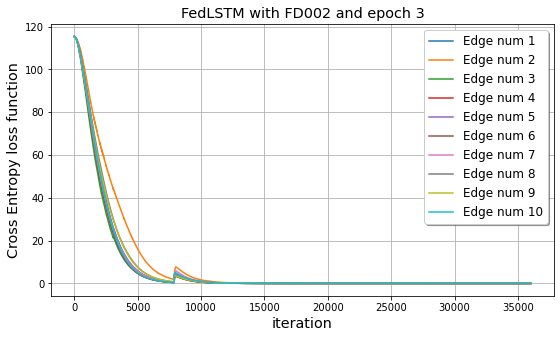

In [37]:
num_workers = 10
iteration_epoch = 3000
epoch = 3
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
cost_each_worker = np.zeros(shape=(num_workers, 4 * epoch *iteration_epoch))
for worker_i in range(num_workers):
    cost_each_worker[worker_i, :] = np.array(J[worker_i]).flatten()
    plt.plot(cost_each_worker[worker_i, :], label="Edge num " + str(worker_i+1))
plt.title("FedLSTM with FD002 and epoch 3", fontsize="x-large")
plt.ylabel("Cross Entropy loss function", fontsize="x-large")
plt.xlabel("iteration", fontsize="x-large")
plt.grid()
legened = plt.legend(shadow=True, fontsize='large')

dir_logdata_FD002_epoch_3: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD002/Results/epoch_3/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_logdata_FD002_epoch_3))
plt.savefig('J_FD002_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_03.eps', format='eps', dpi=1200, bbox_inches='tight')
plt.savefig('J_FD002_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_03.png', format='png', dpi=1200, bbox_inches='tight')

### Plot test models

C:\Users\LO98E8~1\Temp\234/ipykernel_44072/3000137348.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig[i], ax[i] = plt.subplots()


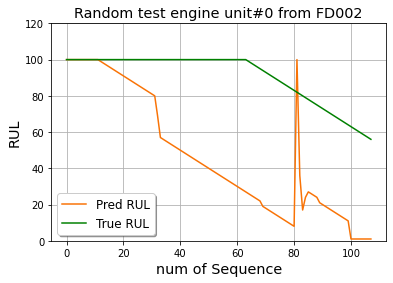

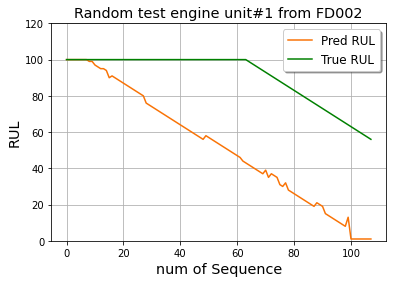

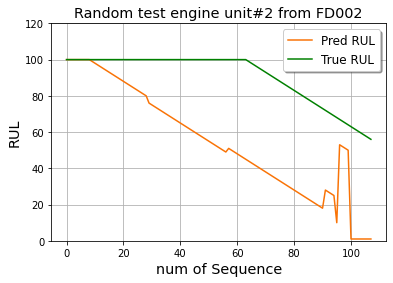

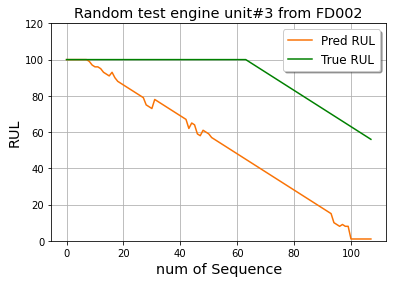

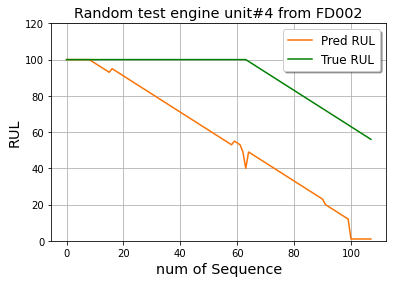

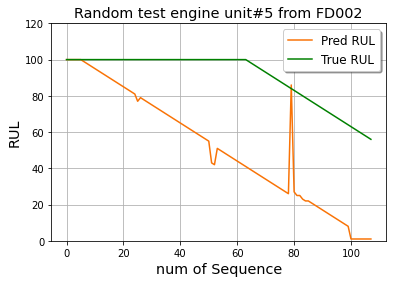

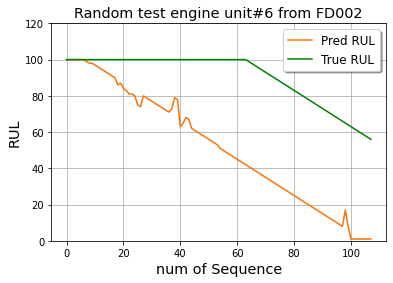

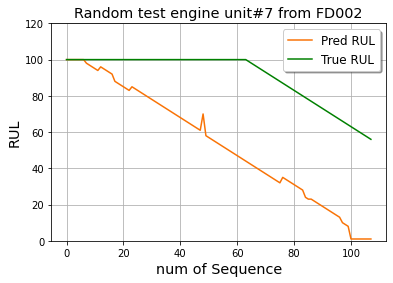

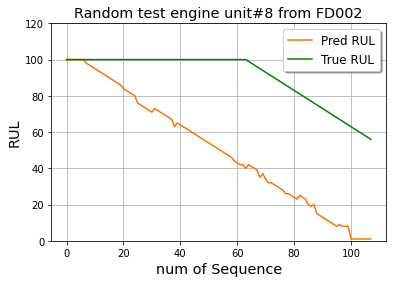

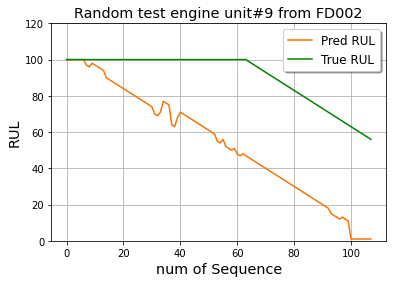

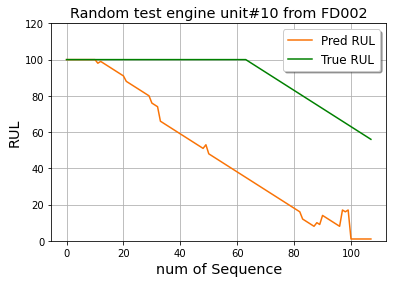

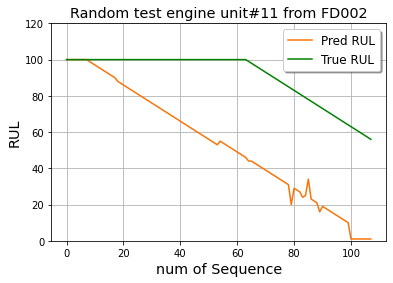

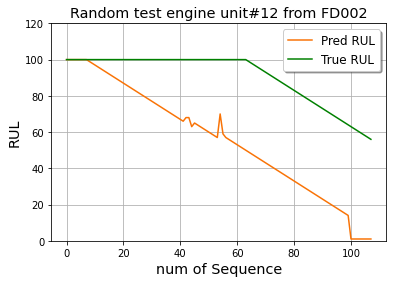

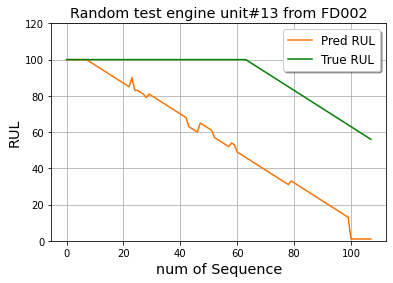

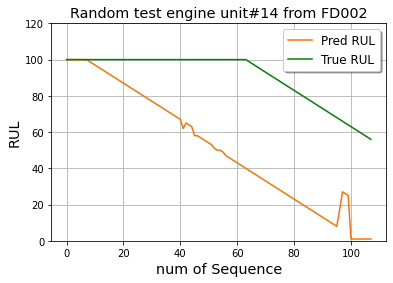

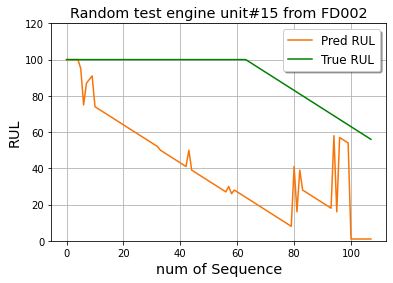

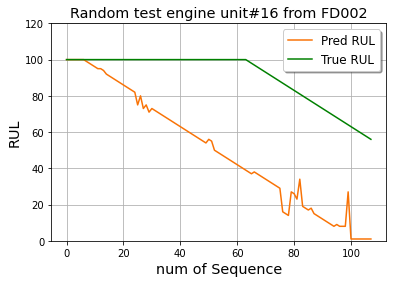

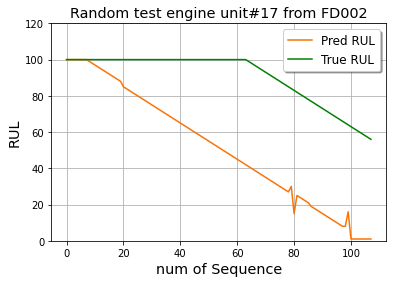

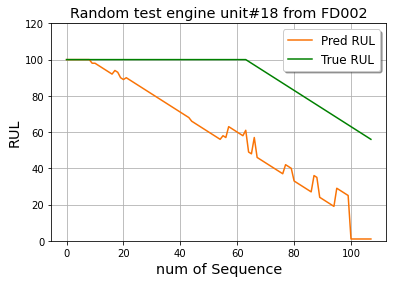

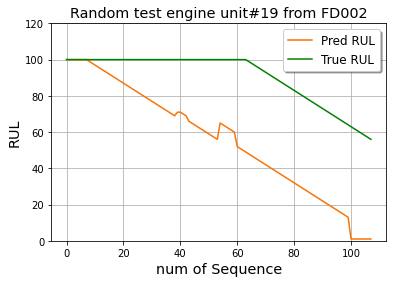

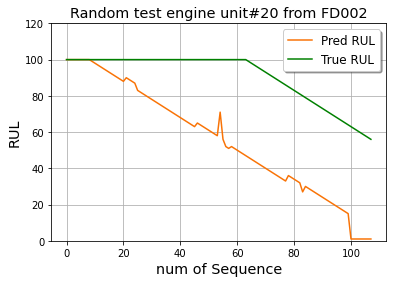

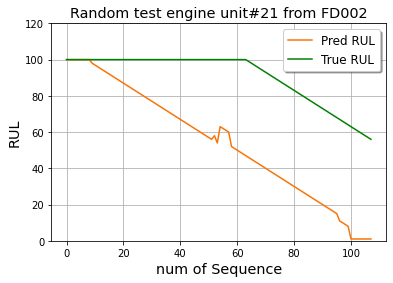

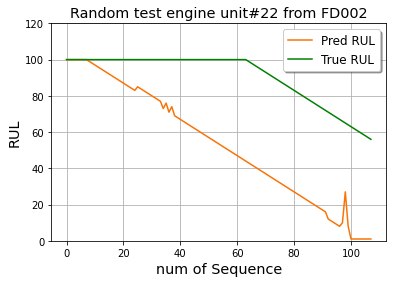

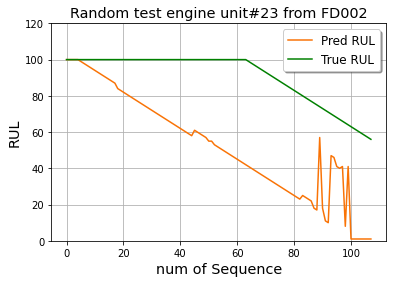

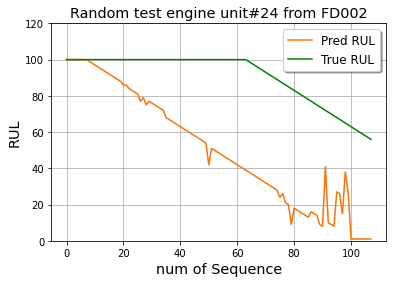

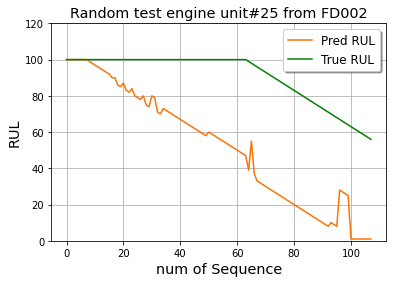

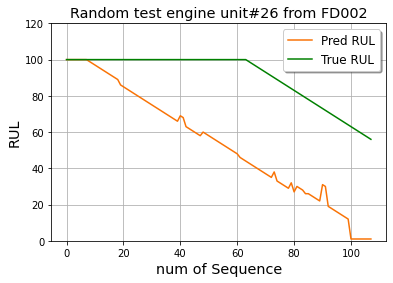

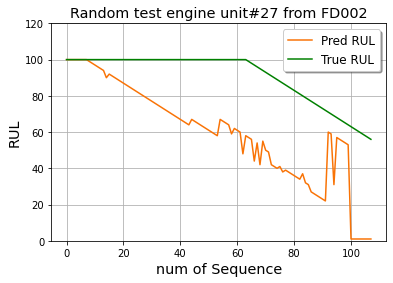

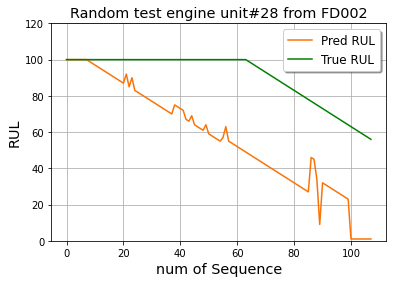

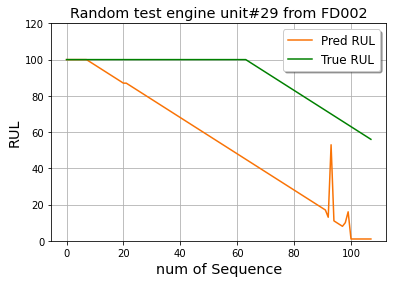

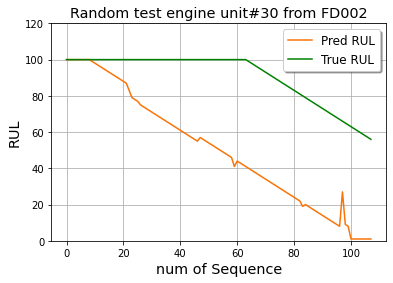

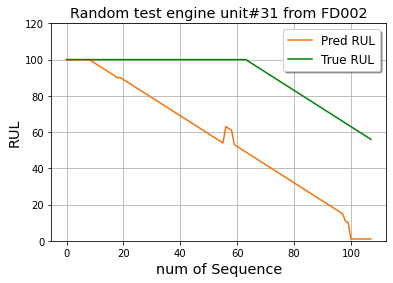

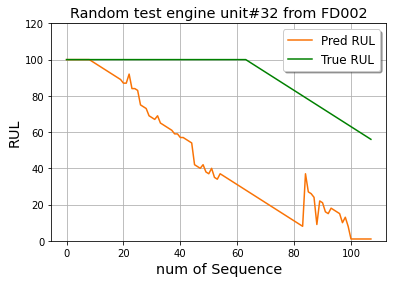

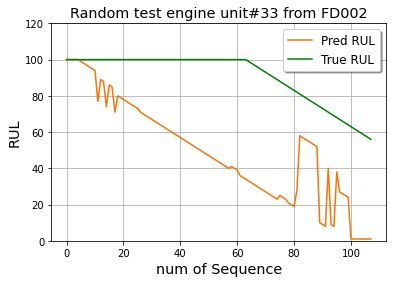

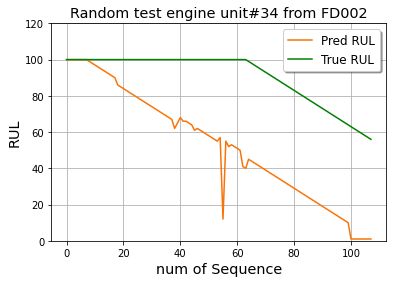

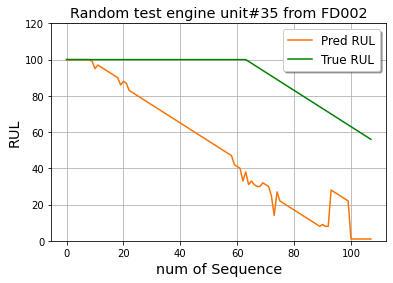

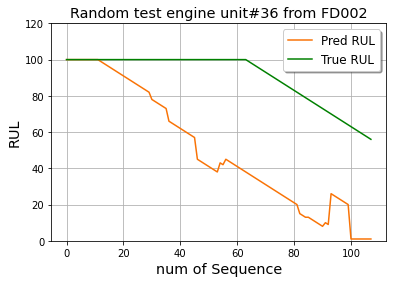

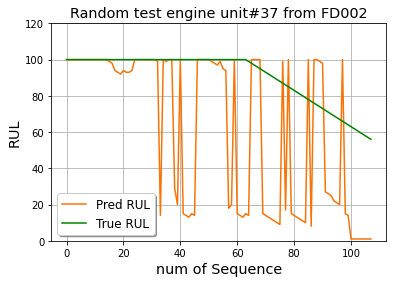

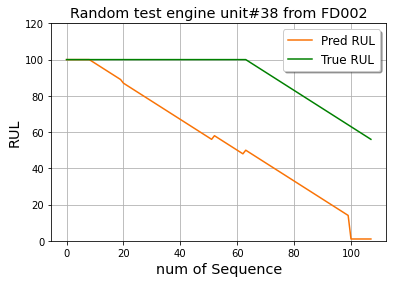

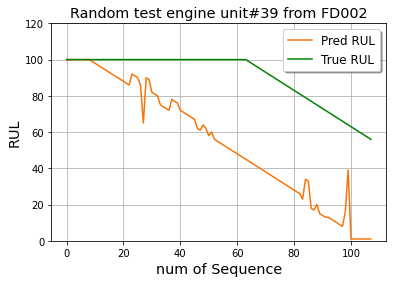

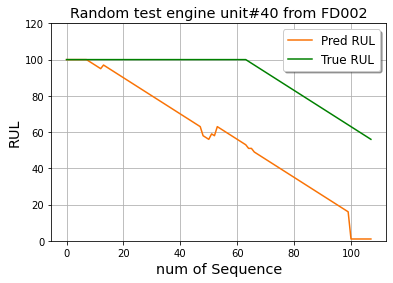

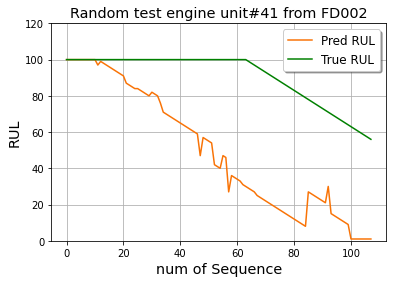

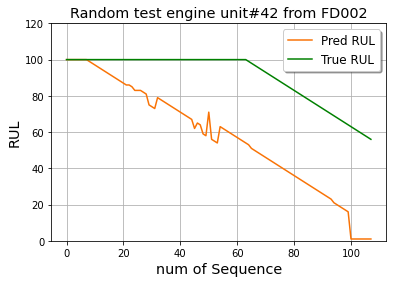

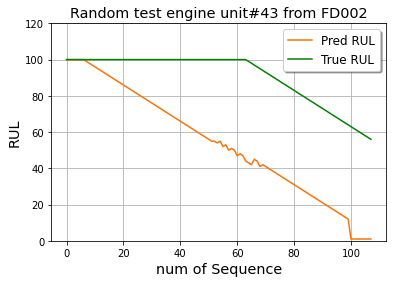

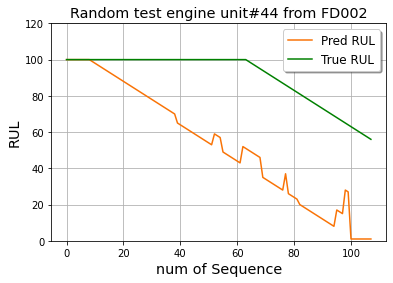

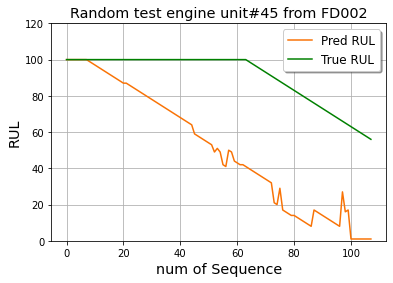

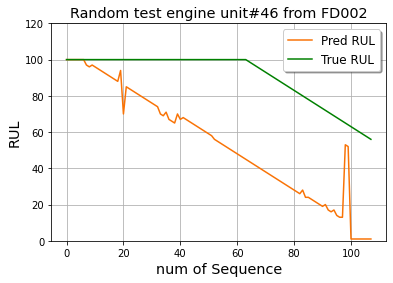

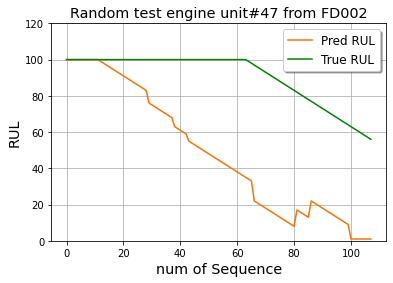

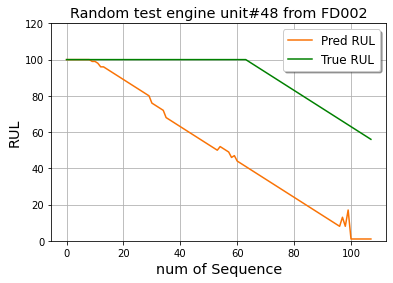

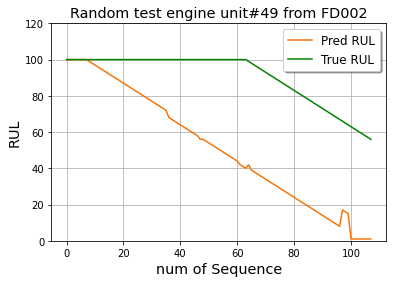

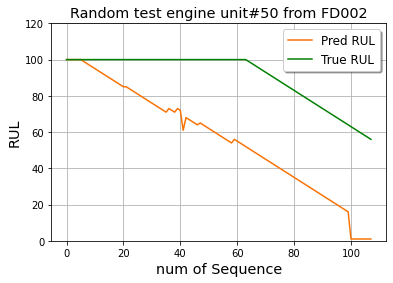

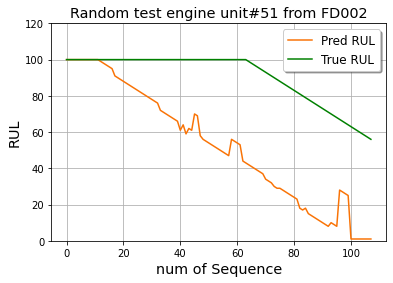

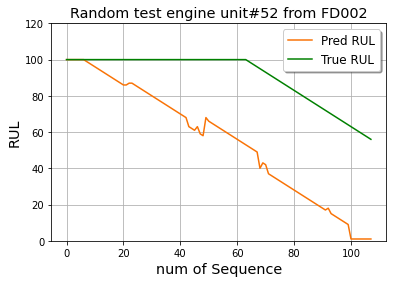

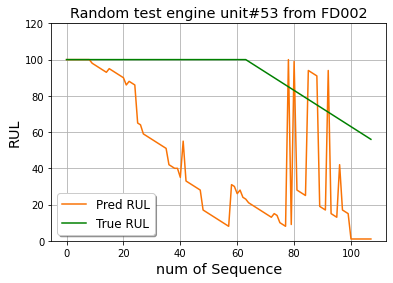

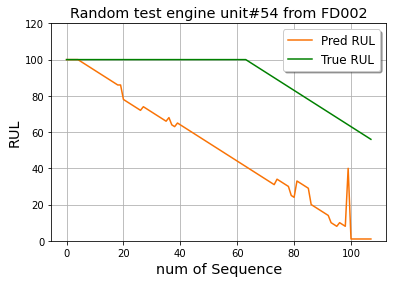

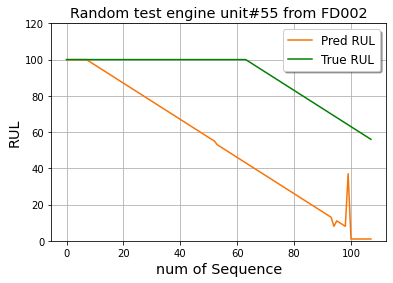

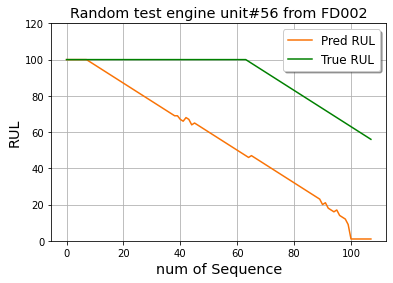

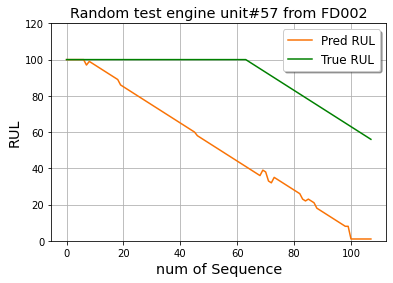

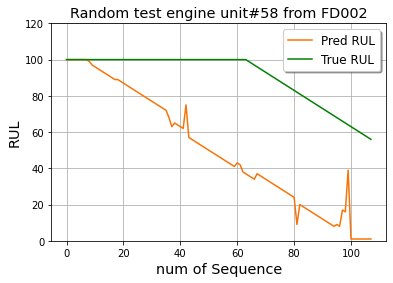

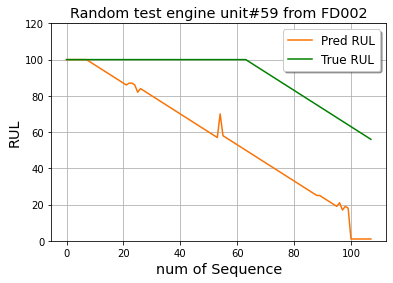

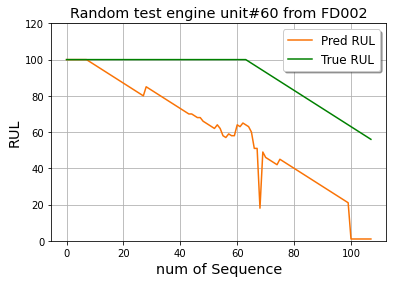

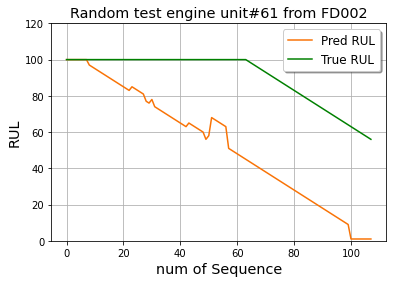

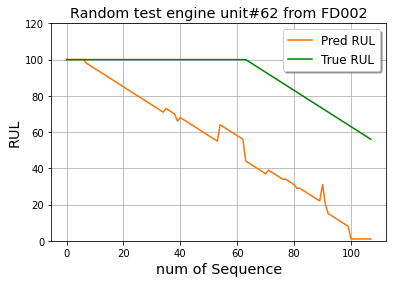

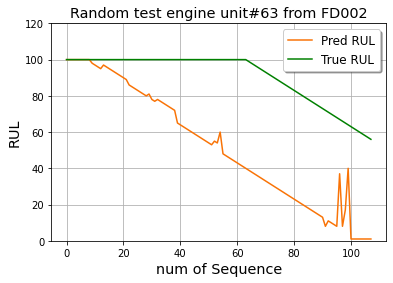

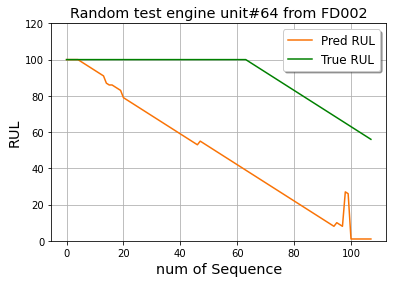

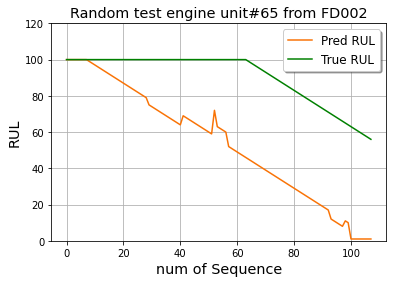

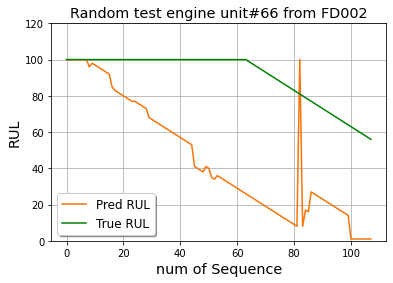

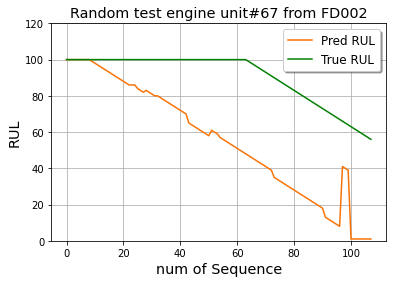

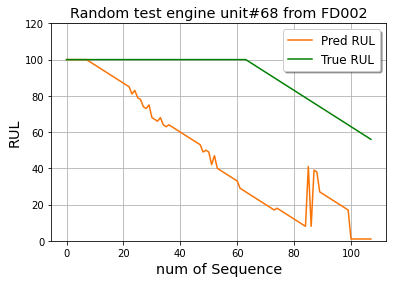

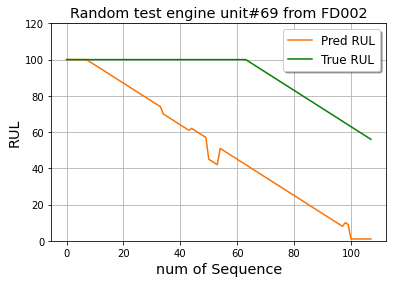

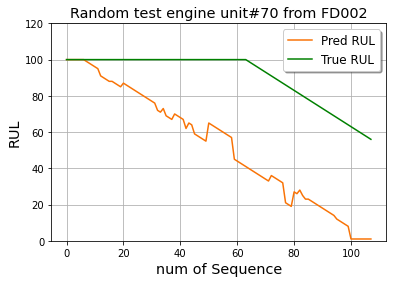

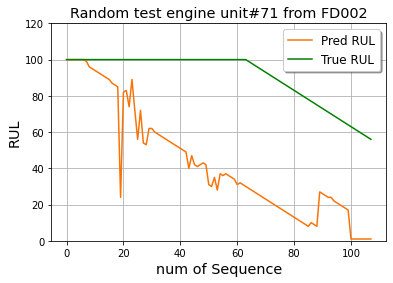

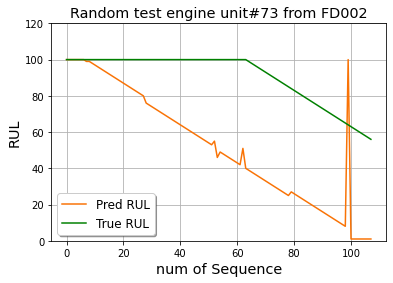

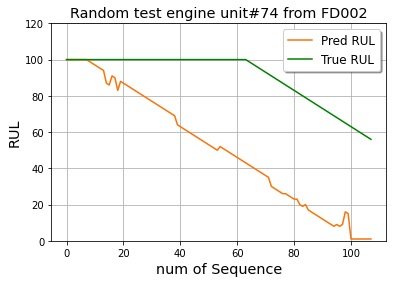

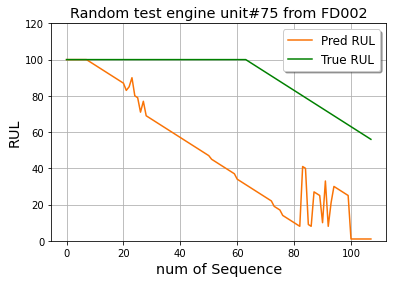

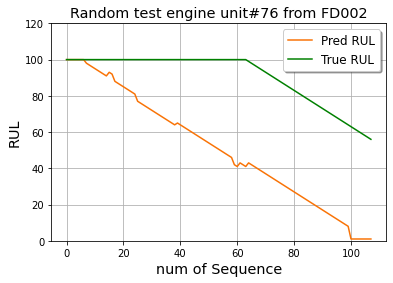

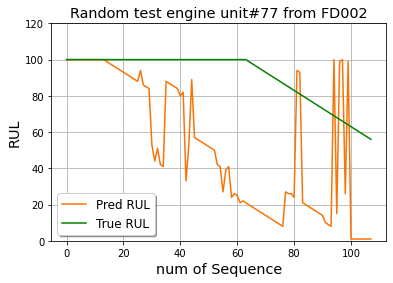

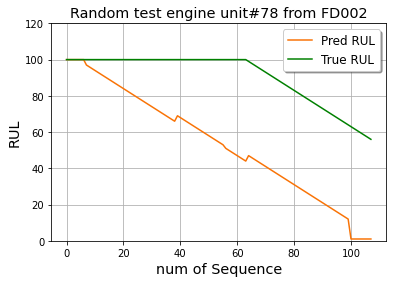

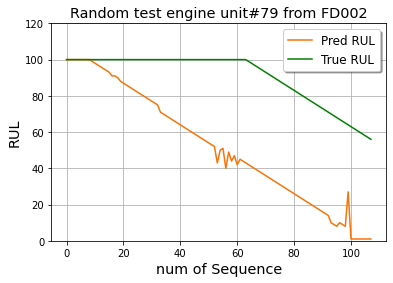

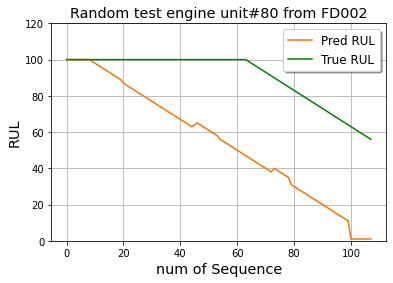

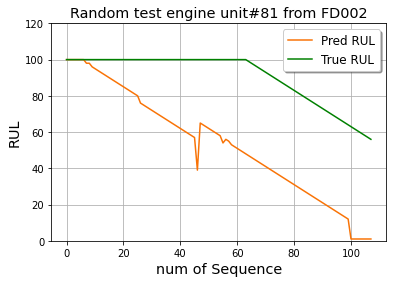

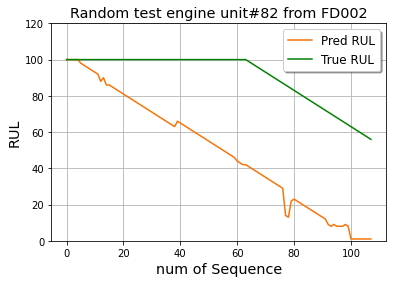

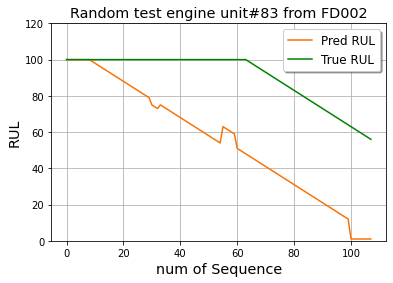

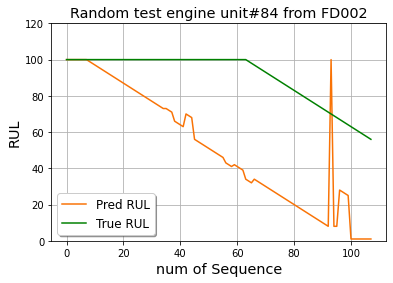

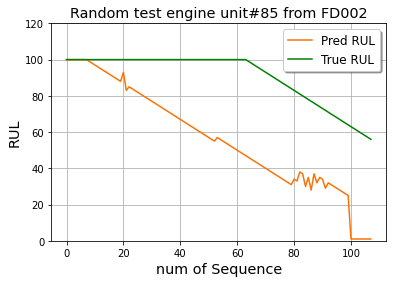

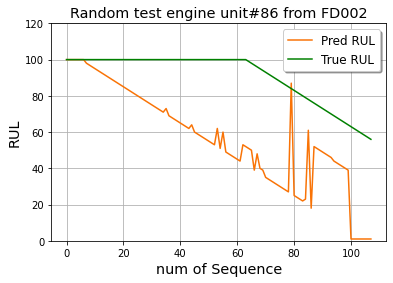

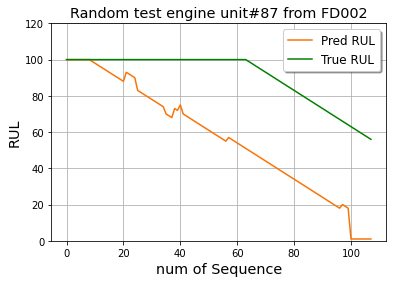

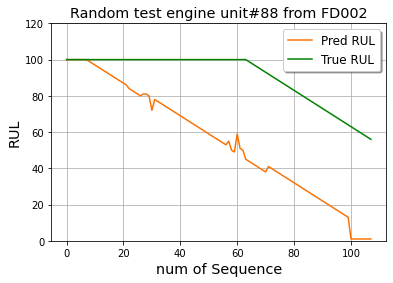

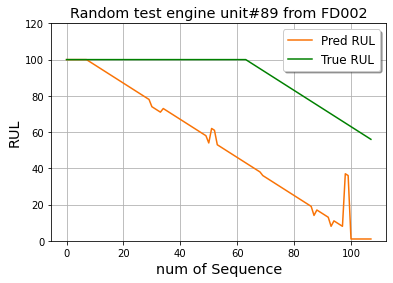

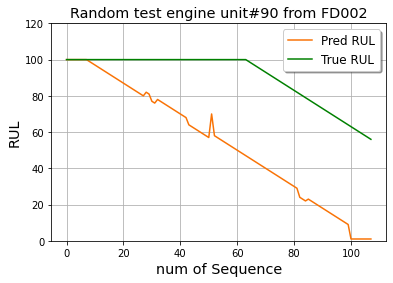

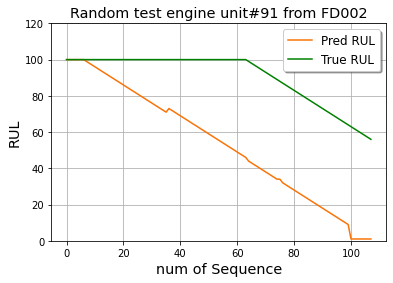

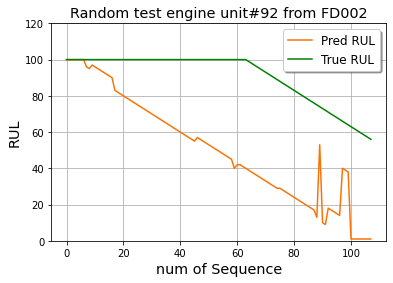

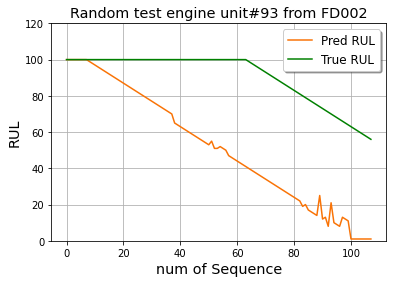

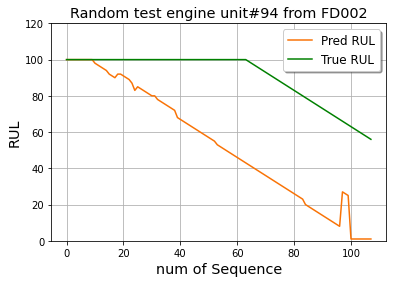

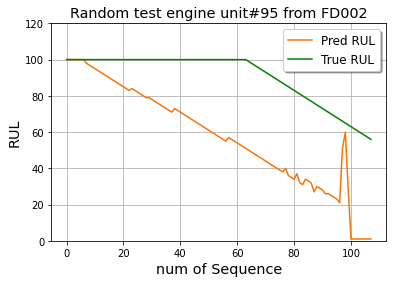

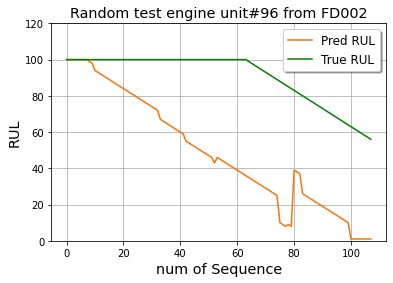

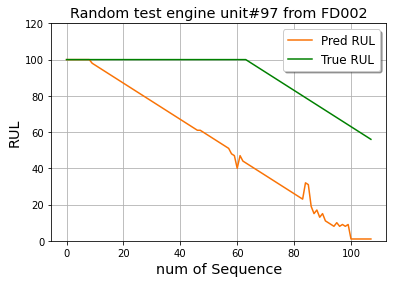

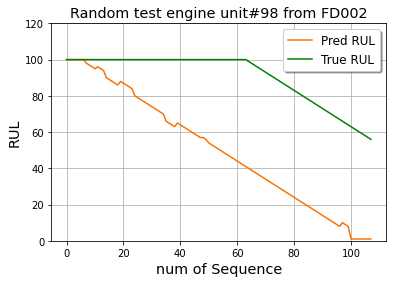

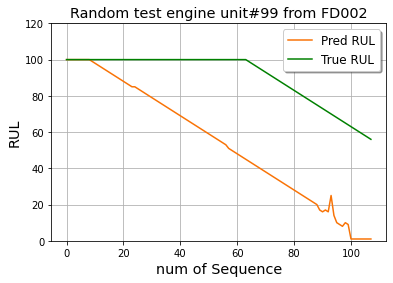

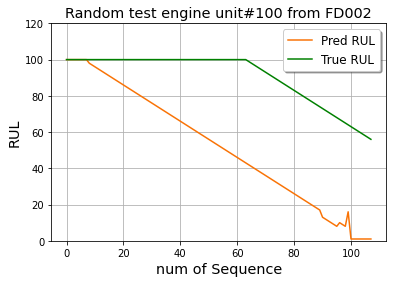

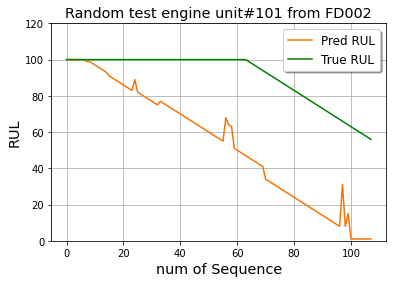

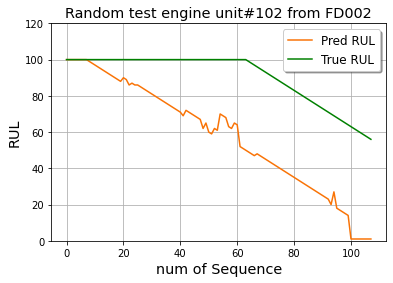

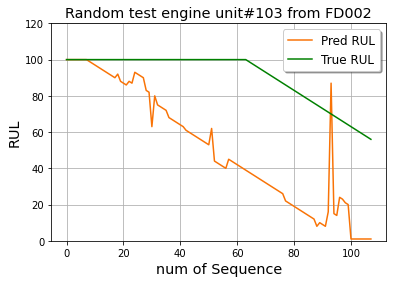

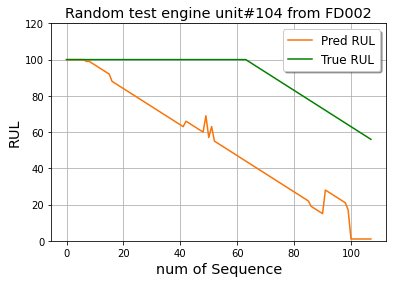

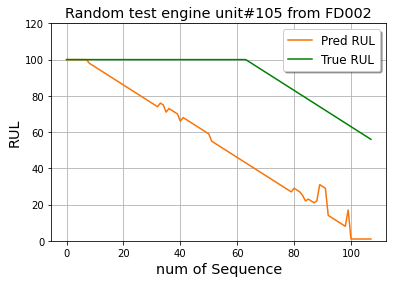

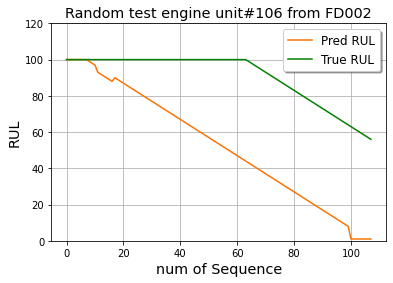

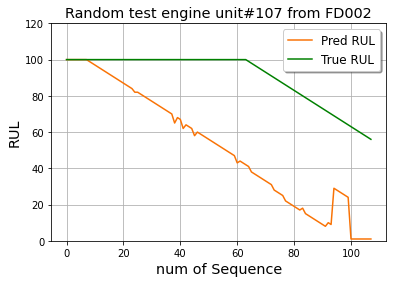

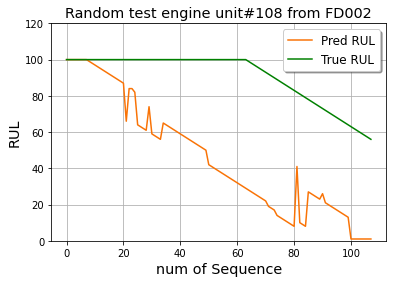

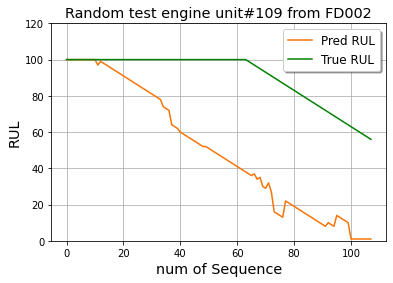

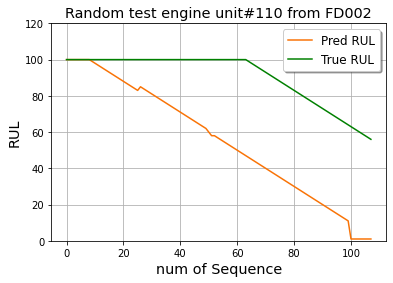

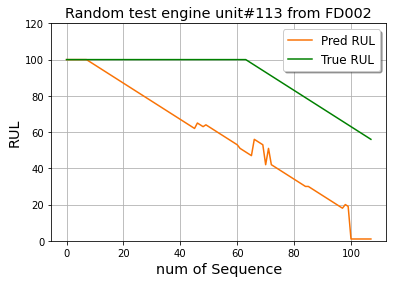

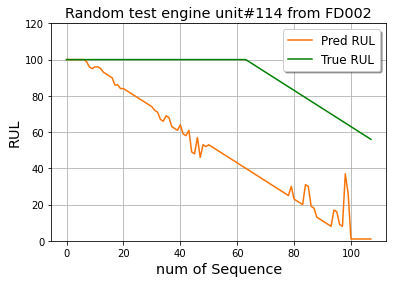

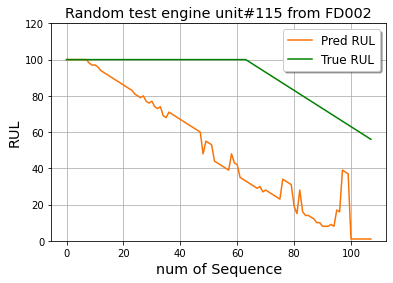

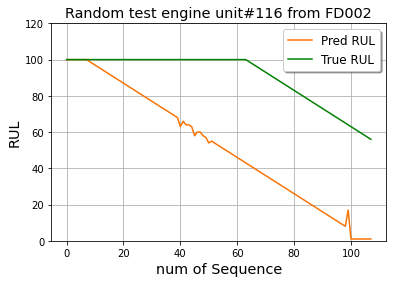

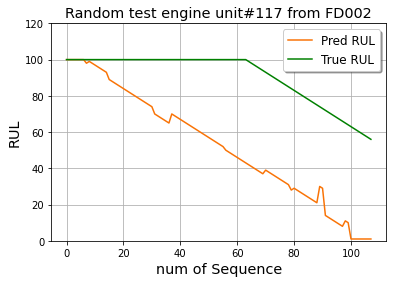

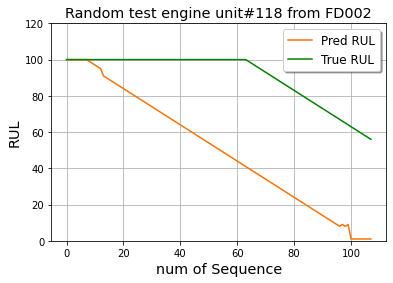

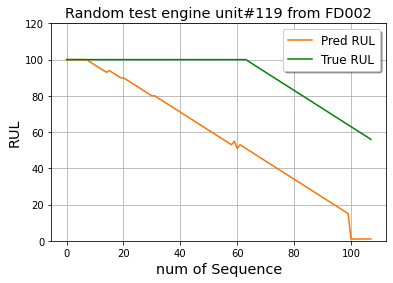

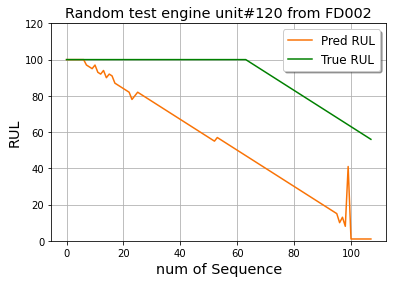

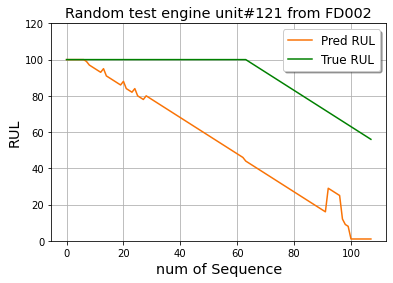

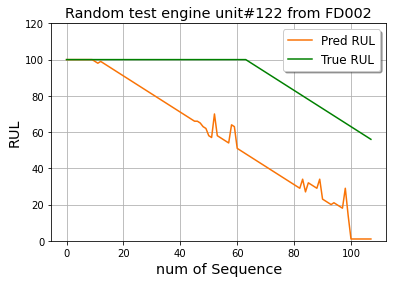

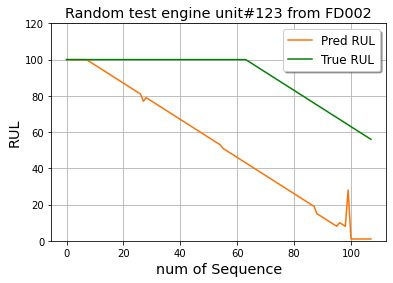

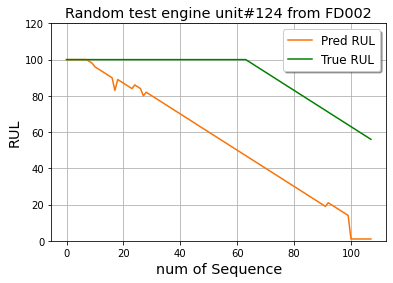

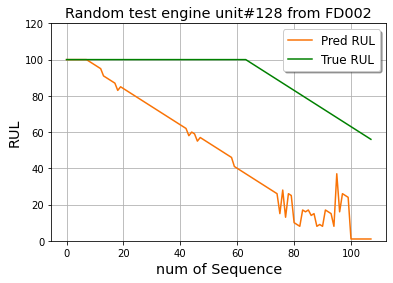

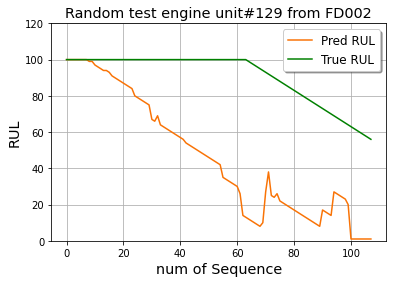

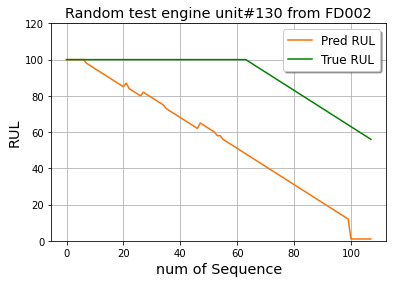

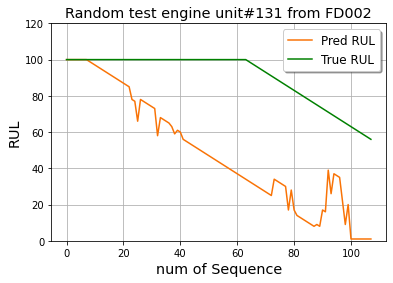

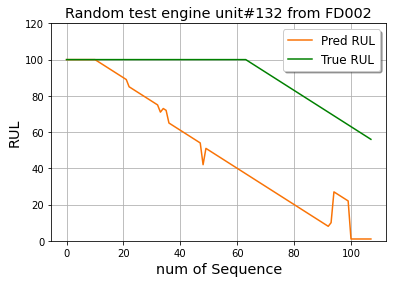

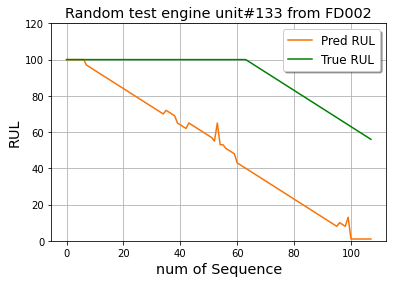

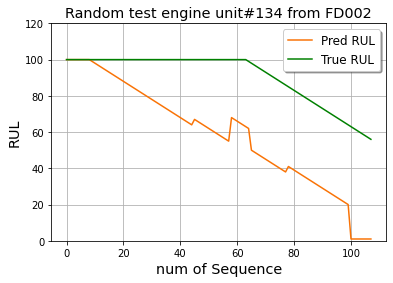

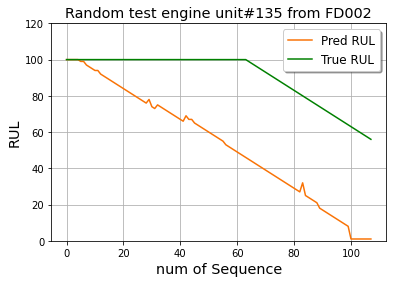

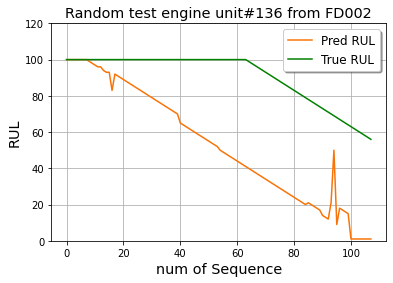

In [47]:
worker_test = LSTM()
fig={}
ax={}
for i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[i], array_params[0])
    fig[i], ax[i] = plt.subplots()
    ax[i].plot(Y_hat, label='Pred RUL', color='#F97306')
    ax[i].plot(Y_test[worker_i], label='True RUL', color='#008000')
    plt.title("Random test engine unit#" + str(i) + " from FD002", fontsize="x-large")
    plt.ylabel("RUL", fontsize="x-large")
    plt.ylim(0, 120)
    plt.xlabel("num of Sequence", fontsize="x-large")
    ax[i].grid()
    ax[i].legend(shadow=True, fontsize='large')
    #plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name_epoch_3))
    #plt.savefig("RUL_10Workers_Final_Cost_itter_3000_alpha_004_epoch_03"+str(worker_i)+".eps", format='eps', dpi=1200)
    #plt.savefig("RUL_10Workers_Final_Cost_itter_3000_alpha_004_epoch_03"+str(worker_i)+".png", format='png', dpi=1200)

In [48]:
# Save Specific figures
dir_name: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD002/Results/epoch_3/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
fig[86].savefig("FD002 RUL prediction with FedLSTM and epoch 3 for machine number_" + str(86) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
fig[86].savefig("FD002 RUL prediction with FedLSTM and epoch 3 for machine number_" + str(86) + ".png", format='png', dpi=1200, bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### RMSE and SCORE

In [43]:
# RMSE and Scoring factor epoch 3
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


RMSE = np.zeros(shape=(len(X_test),1))


for worker_i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[worker_i], array_params[0])
    RMSE[worker_i] = rmse(Y_hat, Y_test[worker_i])

fig, ax = plt.subplots()
plt.plot(RMSE, label='RMSE', marker = 's')
plt.title("RMSE for RUL estimation on FD002 epoch 3", fontsize="x-large")
plt.ylabel("RMSE", fontsize="x-large")
plt.xlabel("Bach of test data", fontsize="x-large")
plt.grid()


RMSE_epoch_3 = np.sum(RMSE, axis=0)/len(X_test)
labels = []
labels.append("total RMSE ="+str(RMSE_epoch_3))

plt.legend(labels, loc='best', fontsize='large')

print(RMSE_epoch_3)
dir_name: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD002/Results/epoch_3/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
plt.savefig("RMSE for RUL estimation FedLSTM on test dataset FD002 epoch 3.eps", format='eps', dpi=1200, bbox_inches='tight')
plt.savefig("RMSE for RUL estimation FedLSTM on test dataset FD002 epoch 3.png", format='png', dpi=1200, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[32.75909718]


In [49]:
def each_score(predictions, targets):
    tmp = np.zeros(shape=(1, len(predictions)))
    for i in range(len(predictions)):
        Yi = predictions[i] - targets[i]
        if Yi >= 0:
            tmp[:, i] = (np.exp(Yi/10)-1)   
        else:
            tmp[:, i] = np.exp(Yi/13)-1
    return tmp
    
SCORE = np.zeros(shape=(len(X_test), X_test[0].shape[0]))

for worker_i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[worker_i], array_params[0])
    SCORE[worker_i, :] = each_score(Y_hat, Y_test[worker_i])
    
print(np.sum(SCORE, axis=1))
plt.plot(np.sum(SCORE, axis=1))
print("Final value for SCORE:",np.sum(SCORE)/len(X_test))

[ 1.95629258e+02 -8.78594871e+01 -4.47624104e+00 -3.48727157e+01
 -8.45634876e+01  4.80835592e+01 -4.03049786e+01 -8.17001022e+01
 -6.35037158e+01 -8.54147471e+01 -8.57050807e+01 -7.48225792e+01
 -8.70986990e+01 -4.22444773e+01 -8.76387245e+01 -9.87958697e+01
 -8.90655400e+01 -5.95863582e+01 -8.36180861e+01 -8.70121342e+01
 -8.45402235e+01 -8.37060013e+01 -8.54807329e+01 -7.24896182e+01
 -6.94160575e+01 -3.27294511e+01 -6.24924213e+01 -8.67068768e+01
 -3.73226465e+01 -4.53016171e+01 -8.76738260e+01 -8.50171527e+01
 -8.29265496e+01 -9.32471817e+01 -8.57481657e+01 -8.55223530e+01
 -6.41505240e+01  9.30816300e+03 -8.67262574e+01 -8.43073333e+01
 -8.50723174e+01 -7.09136175e+01 -8.64904051e+01 -8.83706390e+01
 -8.66932744e+01 -8.48258093e+01 -8.68638127e+01 -7.04570924e+01
 -7.06090073e+01 -8.68478501e+01 -6.76040532e+01 -8.55085375e+01
 -3.04010385e+01  4.24850026e+03 -9.02132092e+01 -8.19796695e+01
 -3.86382457e+01 -6.61040732e+01 -4.53494628e+01 -8.63163469e+01
 -8.49703546e+01 -8.85432

## Load Cost functions and Parameters

In [101]:
import numpy as np
import pickle
# from model import *

# Import libraries
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import time
import math
import sys
import random

dir_logdata_FD002_epoch_3: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD002/LogData/epoch_3/ "    
# Load cost from a PKL file
a_file = open(dir_logdata_FD002_epoch_3 + "J_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_03.pkl", "rb")
J = pickle.load(a_file)
a_file.close()

# Load params data from a PKL file
a_file = open(dir_logdata_FD002_epoch_3 + "array_params_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_03.pkl", "rb")
array_params = pickle.load(a_file)
print(array_params)
a_file.close()

[{'Wf': array([[-0.18564977,  0.0322141 , -0.04818845, ..., -0.12048841,
         0.09804777,  0.05325   ],
       [-0.06109197,  0.09811411, -0.04168961, ...,  0.08114126,
         0.08047905,  0.05512676],
       [-0.12158022, -0.13627538, -0.17668155, ..., -0.20193493,
         0.20272957,  0.12999881],
       ...,
       [ 0.01255876,  0.16984161,  0.03624951, ..., -0.08108413,
         0.04121908,  0.00478767],
       [ 0.02036318,  0.06390896, -0.02934949, ...,  0.06846599,
         0.09238949,  0.08252651],
       [ 0.04791726,  0.01360442, -0.01159031, ...,  0.07645322,
         0.05202115,  0.05020851]]), 'bf': array([[1.05032015],
       [1.08373612],
       [1.08920687],
       [1.02828693],
       [1.0825476 ],
       [1.14573225],
       [1.04020056],
       [1.06803859],
       [1.07327751],
       [1.0113719 ],
       [1.0307025 ],
       [1.02641318],
       [1.07471422],
       [1.07047969],
       [1.10095669],
       [1.0111647 ],
       [1.06367949],
       [1.00765